# **IMPORTING LIBRARIES**

In [1]:
!pip uninstall -y numpy pmdarima statsmodels
!pip install --no-cache-dir numpy
!pip install --no-cache-dir pmdarima statsmodels
!pip install --no-cache-dir "pmdarima==1.8.5"
!pip uninstall -y statsmodels
!pip install statsmodels

Found existing installation: numpy 2.2.5
Uninstalling numpy-2.2.5:
  Successfully uninstalled numpy-2.2.5
Found existing installation: pmdarima 1.8.5
Uninstalling pmdarima-1.8.5:
  Successfully uninstalled pmdarima-1.8.5
Found existing installation: statsmodels 0.14.4
Uninstalling statsmodels-0.14.4:
  Successfully uninstalled statsmodels-0.14.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 290.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.14.5 requires statsmodels>=0.14.0, which is not installed.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.0 MB

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import calendar
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm_notebook
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fftpack import fft
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import skew, kurtosis
from scipy import stats
from scipy.optimize import curve_fit
from statsmodels.stats.diagnostic import acorr_ljungbox

# **EXPLORATORY DATA ANALYSIS**

In [4]:
climate_data = pd.read_csv("/content/GlobalLandTemperaturesByMajorCity.csv")
climate_data.head()

dt  AverageTemperature  AverageTemperatureUncertainty     City  \
0  1849-01-01              26.704                          1.435  Abidjan   
1  1849-02-01              27.434                          1.362  Abidjan   
2  1849-03-01              28.101                          1.612  Abidjan   
3  1849-04-01              26.140                          1.387  Abidjan   
4  1849-05-01              25.427                          1.200  Abidjan   

         Country Latitude Longitude  
0  Côte D'Ivoire    5.63N     3.23W  
1  Côte D'Ivoire    5.63N     3.23W  
2  Côte D'Ivoire    5.63N     3.23W  
3  Côte D'Ivoire    5.63N     3.23W  
4  Côte D'Ivoire    5.63N     3.23W

In [5]:
delhi_climate = climate_data[climate_data.City == 'Delhi']
delhi_climate.head()

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
63153  1796-01-01              14.590                          2.374  Delhi   
63154  1796-02-01              17.109                          1.940  Delhi   
63155  1796-03-01              21.454                          2.608  Delhi   
63156  1796-04-01              28.715                          2.122  Delhi   
63157  1796-05-01              33.726                          1.997  Delhi   

      Country Latitude Longitude  
63153   India   28.13N    77.27E  
63154   India   28.13N    77.27E  
63155   India   28.13N    77.27E  
63156   India   28.13N    77.27E  
63157   India   28.13N    77.27E

In [6]:
processed_data = delhi_climate.copy()

In [7]:
processed_data['ObservationDate'] = pd.to_datetime(processed_data['dt'])

In [8]:
processed_data.set_index(processed_data['ObservationDate'], inplace = True)
processed_data.index

DatetimeIndex(['1796-01-01', '1796-02-01', '1796-03-01', '1796-04-01',
               '1796-05-01', '1796-06-01', '1796-07-01', '1796-08-01',
               '1796-09-01', '1796-10-01',
               ...
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01'],
              dtype='datetime64[ns]', name='ObservationDate', length=2613, freq=None)

In [9]:
processed_data.head()

dt  AverageTemperature  \
ObservationDate                                   
1796-01-01       1796-01-01              14.590   
1796-02-01       1796-02-01              17.109   
1796-03-01       1796-03-01              21.454   
1796-04-01       1796-04-01              28.715   
1796-05-01       1796-05-01              33.726   

                 AverageTemperatureUncertainty   City Country Latitude  \
ObservationDate                                                          
1796-01-01                               2.374  Delhi   India   28.13N   
1796-02-01                               1.940  Delhi   India   28.13N   
1796-03-01                               2.608  Delhi   India   28.13N   
1796-04-01                               2.122  Delhi   India   28.13N   
1796-05-01                               1.997  Delhi   India   28.13N   

                Longitude ObservationDate  
ObservationDate                            
1796-01-01         77.27E      1796-01-01  
1796-02-01         77.27E      1796-02-01  
1796-03-01         77.27E      1796-03-01  
1796-04-01         77.27E      1796-04-01  
1796-05-01         77.27E      1796-05-01

In [10]:
drop_columns = ['ObservationDate', 'AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude', 'dt']
processed_data.drop(drop_columns, axis = 1, inplace = True)
processed_data

AverageTemperature
ObservationDate                    
1796-01-01                   14.590
1796-02-01                   17.109
1796-03-01                   21.454
1796-04-01                   28.715
1796-05-01                   33.726
...                             ...
2013-05-01                   34.746
2013-06-01                   33.066
2013-07-01                   31.053
2013-08-01                   29.900
2013-09-01                      NaN

[2613 rows x 1 columns]

In [11]:
processed_data.shape

(2613, 1)

In [12]:
processed_data = processed_data['1950':]
processed_data

AverageTemperature
ObservationDate                    
1950-01-01                   15.435
1950-02-01                   15.322
1950-03-01                   21.874
1950-04-01                   27.833
1950-05-01                   33.829
...                             ...
2013-05-01                   34.746
2013-06-01                   33.066
2013-07-01                   31.053
2013-08-01                   29.900
2013-09-01                      NaN

[765 rows x 1 columns]

In [13]:
processed_data.shape

(765, 1)

In [14]:
processed_data.isnull().sum()

AverageTemperature    1
dtype: int64

In [15]:
total_missing = processed_data.isnull().sum().sort_values(ascending = False)
percent_missing = (processed_data.isnull().sum()*100/processed_data.isnull().count()).sort_values(ascending = False)
missing_values_report = pd.concat([total_missing, percent_missing], axis = 1, keys = ['Total', 'Percentage of Missing Values'])
missing_values_report

Total  Percentage of Missing Values
AverageTemperature      1                      0.130719

## **Interpolating the missing values**

In [16]:
processed_data['AverageTemperature'] = processed_data['AverageTemperature'].interpolate(method='time')

In [17]:
processed_data.isnull().sum()

AverageTemperature    0
dtype: int64

In [18]:
processed_data.shape

(765, 1)

# **UNDERSTANDING TIME SERIES USING PLOTS**

## **Plotting the time series year wise and month wise**

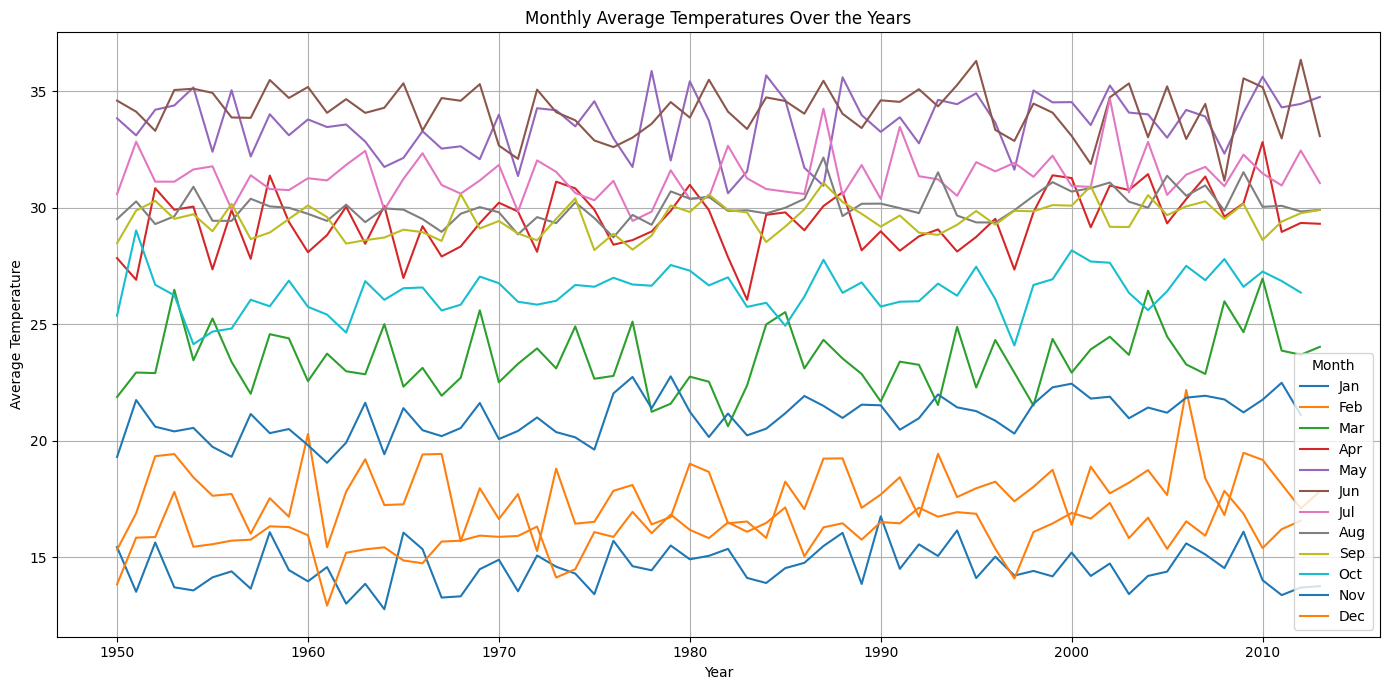

In [55]:
# Convert index to datetime if not already
processed_data.index = pd.to_datetime(processed_data.index)

processed_data['Year'] = processed_data.index.year
processed_data['Month'] = processed_data.index.month

# Pivot to get years as rows and months as columns
pivot_processed_data = processed_data.pivot(index='Year', columns='Month', values='AverageTemperature')

plt.figure(figsize=(14, 7))
for month in range(1, 13):
    if month in pivot_processed_data.columns:
        plt.plot(pivot_processed_data.index, pivot_processed_data[month], label=pd.to_datetime(str(month), format='%m').strftime('%b'))

plt.title('Monthly Average Temperatures Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.legend(title='Month')
plt.grid(True)
plt.tight_layout()
plt.show()

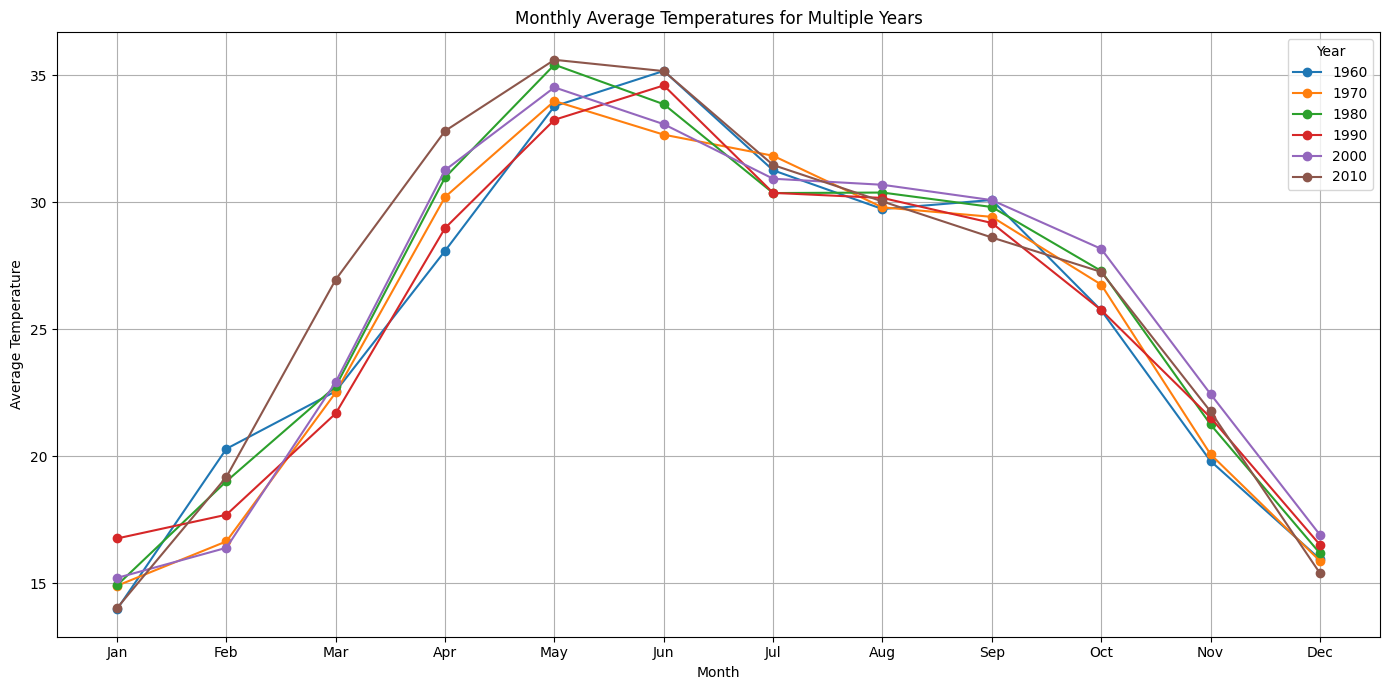

In [56]:

processed_data.index = pd.to_datetime(processed_data.index)

processed_data['Year'] = processed_data.index.year
processed_data['Month'] = processed_data.index.month

years_to_plot = [1960, 1970, 1980, 1990, 2000, 2010]


plt.figure(figsize=(14, 7))

for year in years_to_plot:
    processed_data_year = processed_data[processed_data['Year'] == year].sort_values('Month')
    if not processed_data_year.empty:
        plt.plot(
            processed_data_year['Month'],
            processed_data_year['AverageTemperature'],
            marker='o',
            label=str(year)
        )

plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Monthly Average Temperatures for Multiple Years')
plt.xlabel('Month')
plt.ylabel('Average Temperature')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()
plt.show()

## **Checking the skewness and kurtosis of data year wise**

In [57]:
# If the index is datetime, extract year from index
processed_data['Year'] = processed_data.index.year

yearly_stats = processed_data.groupby('Year')['AverageTemperature'].agg(
    Mean='mean',
    Std_Dev='std',
    Skewness=lambda x: skew(x.dropna()),
    Kurtosis=lambda x: kurtosis(x.dropna())
)


print("📆 Yearly Skewness and Kurtosis for Delhi (1950–2013):")
print(yearly_stats.round(3))

📆 Yearly Skewness and Kurtosis for Delhi (1950–2013):
        Mean  Std_Dev  Skewness  Kurtosis
Year                                     
1950  24.661    7.337    -0.213    -1.346
1951  25.584    7.221    -0.446    -1.234
1952  25.836    6.692    -0.347    -1.356
1953  26.136    6.821    -0.438    -0.994
1954  25.677    7.470    -0.269    -1.266
...      ...      ...       ...       ...
2009  26.554    6.782    -0.308    -1.321
2010  26.520    7.358    -0.481    -1.039
2011  25.630    6.822    -0.526    -0.996
2012  25.889    7.439    -0.280    -1.189
2013  27.064    7.104    -0.881    -0.575

[64 rows x 4 columns]


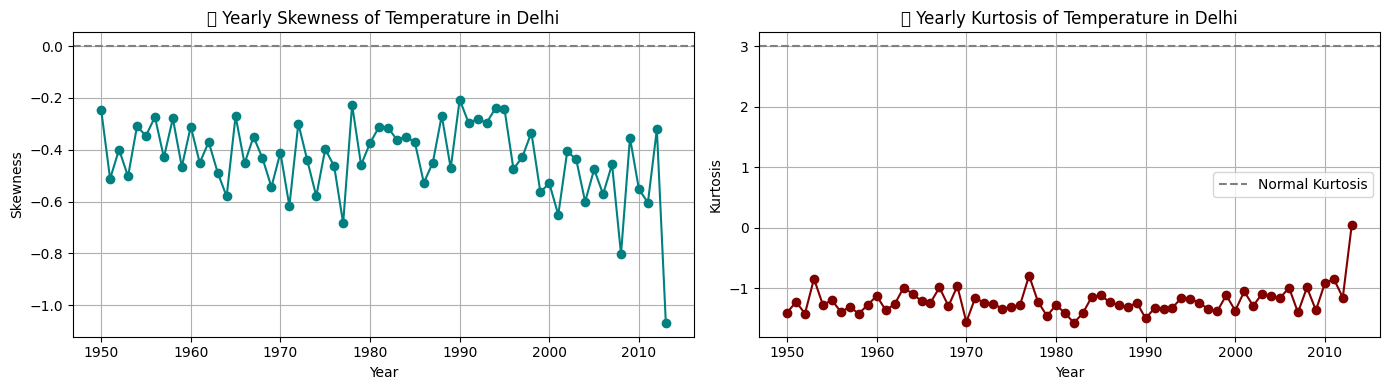

In [58]:
# Ensure datetime index is used
processed_data.index = pd.to_datetime(processed_data.index)

processed_data['Year'] = processed_data.index.year

processed_data = processed_data[processed_data['Year'] >= 1950].copy()

processed_data = processed_data.dropna(subset=['AverageTemperature'])

yearly_stats = processed_data.groupby('Year')['AverageTemperature'].agg(
    Skewness=lambda x: skew(x, bias=False),
    Kurtosis=lambda x: kurtosis(x, bias=False)
)

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(yearly_stats.index, yearly_stats['Skewness'], marker='o', color='teal')
plt.axhline(0, color='gray', linestyle='--')
plt.title("📉 Yearly Skewness of Temperature in Delhi")
plt.xlabel("Year")
plt.ylabel("Skewness")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(yearly_stats.index, yearly_stats['Kurtosis'], marker='o', color='maroon')
plt.axhline(3, color='gray', linestyle='--', label='Normal Kurtosis')
plt.title("📈 Yearly Kurtosis of Temperature in Delhi")
plt.xlabel("Year")
plt.ylabel("Kurtosis")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **Fitting the global warm trend decade wise**

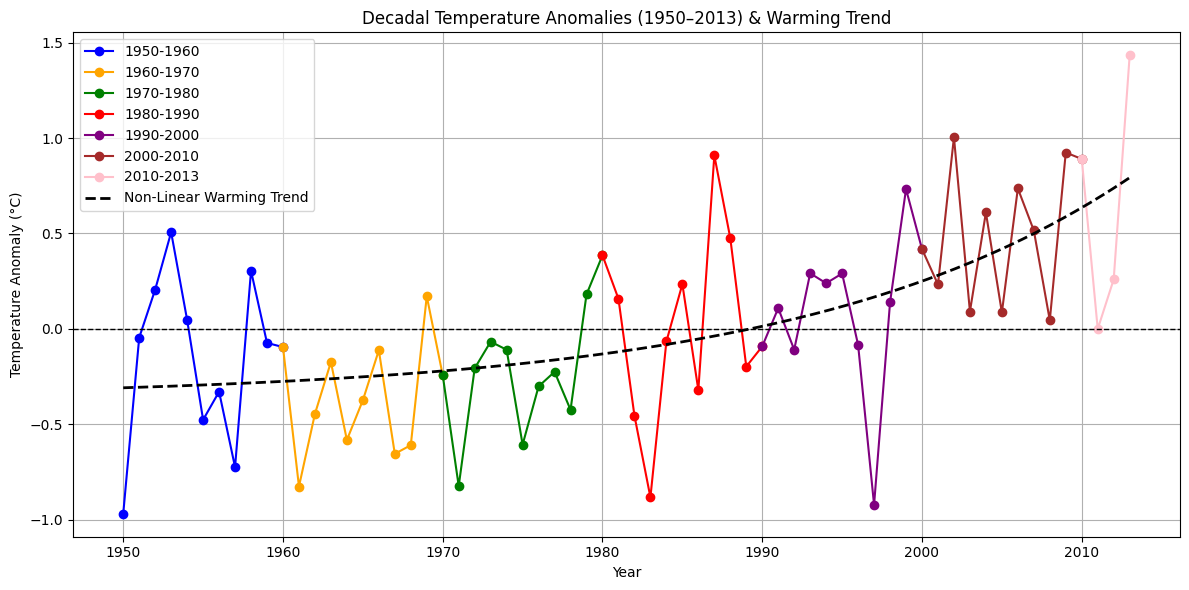

In [59]:

processed_data.index = pd.to_datetime(processed_data.index)

data_filtered = processed_data[processed_data.index.year >= 1950].copy()
data_filtered['Year'] = data_filtered.index.year

annual_avg_temp = data_filtered.groupby('Year')['AverageTemperature'].mean()


long_term_avg = annual_avg_temp.mean()

# Compute anomalies
temperature_anomalies = annual_avg_temp - long_term_avg

decades = [(1950, 1960), (1960, 1970), (1970, 1980), (1980, 1990),
           (1990, 2000), (2000, 2010), (2010, 2013)]

plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

for i, (start, end) in enumerate(decades):
    decade_data = temperature_anomalies.loc[start:end]
    plt.plot(decade_data.index, decade_data.values, marker='o', linestyle='-', label=f"{start}-{end}", color=colors[i])

# Exponential model for trend fitting
def exp_growth(x, a, b, c):
    return a * np.exp(b * (x - 1950)) + c

years = np.array(annual_avg_temp.index)
temps = np.array(annual_avg_temp.values)
params, _ = curve_fit(exp_growth, years, temps, p0=[0.02, 0.02, 20])

years_fine = np.linspace(1950, 2013, 300)
trend_values = exp_growth(years_fine, *params)
anomaly_trend = trend_values - long_term_avg

plt.plot(years_fine, anomaly_trend, 'k--', linewidth=2, label="Non-Linear Warming Trend")

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.title("Decadal Temperature Anomalies (1950–2013) & Warming Trend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Fitting the four degree polynomial decade wise**

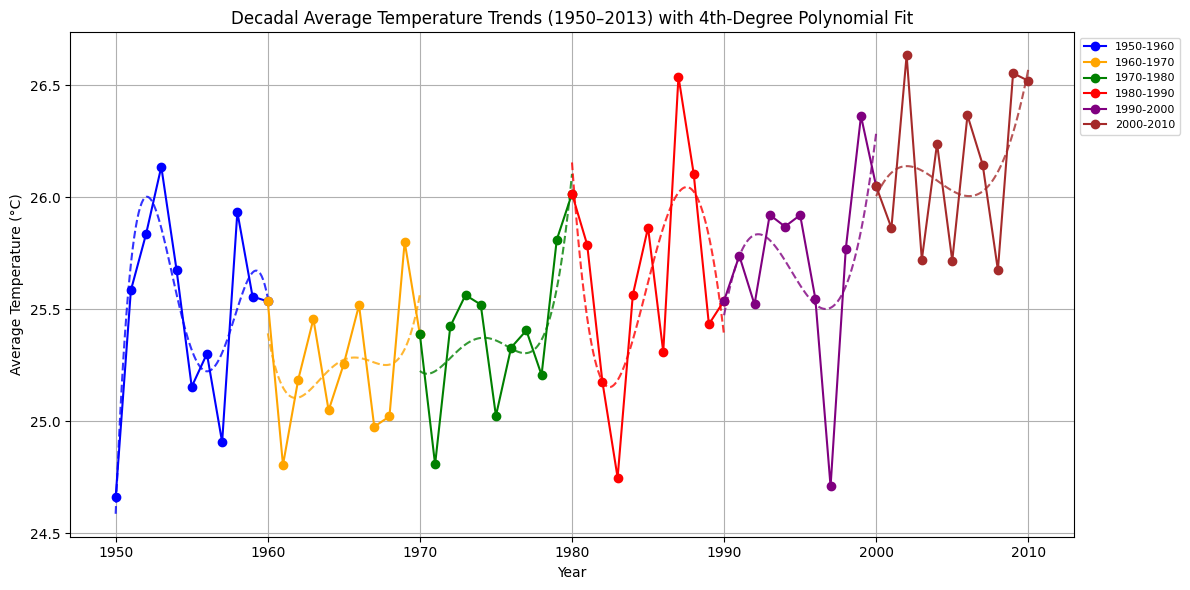

In [60]:

processed_data.index = pd.to_datetime(processed_data.index)

data_filtered = processed_data[processed_data.index.year >= 1950].copy()
data_filtered['Year'] = data_filtered.index.year

# Compute annual average temperatures
annual_avg_temp = data_filtered.groupby('Year')['AverageTemperature'].mean()

# Compute long-term average (1950–2013)
long_term_avg = annual_avg_temp.mean()

# Compute anomalies
temperature_anomalies = annual_avg_temp - long_term_avg

# Define decades
decades = [(1950, 1960), (1960, 1970), (1970, 1980), (1980, 1990),
           (1990, 2000), (2000, 2010), (2010, 2020)]

# Plotting
plt.figure(figsize=(12, 6))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

for i, (start, end) in enumerate(decades):
    decade_data = annual_avg_temp.loc[start:end]
    years = np.array(decade_data.index)
    temps = np.array(decade_data.values)

    if len(years) >= 5:
        coeffs = np.polyfit(years, temps, 4)
        poly = np.poly1d(coeffs)

        years_fine = np.linspace(start, end, 100)
        fitted_values = poly(years_fine)
        plt.plot(years, temps, marker='o', linestyle='-', label=f"{start}-{end}", color=colors[i])
        plt.plot(years_fine, fitted_values, linestyle='--', color=colors[i], alpha=0.8)

plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.title("Decadal Average Temperature Trends (1950–2013) with 4th-Degree Polynomial Fit")
plt.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

## **Checking for outlier month wise using box plot and IQR method**

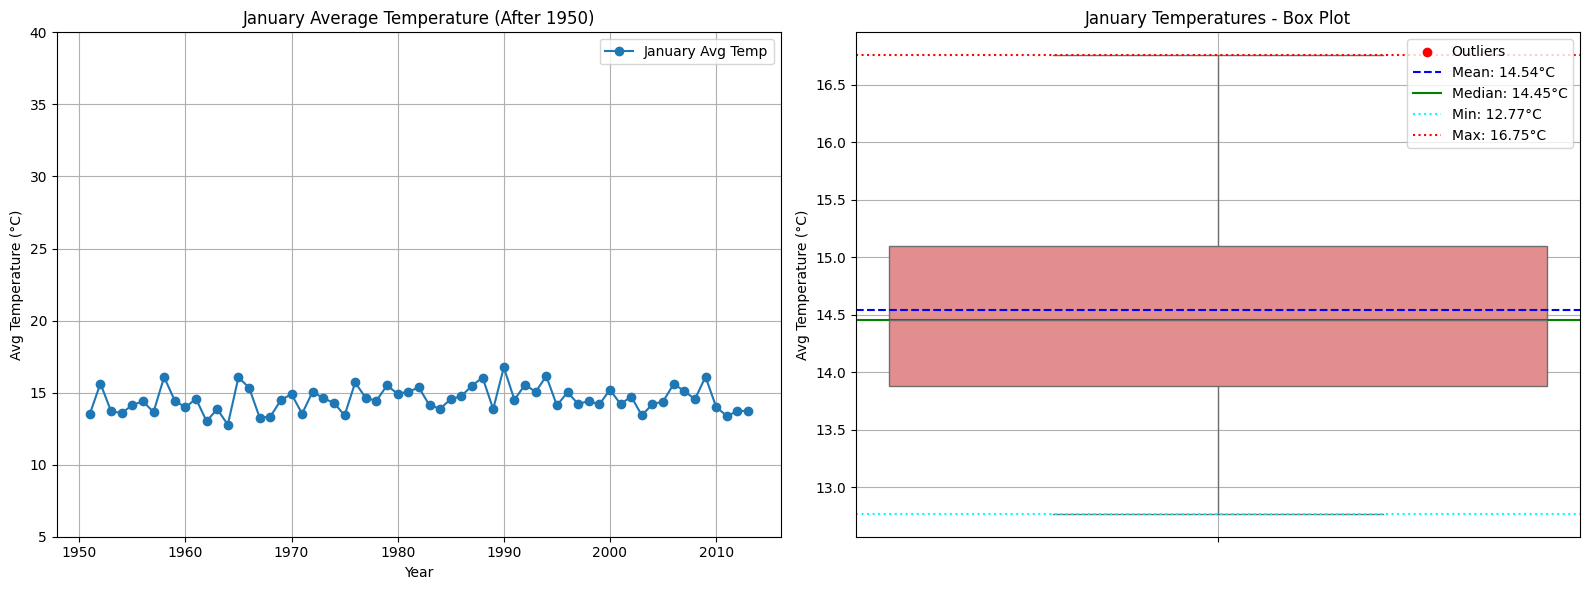


📊 January Temperature Stats (Post-1950):
Mean: 14.54°C | Median: 14.45°C
Std Dev: 0.88°C | Min: 12.77°C | Max: 16.75°C
Outliers:
Empty DataFrame
Columns: [Year, AverageTemperature]
Index: []


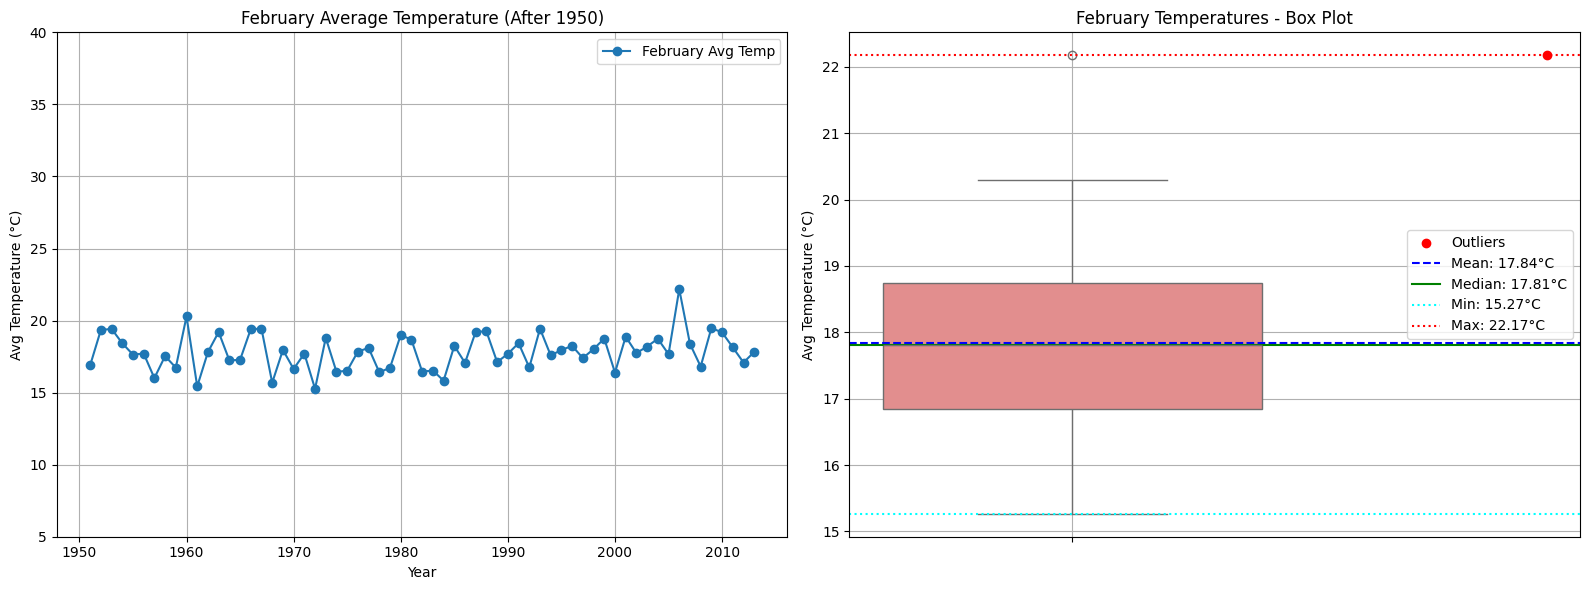


📊 February Temperature Stats (Post-1950):
Mean: 17.84°C | Median: 17.81°C
Std Dev: 1.27°C | Min: 15.27°C | Max: 22.17°C
Outliers:
                 Year  AverageTemperature
ObservationDate                          
2006-02-01       2006              22.174


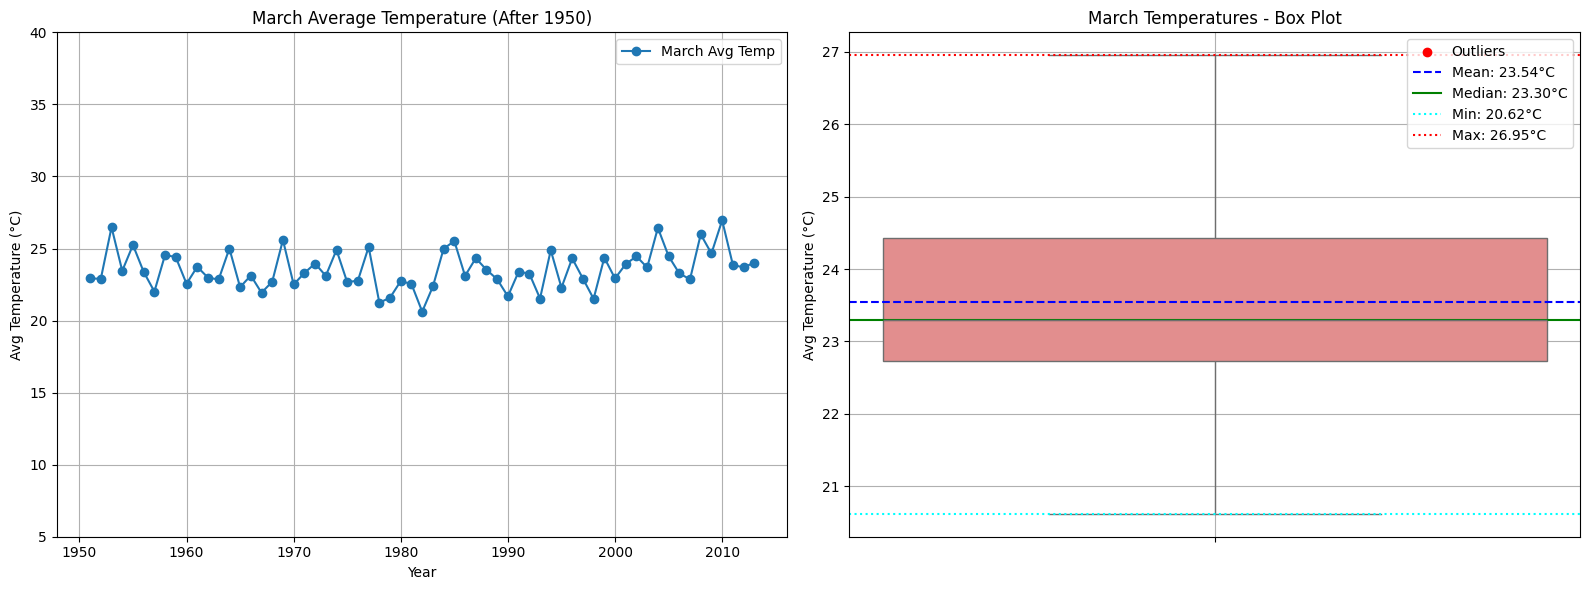


📊 March Temperature Stats (Post-1950):
Mean: 23.54°C | Median: 23.30°C
Std Dev: 1.34°C | Min: 20.62°C | Max: 26.95°C
Outliers:
Empty DataFrame
Columns: [Year, AverageTemperature]
Index: []


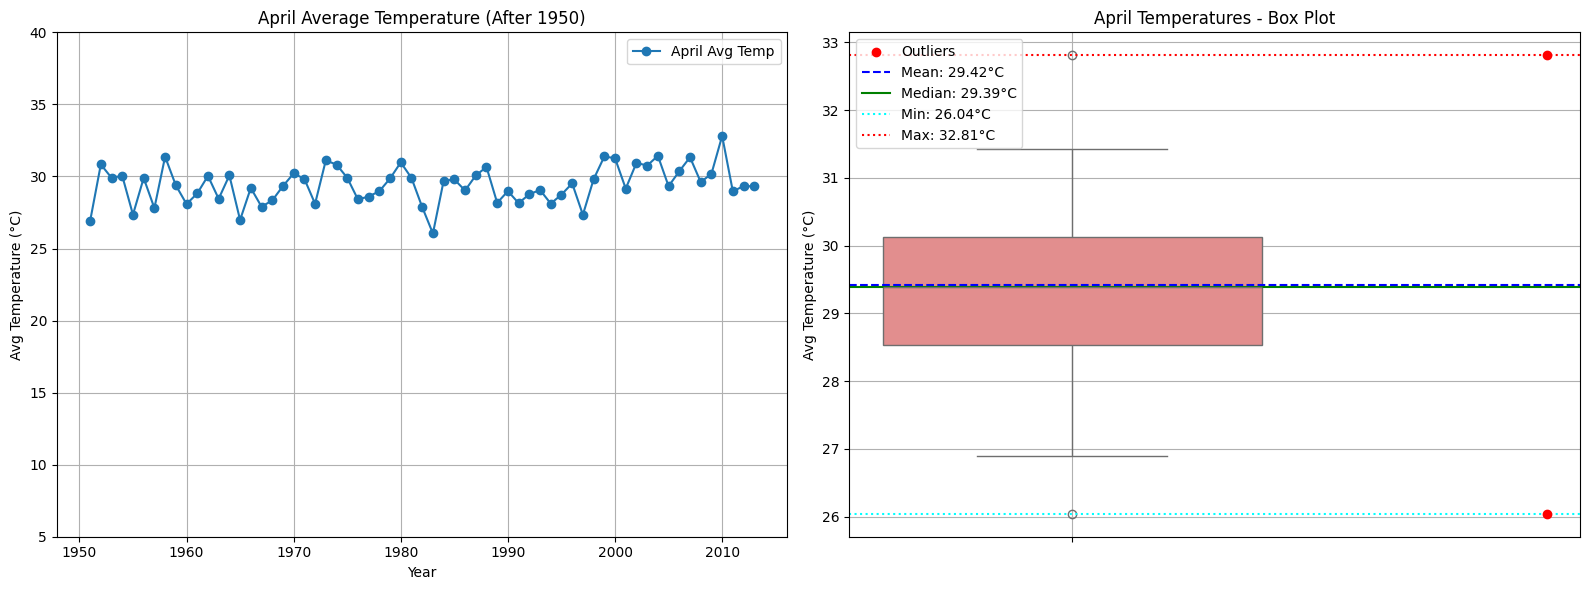


📊 April Temperature Stats (Post-1950):
Mean: 29.42°C | Median: 29.39°C
Std Dev: 1.30°C | Min: 26.04°C | Max: 32.81°C
Outliers:
                 Year  AverageTemperature
ObservationDate                          
1983-04-01       1983              26.043
2010-04-01       2010              32.809


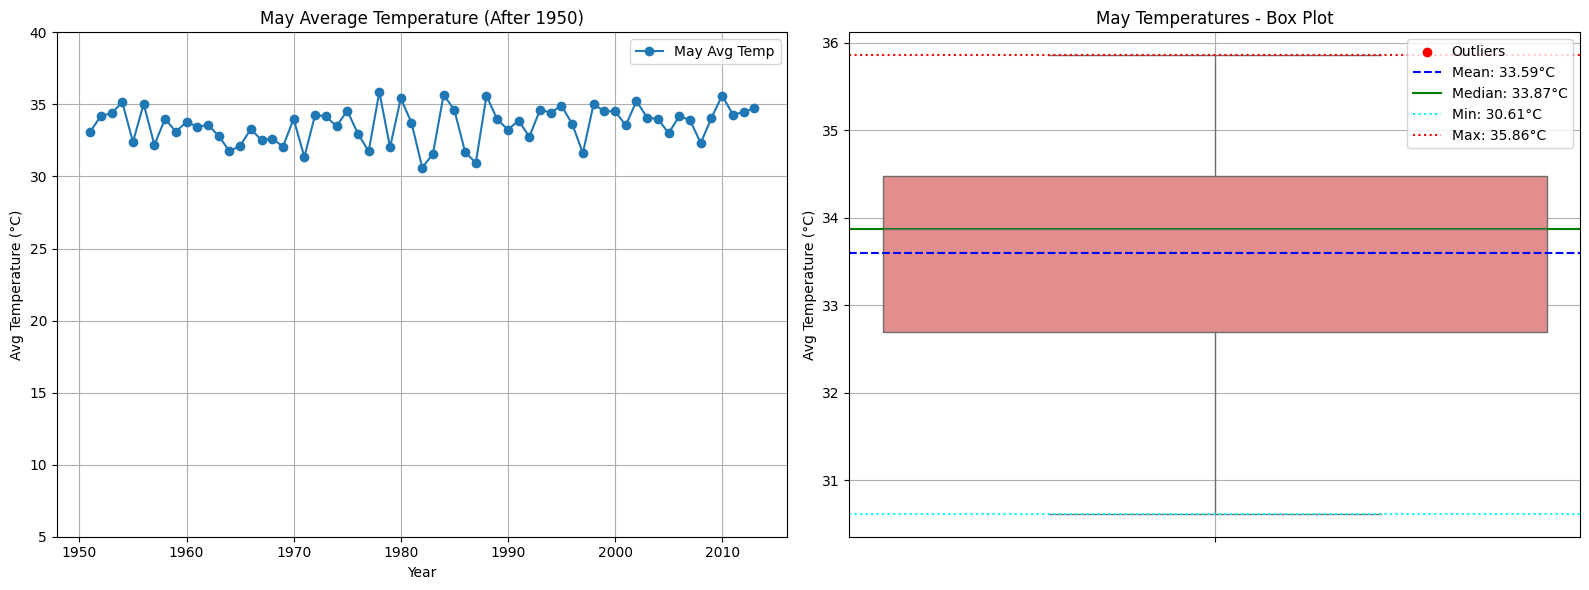


📊 May Temperature Stats (Post-1950):
Mean: 33.59°C | Median: 33.87°C
Std Dev: 1.27°C | Min: 30.61°C | Max: 35.86°C
Outliers:
Empty DataFrame
Columns: [Year, AverageTemperature]
Index: []


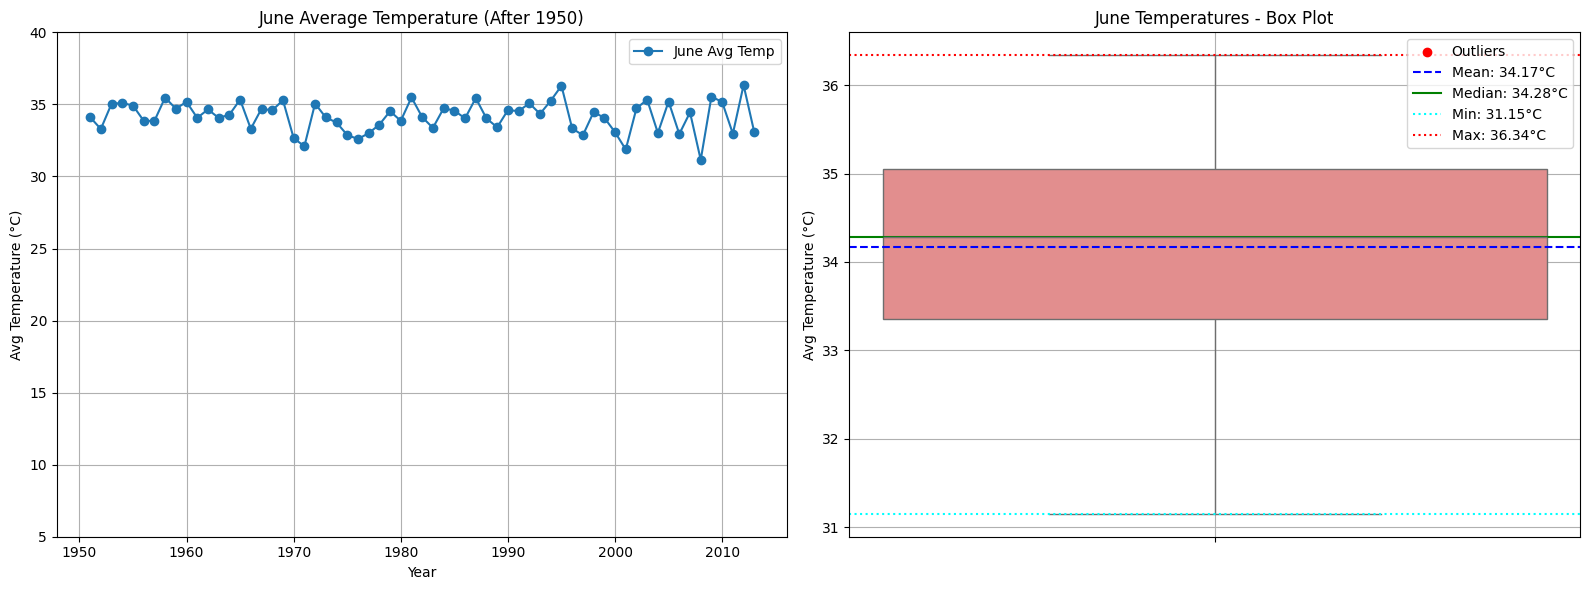


📊 June Temperature Stats (Post-1950):
Mean: 34.17°C | Median: 34.28°C
Std Dev: 1.06°C | Min: 31.15°C | Max: 36.34°C
Outliers:
Empty DataFrame
Columns: [Year, AverageTemperature]
Index: []


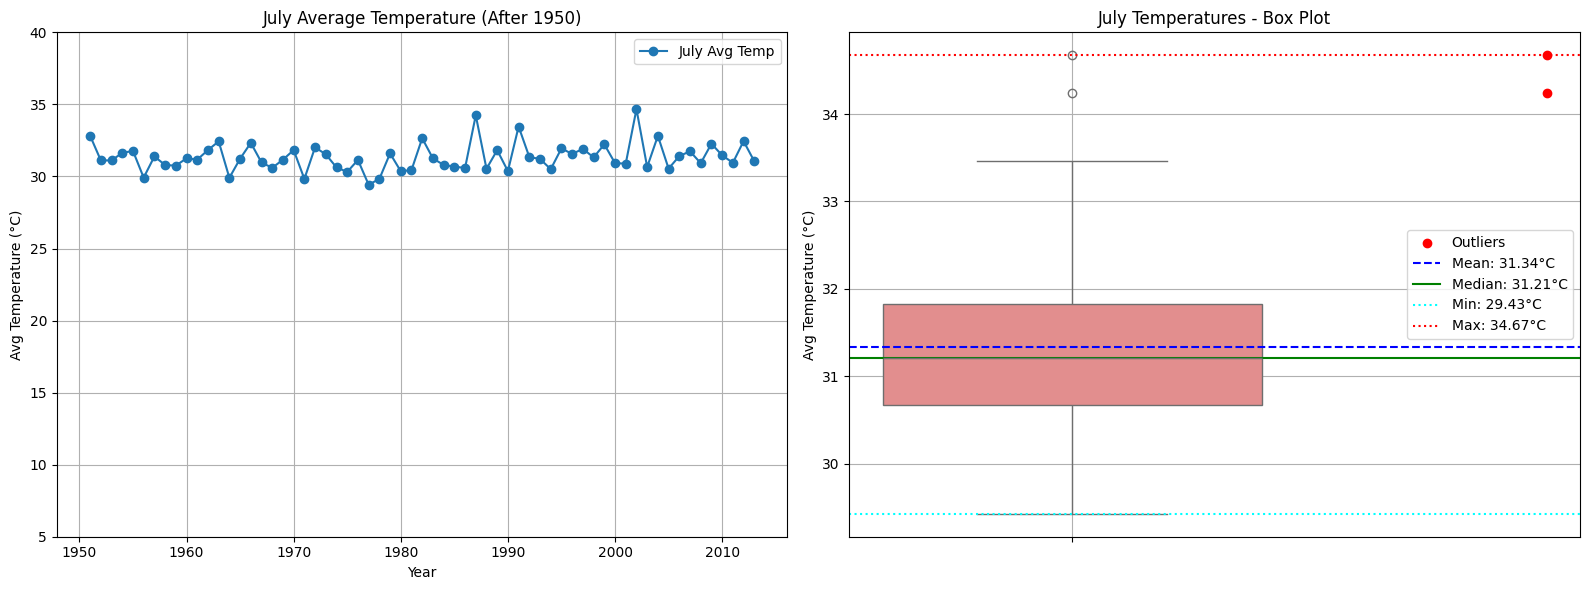


📊 July Temperature Stats (Post-1950):
Mean: 31.34°C | Median: 31.21°C
Std Dev: 0.99°C | Min: 29.43°C | Max: 34.67°C
Outliers:
                 Year  AverageTemperature
ObservationDate                          
1987-07-01       1987              34.241
2002-07-01       2002              34.672


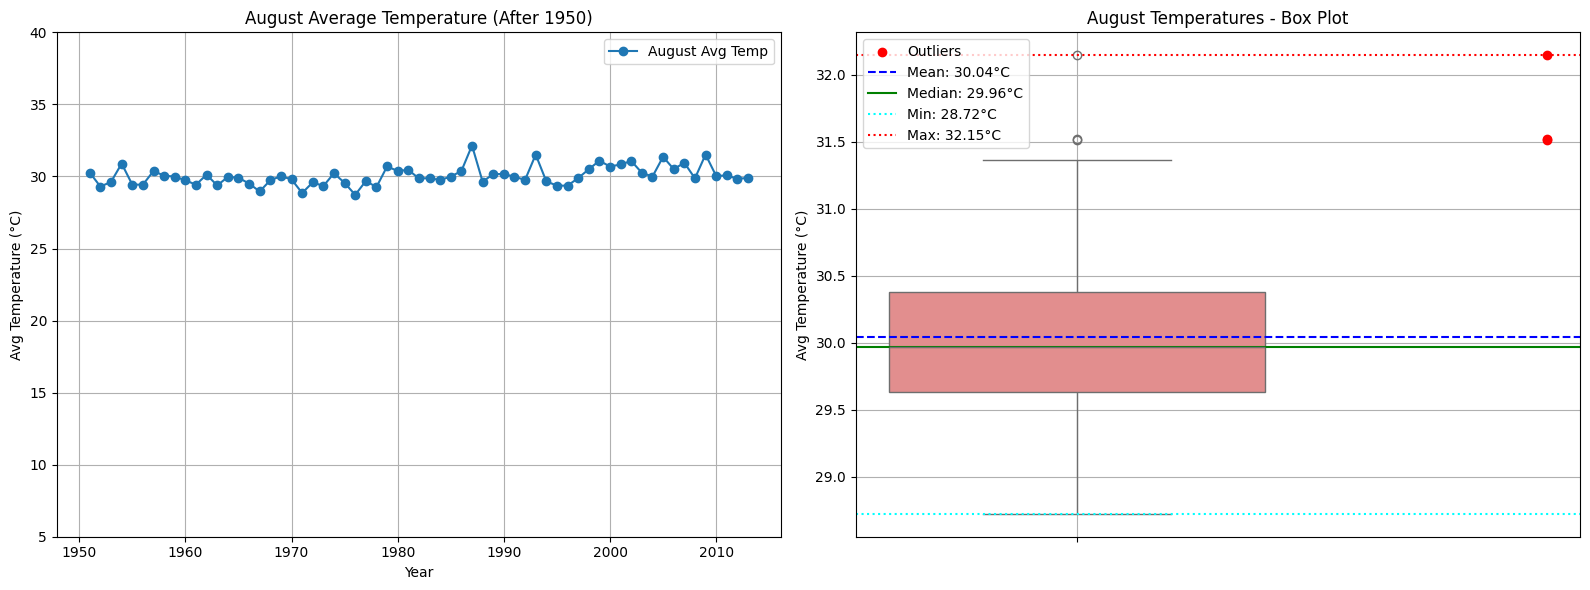


📊 August Temperature Stats (Post-1950):
Mean: 30.04°C | Median: 29.96°C
Std Dev: 0.66°C | Min: 28.72°C | Max: 32.15°C
Outliers:
                 Year  AverageTemperature
ObservationDate                          
1987-08-01       1987              32.147
1993-08-01       1993              31.514
2009-08-01       2009              31.519


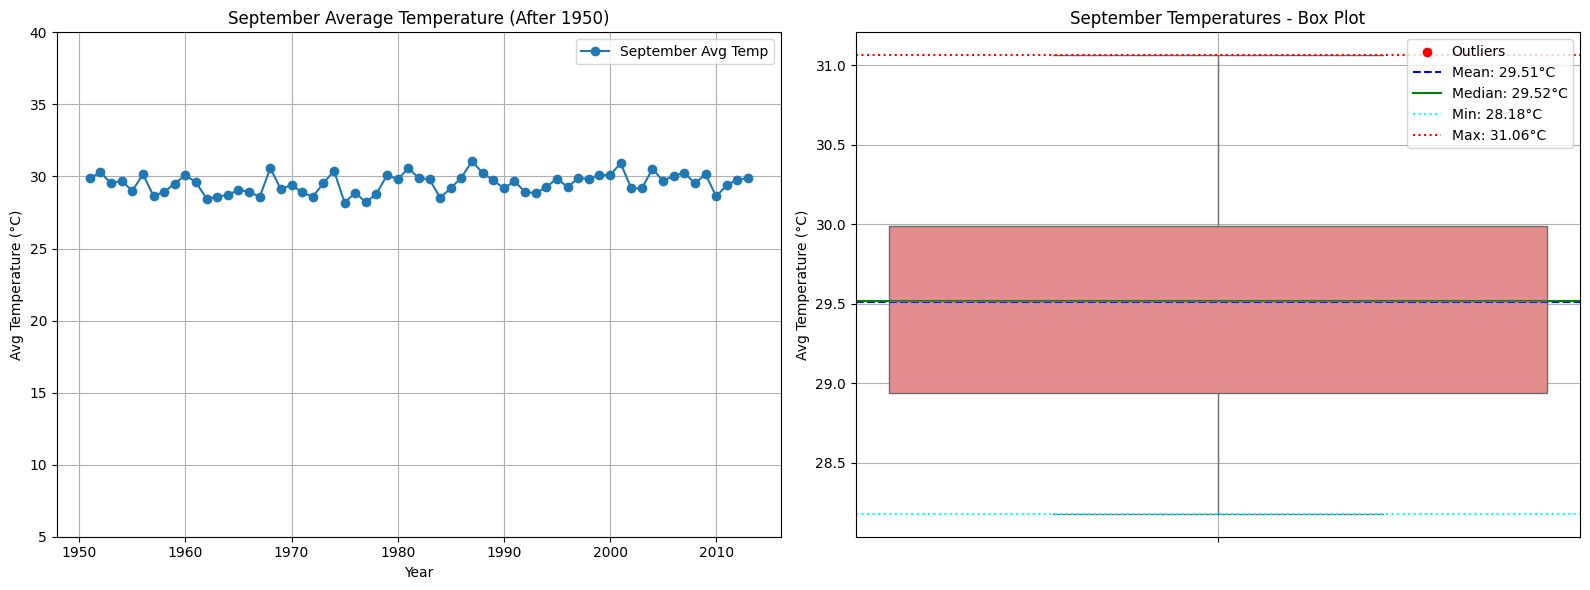


📊 September Temperature Stats (Post-1950):
Mean: 29.51°C | Median: 29.52°C
Std Dev: 0.68°C | Min: 28.18°C | Max: 31.06°C
Outliers:
Empty DataFrame
Columns: [Year, AverageTemperature]
Index: []


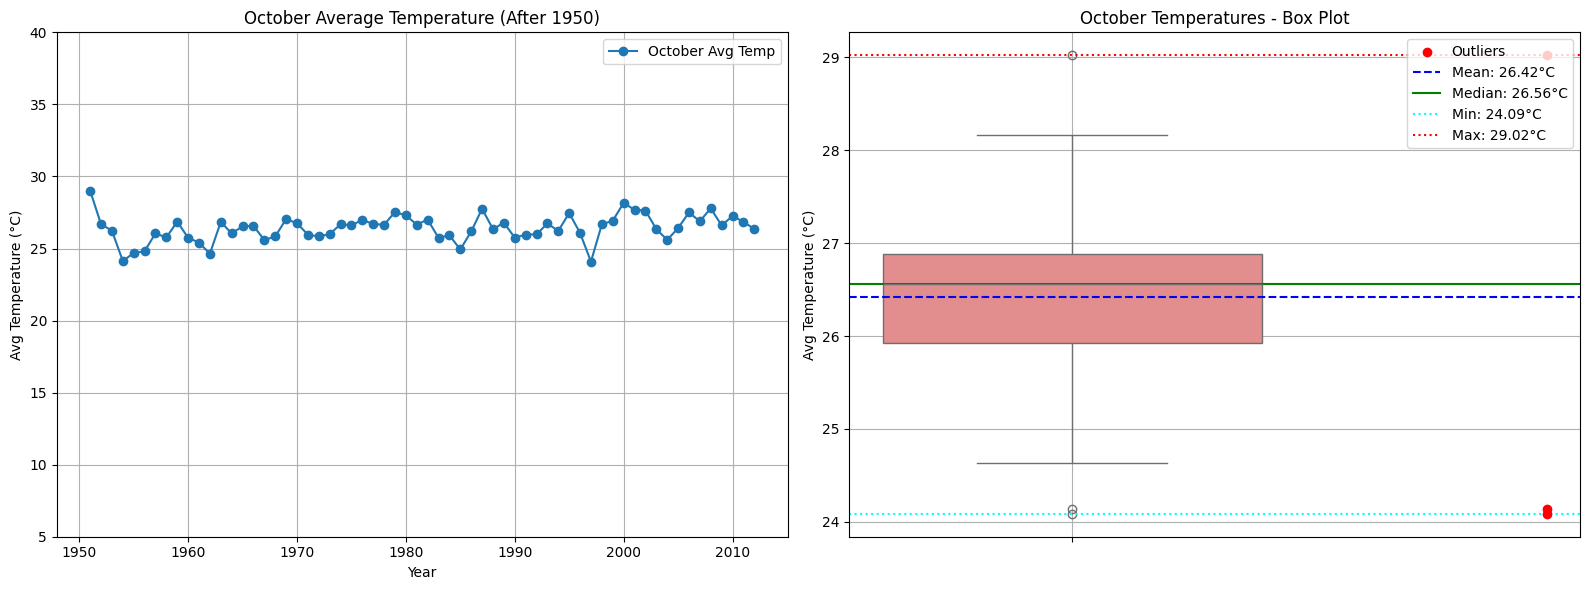


📊 October Temperature Stats (Post-1950):
Mean: 26.42°C | Median: 26.56°C
Std Dev: 0.93°C | Min: 24.09°C | Max: 29.02°C
Outliers:
                 Year  AverageTemperature
ObservationDate                          
1951-10-01       1951              29.021
1954-10-01       1954              24.140
1997-10-01       1997              24.087


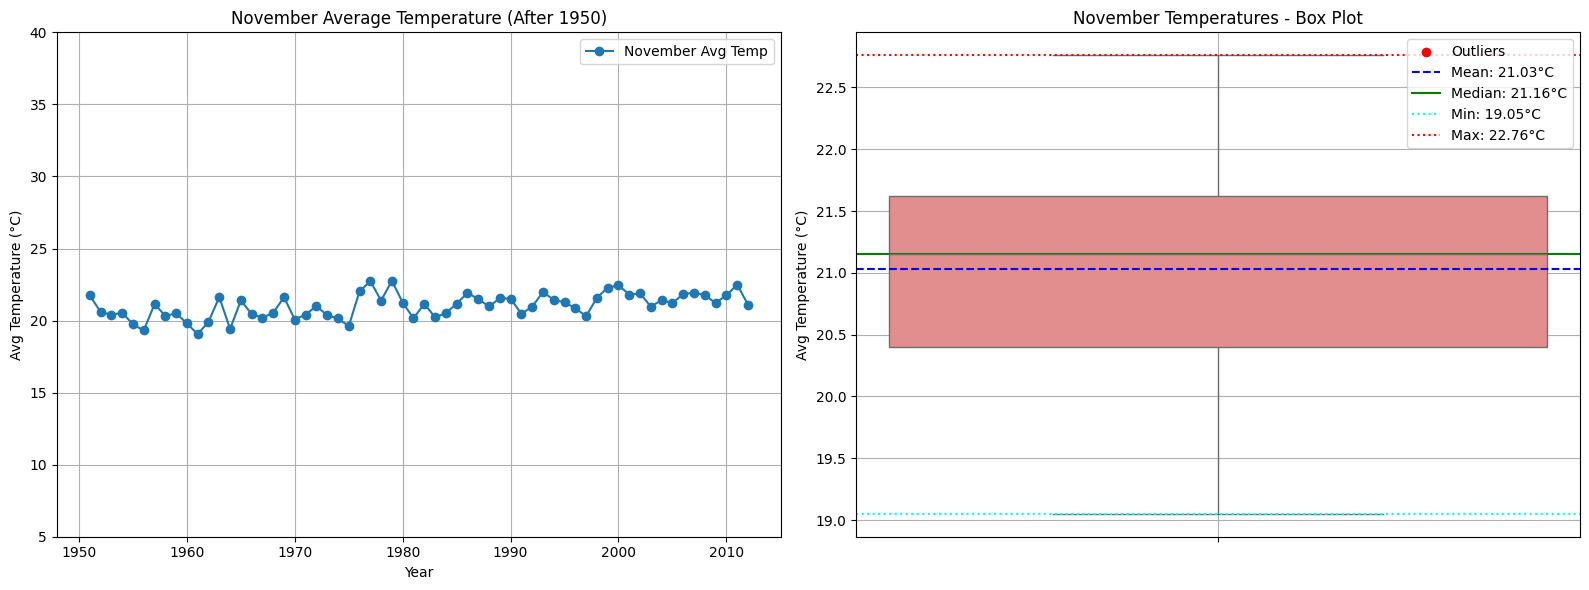


📊 November Temperature Stats (Post-1950):
Mean: 21.03°C | Median: 21.16°C
Std Dev: 0.86°C | Min: 19.05°C | Max: 22.76°C
Outliers:
Empty DataFrame
Columns: [Year, AverageTemperature]
Index: []


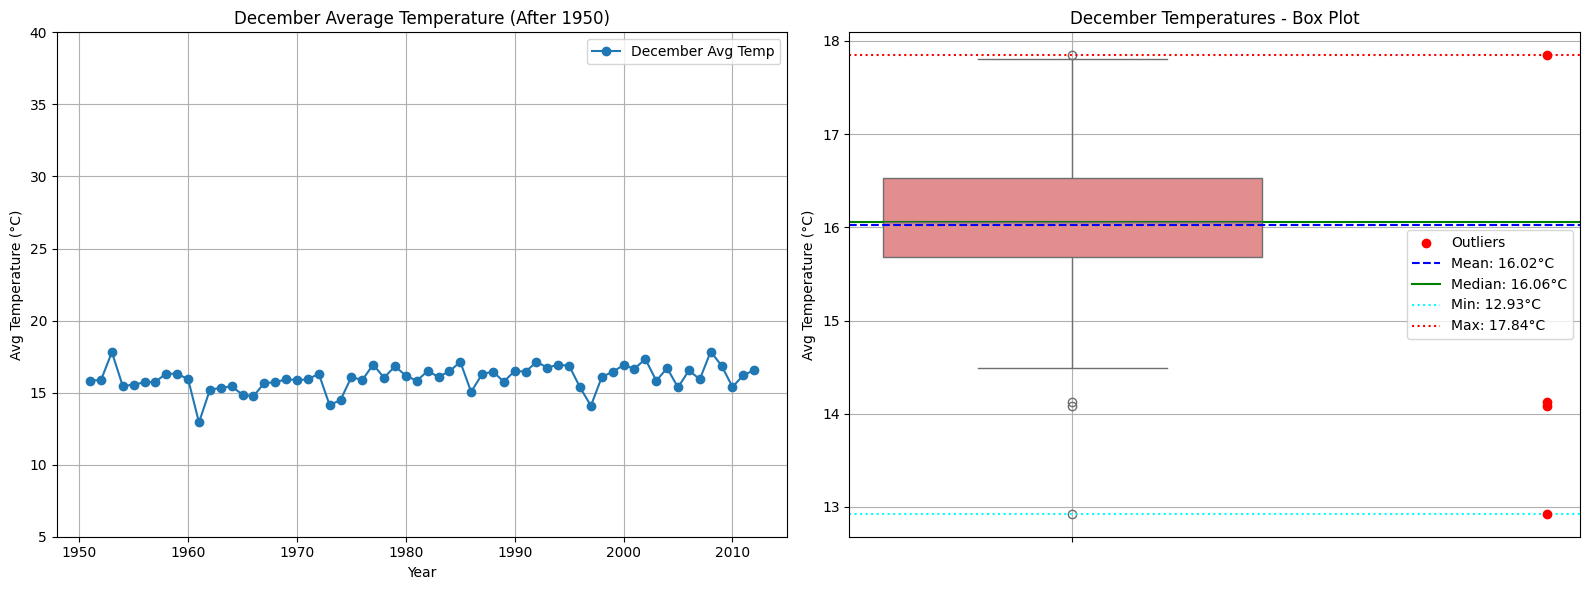


📊 December Temperature Stats (Post-1950):
Mean: 16.02°C | Median: 16.06°C
Std Dev: 0.87°C | Min: 12.93°C | Max: 17.84°C
Outliers:
                 Year  AverageTemperature
ObservationDate                          
1961-12-01       1961              12.927
1973-12-01       1973              14.130
1997-12-01       1997              14.086
2008-12-01       2008              17.845


In [61]:
for month in range(1, 13):
    month_name = pd.to_datetime(str(month), format='%m').strftime('%B')

    # Filter for specific month using index
    month_data = processed_data[processed_data.index.month == month]

    month_data = month_data[['AverageTemperature']].dropna()

    month_data = month_data[month_data.index.year > 1950]

    month_data['Year'] = month_data.index.year
    Q1 = month_data['AverageTemperature'].quantile(0.25)
    Q3 = month_data['AverageTemperature'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = month_data[(month_data['AverageTemperature'] < lower_bound) |
                          (month_data['AverageTemperature'] > upper_bound)]

    mean_temp = month_data['AverageTemperature'].mean()
    median_temp = month_data['AverageTemperature'].median()
    std_temp = month_data['AverageTemperature'].std()
    min_temp = month_data['AverageTemperature'].min()
    max_temp = month_data['AverageTemperature'].max()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Line Plot
    axes[0].plot(month_data['Year'], month_data['AverageTemperature'],
                 marker='o', linestyle='-', label=f"{month_name} Avg Temp")
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("Avg Temperature (°C)")
    axes[0].set_ylim([5, 40])
    axes[0].set_title(f"{month_name} Average Temperature (After 1950)")
    axes[0].legend()
    axes[0].grid(True)

    # Box Plot
    sns.boxplot(y=month_data['AverageTemperature'], ax=axes[1], color="lightcoral")

    axes[1].scatter([1] * len(outliers), outliers['AverageTemperature'],
                    color='red', label="Outliers", zorder=3)

    axes[1].axhline(mean_temp, color='blue', linestyle='--', label=f"Mean: {mean_temp:.2f}°C")
    axes[1].axhline(median_temp, color='green', linestyle='-', label=f"Median: {median_temp:.2f}°C")
    axes[1].axhline(min_temp, color='cyan', linestyle=':', label=f"Min: {min_temp:.2f}°C")
    axes[1].axhline(max_temp, color='red', linestyle=':', label=f"Max: {max_temp:.2f}°C")

    axes[1].set_ylabel("Avg Temperature (°C)")
    axes[1].set_title(f"{month_name} Temperatures - Box Plot")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\n {month_name} Temperature Stats (Post-1950):")
    print(f"Mean: {mean_temp:.2f}°C | Median: {median_temp:.2f}°C")
    print(f"Std Dev: {std_temp:.2f}°C | Min: {min_temp:.2f}°C | Max: {max_temp:.2f}°C")
    print("Outliers:")
    print(outliers[['Year', 'AverageTemperature']])

## **Checking whether the data was normally distributed before and after removal of outlier and doing transformations if required**

In [62]:

processed_data.index = pd.to_datetime(processed_data.index)

for month in range(1, 13):
    month_name = pd.to_datetime(str(month), format='%m').strftime('%B')

    month_data = processed_data[processed_data.index.month == month]
    month_data = month_data[['AverageTemperature']].dropna()
    month_data = month_data[month_data.index.year > 1950]

    raw_temps = month_data['AverageTemperature']

    stat_before, p_before = stats.shapiro(raw_temps)
    result_before = "Normal distribution ✅" if p_before > 0.05 else "Not normal ❌"
    print(f" {month_name} (Before Outliers): {result_before} (p = {p_before:.4f})")

    Q1 = raw_temps.quantile(0.25)
    Q3 = raw_temps.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    clean_temps = raw_temps[(raw_temps >= lower_bound) & (raw_temps <= upper_bound)]

    stat_after, p_after = stats.shapiro(clean_temps)
    result_after = "Normal distribution ✅" if p_after > 0.05 else "Not normal ❌"
    print(f" {month_name} (After Outliers): {result_after} (p = {p_after:.4f})\n")

 January (Before Outliers): Normal distribution ✅ (p = 0.4485)
 January (After Outliers): Normal distribution ✅ (p = 0.4485)

 February (Before Outliers): Normal distribution ✅ (p = 0.2033)
 February (After Outliers): Normal distribution ✅ (p = 0.4448)

 March (Before Outliers): Normal distribution ✅ (p = 0.4717)
 March (After Outliers): Normal distribution ✅ (p = 0.4717)

 April (Before Outliers): Normal distribution ✅ (p = 0.9384)
 April (After Outliers): Normal distribution ✅ (p = 0.2949)

 May (Before Outliers): Normal distribution ✅ (p = 0.1886)
 May (After Outliers): Normal distribution ✅ (p = 0.1886)

 June (Before Outliers): Normal distribution ✅ (p = 0.2845)
 June (After Outliers): Normal distribution ✅ (p = 0.2845)

 July (Before Outliers): Not normal ❌ (p = 0.0062)
 July (After Outliers): Normal distribution ✅ (p = 0.8682)

 August (Before Outliers): Not normal ❌ (p = 0.0239)
 August (After Outliers): Normal distribution ✅ (p = 0.5690)

 September (Before Outliers): Normal d

# **TIME SERIES DECOMPOSITION**

## **Plotting rolling statistics including mean, standard deviation and moving average**

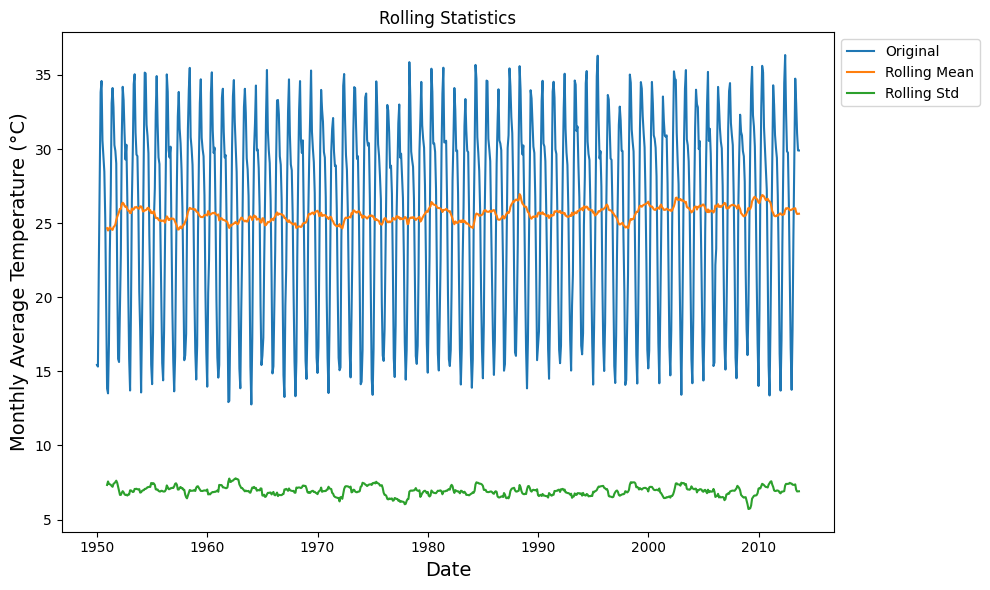

In [66]:

rolling_mean = processed_data['AverageTemperature'].rolling(window=12).mean()
rolling_std = processed_data['AverageTemperature'].rolling(window=12).std()

plt.figure(figsize=(10, 6))

plt.plot(processed_data['AverageTemperature'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly Average Temperature (°C)', fontsize=14)
plt.title("Rolling Statistics")


plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


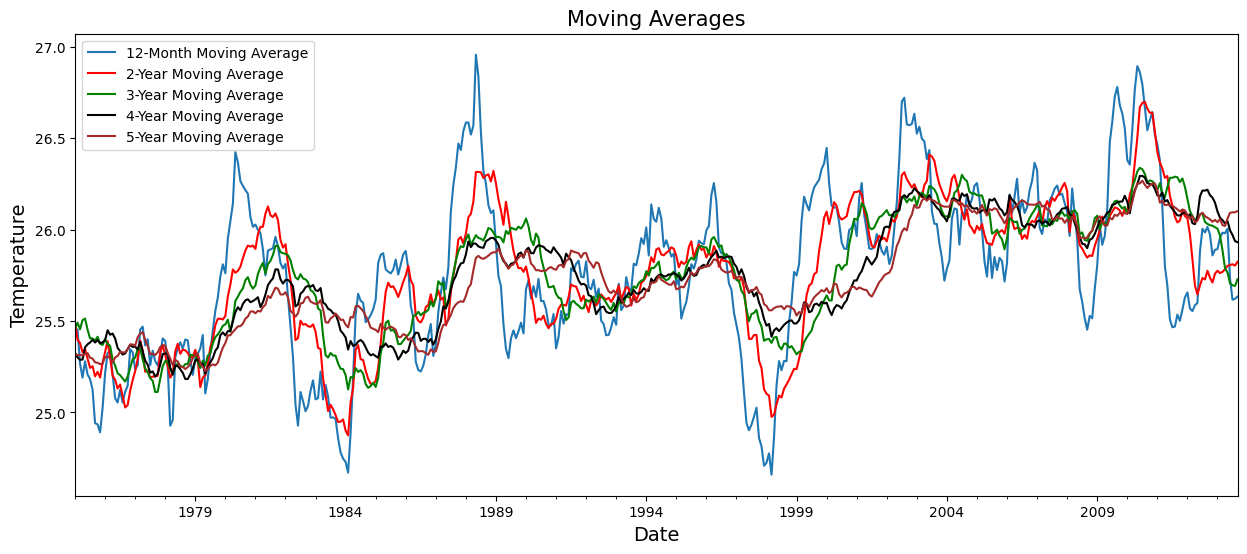

In [67]:
annual_avg = processed_data['AverageTemperature'].rolling(window = 12).mean()

bi_annual_avg = processed_data['AverageTemperature'].rolling(window = 24).mean()
tri_annual_avg = processed_data['AverageTemperature'].rolling(window = 36).mean()

quad_annual_avg = processed_data['AverageTemperature'].rolling(window = 48).mean()
quin_annual_avg = processed_data['AverageTemperature'].rolling(window = 60).mean()
avg_plot = annual_avg['1975':].plot(figsize = (15, 6), label = '12-Month Moving Average')

bi_annual_avg['1975':].plot(ax = avg_plot, color = 'red', label = '2-Year Moving Average')
tri_annual_avg['1975':].plot(ax = avg_plot, color = 'green', label = '3-Year Moving Average')

quad_annual_avg['1975':].plot(ax = avg_plot, color = 'black', label = '4-Year Moving Average')
quin_annual_avg['1975':].plot(ax = avg_plot, color = 'brown', label = '5-Year Moving Average')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Temperature', fontsize = 14)
plt.title('Moving Averages', fontsize = 15)
plt.legend()
plt.show()

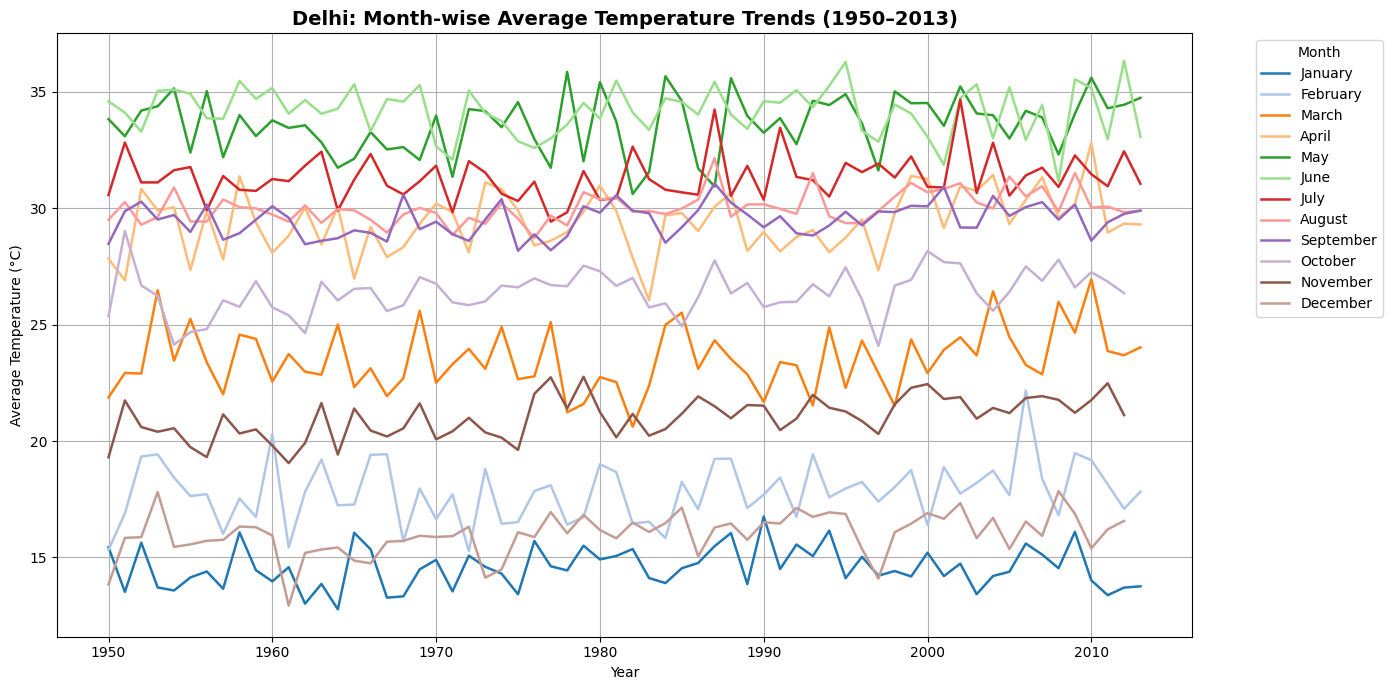

In [68]:

processed_data = processed_data.dropna(subset=["AverageTemperature"])

processed_data["Year"] = processed_data.index.year
processed_data["Month"] = processed_data.index.month

pivot_processed_data = processed_data.pivot_table(index="Year", columns="Month", values="AverageTemperature")


colors = plt.get_cmap('tab20').colors


month_names = [calendar.month_name[month] for month in range(1, 13)]

plt.figure(figsize=(14, 7))

for month in range(1, 13):
    plt.plot(
        pivot_processed_data.index,
        pivot_processed_data[month],
        label=month_names[month - 1],
        color=colors[month - 1],
        linewidth=1.8
    )

plt.title("Delhi: Month-wise Average Temperature Trends (1950–2013)", fontsize=14, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


## **PLotting the autocorrelation and partial autorrelation of the original data**

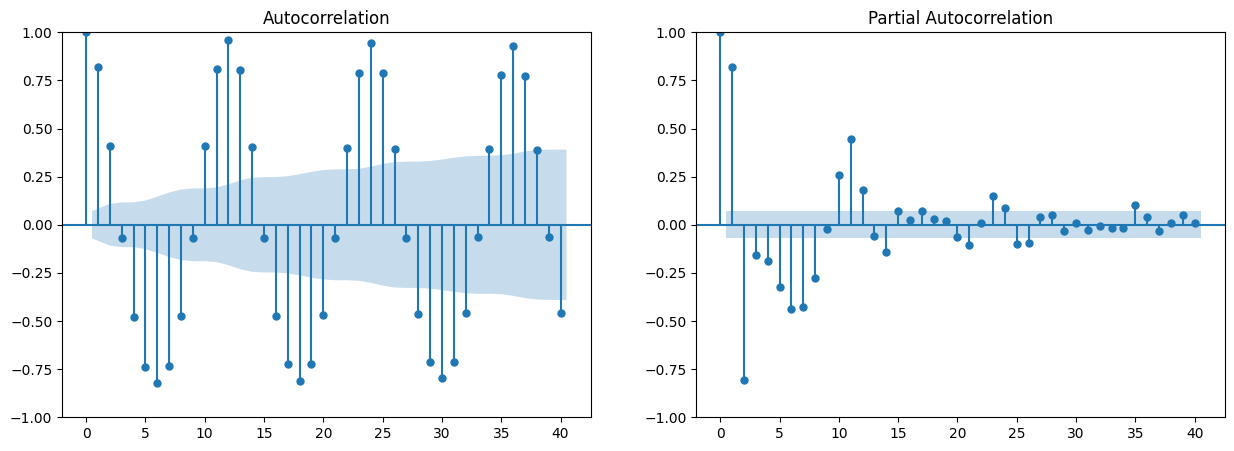

In [74]:
drop_columns = ['Year','Month']
processed_data.drop(drop_columns, axis = 1, inplace = True)
fig, axis_set = plt.subplots(1, 2, figsize=(15, 5))
sm.graphics.tsa.plot_acf(processed_data.dropna(), lags=40, ax=axis_set[0])
sm.graphics.tsa.plot_pacf(processed_data.dropna(), lags=40, ax=axis_set[1])
plt.show()

## **Performing the ADF and KPSS statistics test to check for stationarity**

In [75]:
def adf_test(series):
    """Perform Augmented Dickey-Fuller Test"""
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])

    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")
adf_test(processed_data)

ADF Statistic: -6.027314764597888
p-value: 1.44556050576166e-07
Critical Values: {'1%': np.float64(-3.4391698996357687), '5%': np.float64(-2.8654325580580204), '10%': np.float64(-2.568842816582842)}
The series is stationary.


In [76]:
from statsmodels.tsa.stattools import kpss
def perform_kpss_test(time_series_data):
    print ('Results of KPSS Test:')
    kpsstest_result = kpss(time_series_data, regression = 'c', nlags = 'legacy')
    kpss_output_result = pd.Series(kpsstest_result[0:3], index = ['Test Statistic','p-value','No. of Lags Used'])
    for key,value in kpsstest_result[3].items():
        kpss_output_result['Critical Value (%s)'%key] = value
    print (kpss_output_result)
perform_kpss_test(processed_data)

Results of KPSS Test:
Test Statistic            0.356183
p-value                   0.096042
No. of Lags Used         20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


## **Additive decomposition of time series**

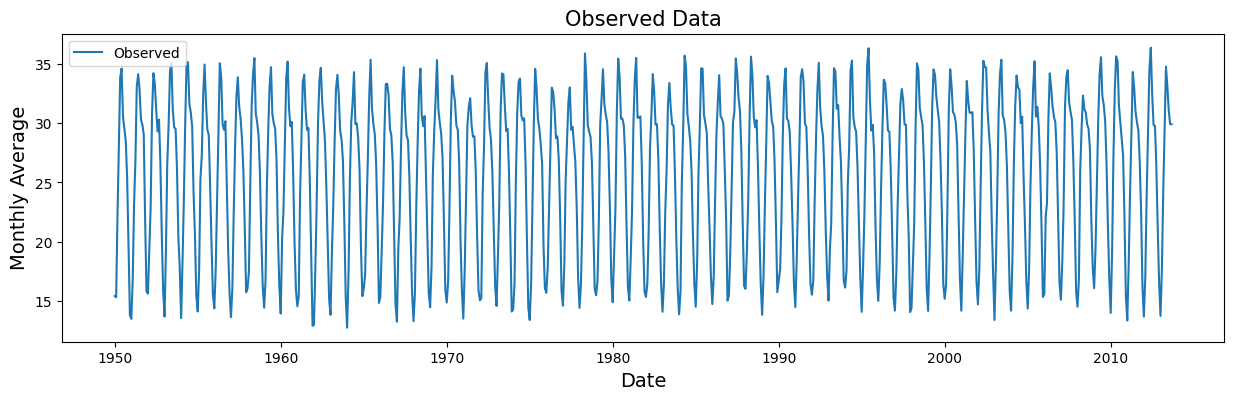

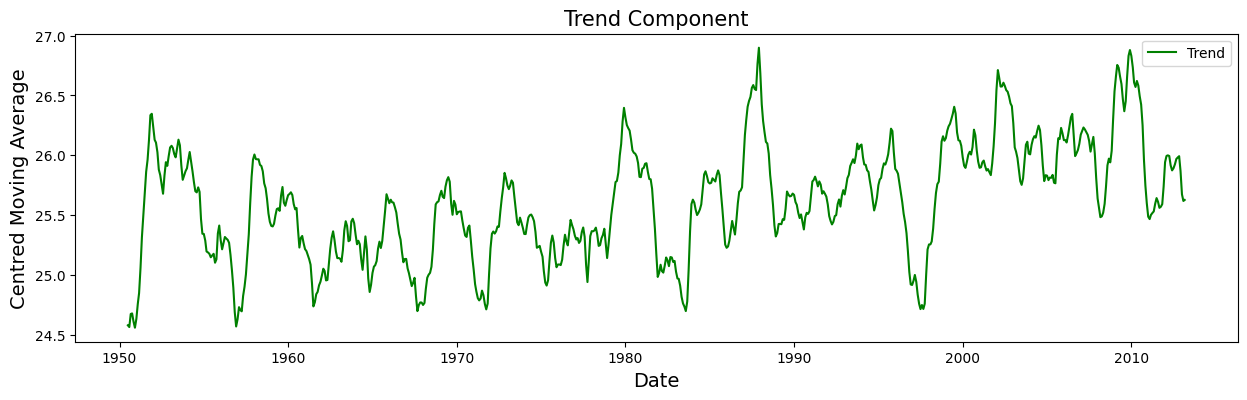

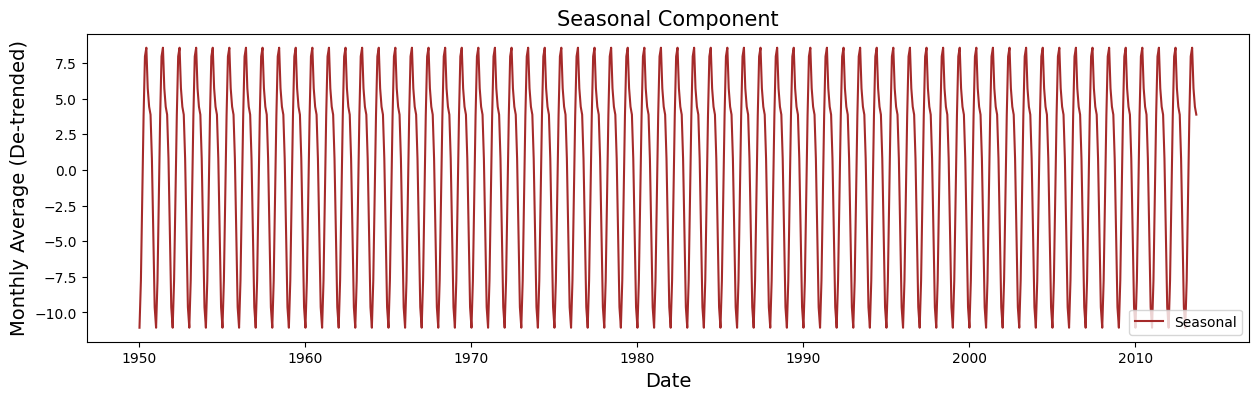

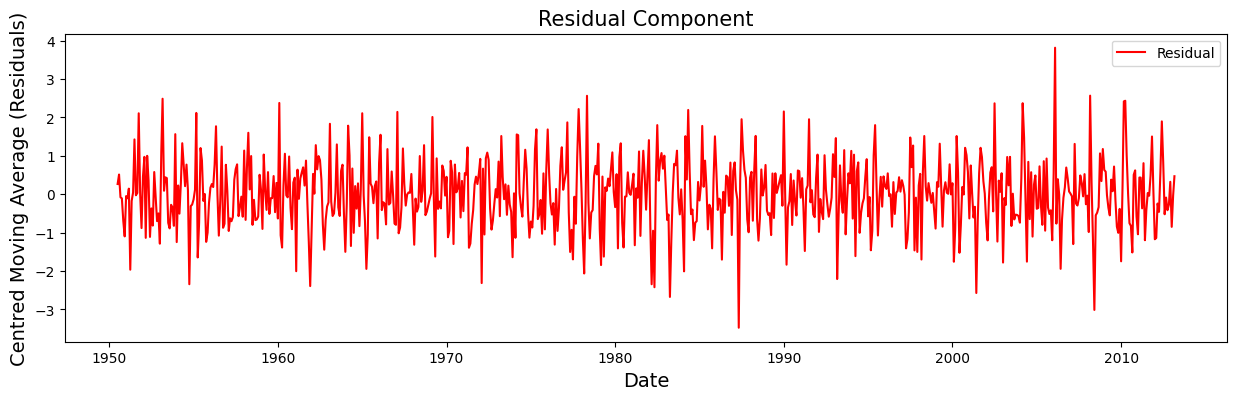

In [77]:
time_series_decomposition = seasonal_decompose(processed_data, model='additive', period=12)
observed_values = time_series_decomposition.observed
plt.figure(figsize = (15, 4))
plt.plot(observed_values, label = 'Observed')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Monthly Average', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Observed Data", fontsize = 15)
plt.show()
trend_component = time_series_decomposition.trend
plt.figure(figsize = (15, 4))
plt.plot(trend_component, label = 'Trend', color = 'green')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Centred Moving Average', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Trend Component", fontsize = 15)
plt.show()
seasonal_component = time_series_decomposition.seasonal
plt.figure(figsize = (15, 4))
plt.plot(seasonal_component, label = 'Seasonal', color = 'brown')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Monthly Average (De-trended)', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Seasonal Component", fontsize = 15)
plt.show()
residual_component = time_series_decomposition.resid
plt.figure(figsize = (15, 4))
plt.plot(residual_component, label = 'Residual', color = 'red')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Centred Moving Average (Residuals)', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Residual Component", fontsize = 15)
plt.show()

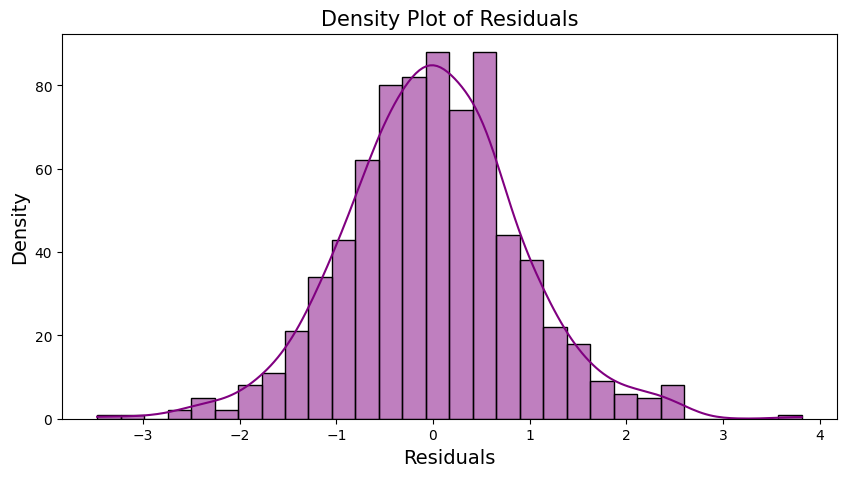

<Figure size 700x700 with 0 Axes>

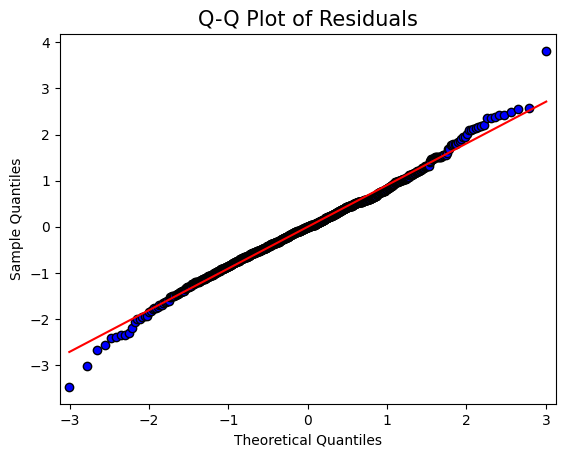

In [78]:
plt.figure(figsize=(10, 5))
sns.histplot(residual_component.dropna(), kde=True, bins=30, color='purple')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Density Plot of Residuals', fontsize=15)
plt.show()
plt.figure(figsize=(7, 7))
sm.qqplot(residual_component.dropna(), line='s', markerfacecolor='blue', markeredgecolor='black')
plt.title('Q-Q Plot of Residuals', fontsize=15)
plt.show()

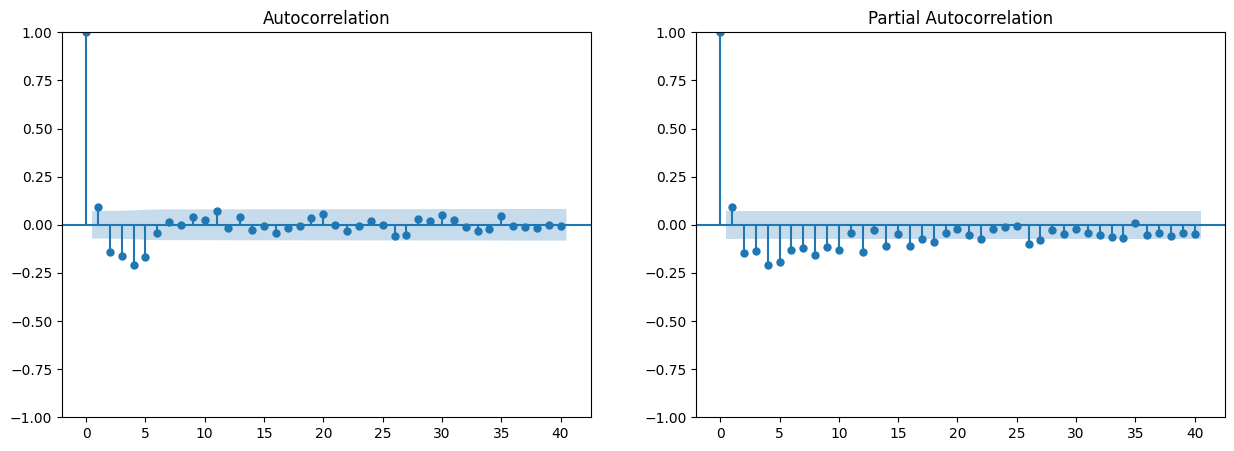

In [79]:
fig, residuals_axis_set = plt.subplots(1, 2, figsize=(15, 5))
sm.graphics.tsa.plot_acf(residual_component.dropna(), lags=40, ax=residuals_axis_set[0])
sm.graphics.tsa.plot_pacf(residual_component.dropna(), lags=40, ax=residuals_axis_set[1])
plt.show()

## **Multiplicative decomposition of time series**

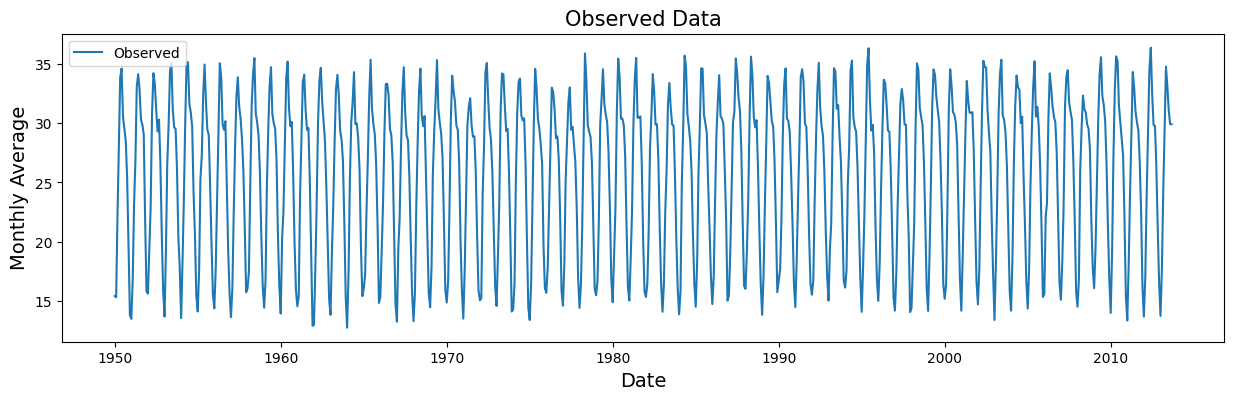

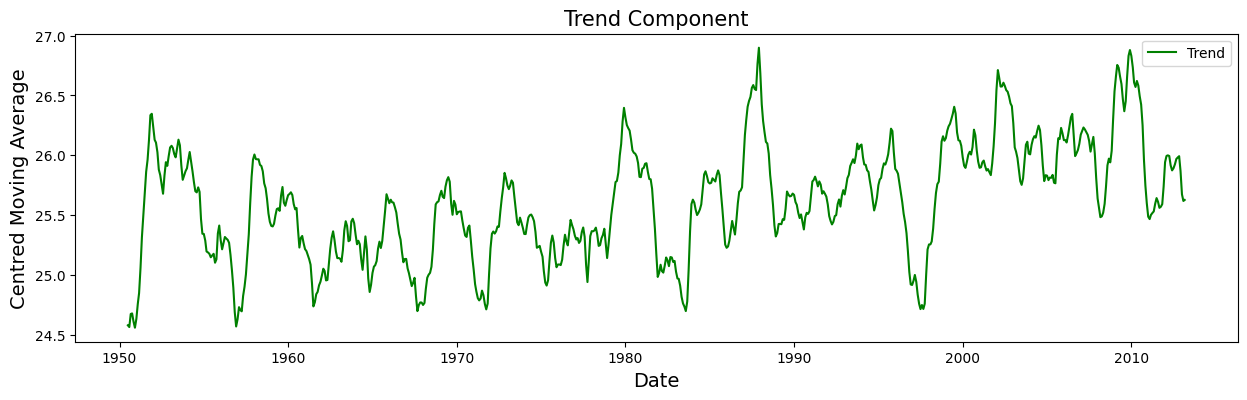

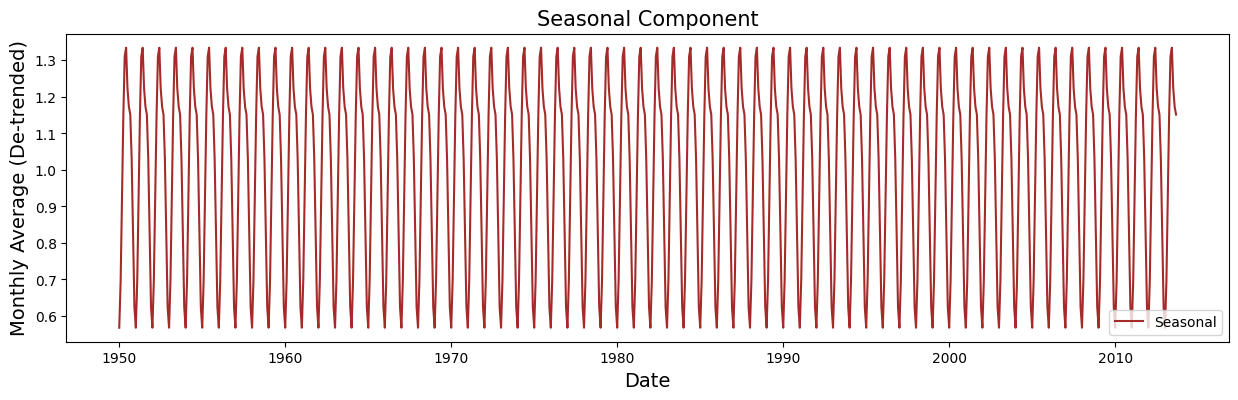

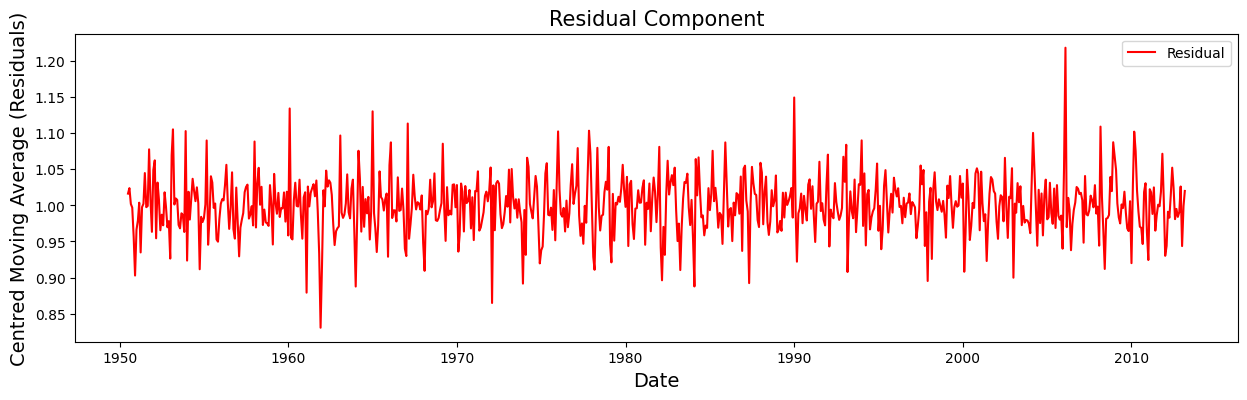

In [80]:
time_series_decomposition_multi = seasonal_decompose(processed_data, model='multiplicative', period=12)
observed_values_multi = time_series_decomposition_multi.observed
plt.figure(figsize = (15, 4))
plt.plot(observed_values_multi, label = 'Observed')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Monthly Average', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Observed Data", fontsize = 15)
plt.show()
trend_component_multi = time_series_decomposition_multi.trend
plt.figure(figsize = (15, 4))
plt.plot(trend_component_multi, label = 'Trend', color = 'green')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Centred Moving Average', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Trend Component", fontsize = 15)
plt.show()
seasonal_component_multi = time_series_decomposition_multi.seasonal
plt.figure(figsize = (15, 4))
plt.plot(seasonal_component_multi, label = 'Seasonal', color = 'brown')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Monthly Average (De-trended)', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Seasonal Component", fontsize = 15)
plt.show()
residual_component_multi = time_series_decomposition_multi.resid
plt.figure(figsize = (15, 4))
plt.plot(residual_component_multi, label = 'Residual', color = 'red')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Centred Moving Average (Residuals)', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Residual Component", fontsize = 15)
plt.show()

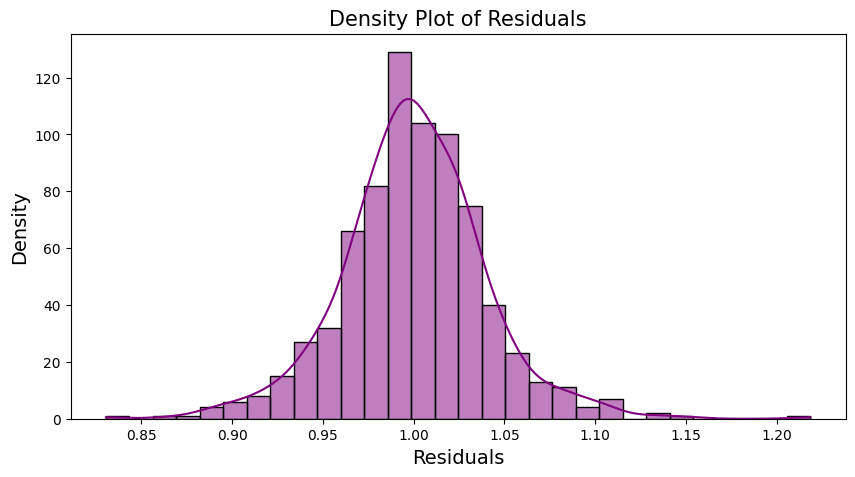

<Figure size 700x700 with 0 Axes>

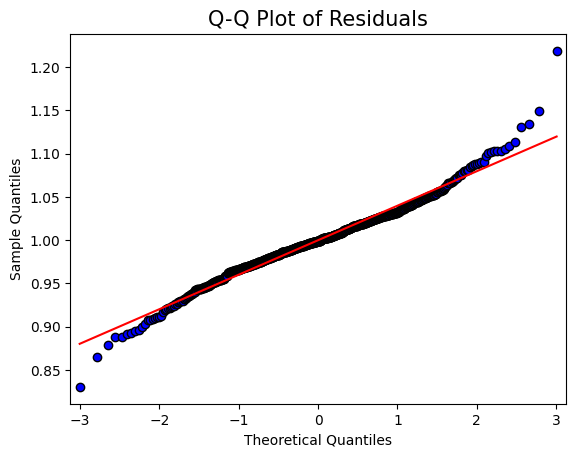

In [81]:
plt.figure(figsize=(10, 5))
sns.histplot(residual_component_multi.dropna(), kde=True, bins=30, color='purple')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Density Plot of Residuals', fontsize=15)
plt.show()
plt.figure(figsize=(7, 7))
sm.qqplot(residual_component_multi.dropna(), line='s', markerfacecolor='blue', markeredgecolor='black')
plt.title('Q-Q Plot of Residuals', fontsize=15)
plt.show()

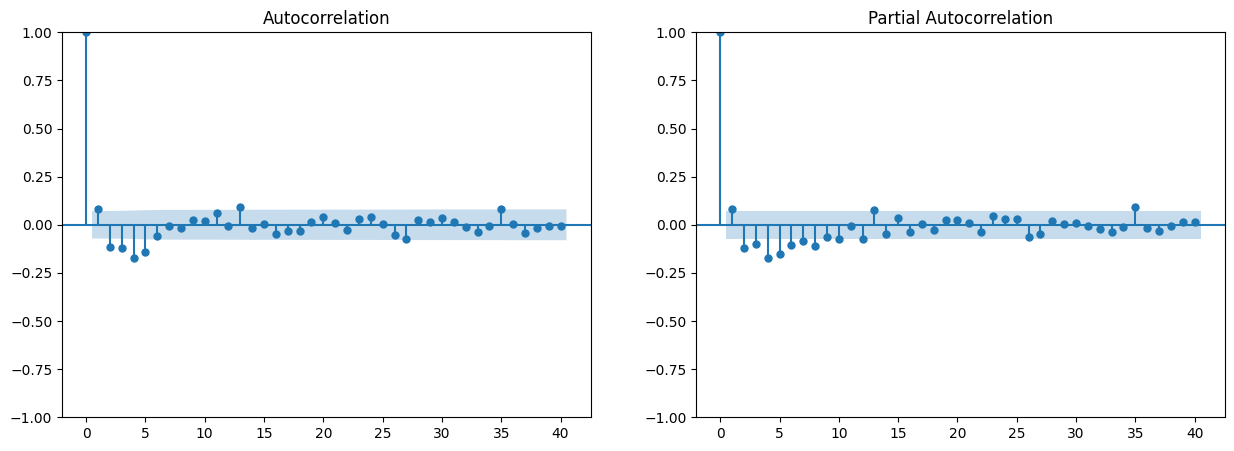

In [82]:
fig, residuals_axis_set_multi = plt.subplots(1, 2, figsize=(15, 5))
sm.graphics.tsa.plot_acf(residual_component_multi.dropna(), lags=40, ax=residuals_axis_set_multi[0])
sm.graphics.tsa.plot_pacf(residual_component_multi.dropna(), lags=40, ax=residuals_axis_set_multi[1])
plt.show()

# **SEASONAL DECOMPOSITION**

## **Taking the seasonal diiference with lag 12**

In [84]:
processed_data["Seasonal_Diff"] = processed_data["AverageTemperature"].diff(periods=12)  # Assuming s = 12 for monthly data
processed_data.dropna(inplace=True)

def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

adf_test(processed_data["Seasonal_Diff"])


ADF Statistic: -9.803915392149587
p-value: 5.8950089757877e-17
The series is stationary.


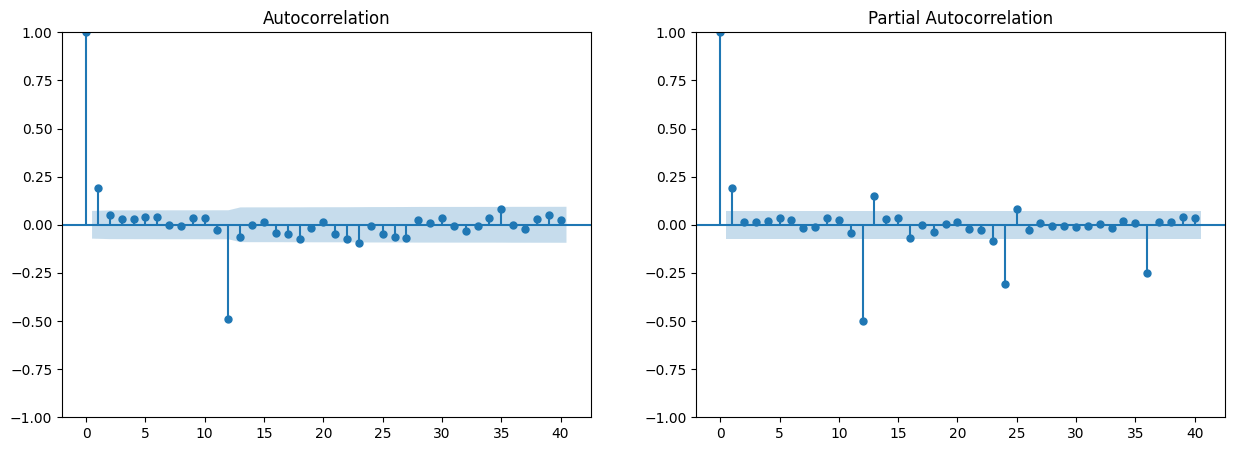

In [85]:
fig, seasonal_diff = plt.subplots(1, 2, figsize=(15, 5))
sm.graphics.tsa.plot_acf(processed_data["Seasonal_Diff"].dropna(), lags=40, ax=seasonal_diff[0])
sm.graphics.tsa.plot_pacf(processed_data["Seasonal_Diff"].dropna(), lags=40, ax=seasonal_diff[1])
plt.show()

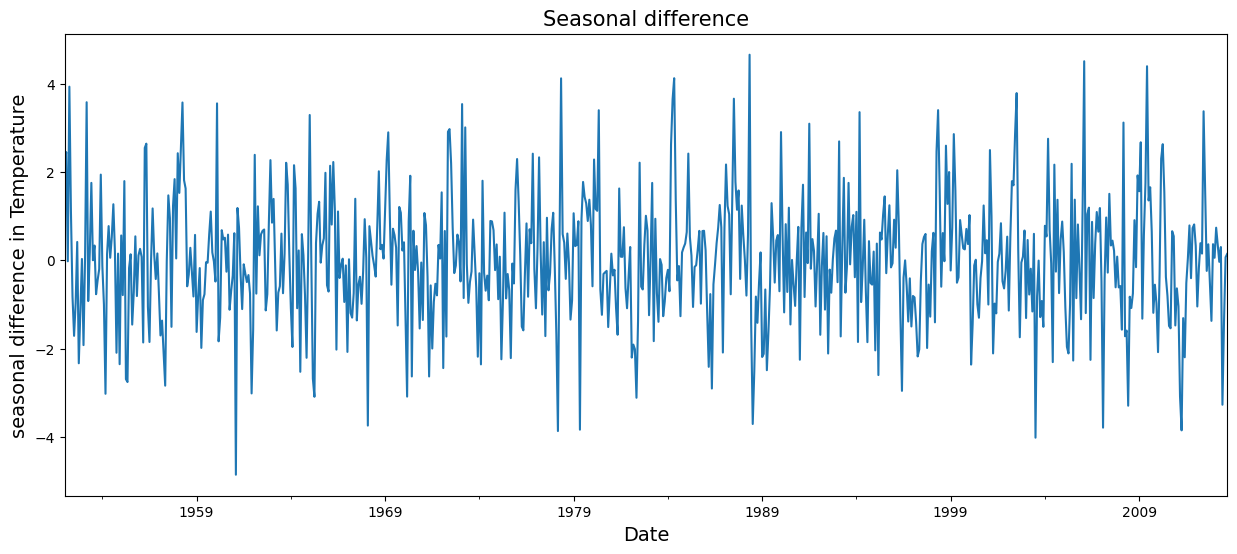

In [86]:
processed_data['Seasonal_Diff'].plot(figsize = (15, 6), legend = None)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('seasonal difference in Temperature', fontsize = 14)
plt.title('Seasonal difference', fontsize = 15)
plt.show()

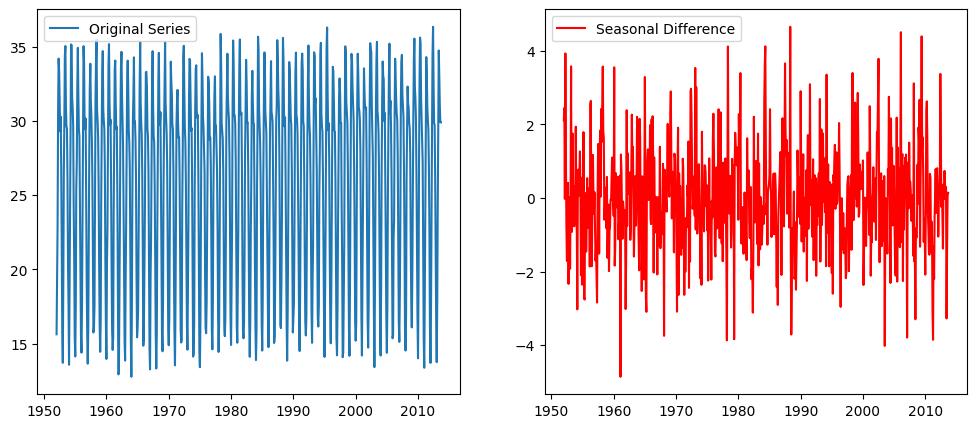

In [87]:
# Plot original vs seasonally differenced series
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(processed_data["AverageTemperature"], label="Original Series")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(processed_data["Seasonal_Diff"], label="Seasonal Difference", color="red")
plt.legend()
plt.show()

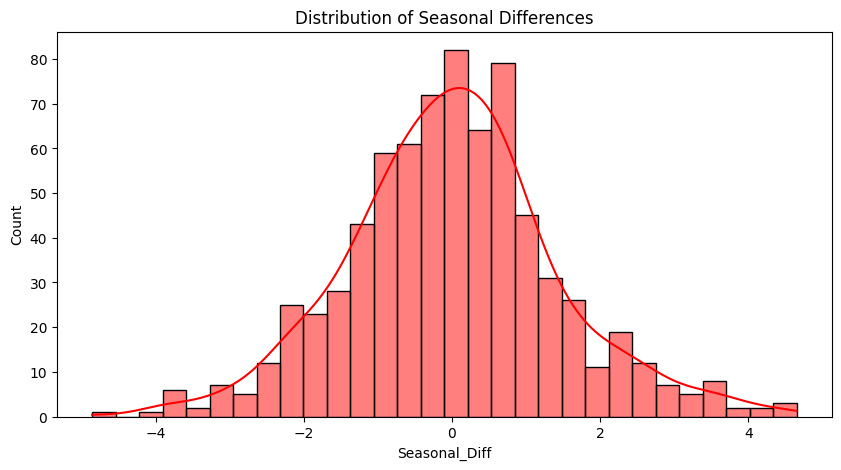

In [91]:
plt.figure(figsize=(10, 5))
sns.histplot(processed_data["Seasonal_Diff"].dropna(), kde=True, bins=30, color="red")
plt.title("Distribution of Seasonal Differences")
plt.show()


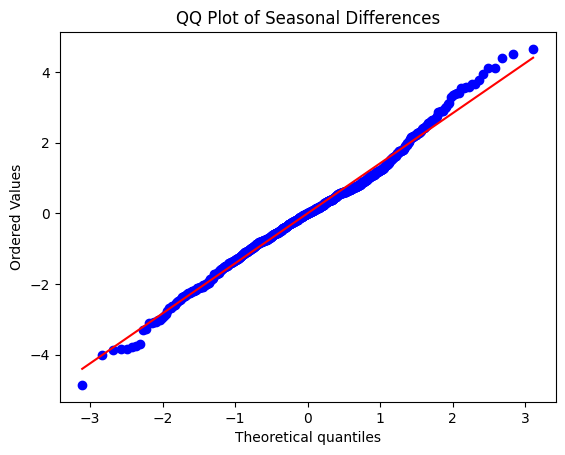

In [92]:

stats.probplot(processed_data["Seasonal_Diff"].dropna(), dist="norm", plot=pylab)
pylab.title("QQ Plot of Seasonal Differences")
pylab.show()


In [93]:
processed_data["Seasonal_Diff"]

ObservationDate
1952-01-01    2.115
1952-02-01    2.448
1952-03-01   -0.025
1952-04-01    3.929
1952-05-01    1.098
              ...  
2013-05-01    0.298
2013-06-01   -3.273
2013-07-01   -1.395
2013-08-01    0.067
2013-09-01    0.141
Name: Seasonal_Diff, Length: 741, dtype: float64

## **removing seasaonality using local trend and estimating seasonality**

In [94]:
print(processed_data.columns)


Index(['AverageTemperature', 'Seasonal_Diff'], dtype='object')


In [95]:
processed_data.index = pd.to_datetime(processed_data.index)

filtered_data = processed_data[processed_data["Seasonal_Diff"].abs() > 3]

high_diff_years = filtered_data.index.year.unique()

print("Years where Seasonal_Diff > 3:", high_diff_years)

print("\nSeasonal Difference values for these years:")
print(filtered_data["Seasonal_Diff"])


Years where Seasonal_Diff > 3: Index([1952, 1953, 1954, 1958, 1960, 1961, 1965, 1968, 1970, 1973, 1978, 1979,
       1980, 1982, 1984, 1987, 1988, 1991, 1994, 1998, 2002, 2003, 2006, 2007,
       2008, 2009, 2011, 2012, 2013],
      dtype='int32', name='ObservationDate')

Seasonal Difference values for these years:
ObservationDate
1952-04-01    3.929
1953-03-01    3.577
1954-03-01   -3.025
1958-04-01    3.571
1960-02-01    3.551
1961-02-01   -4.858
1961-12-01   -3.017
1965-01-01    3.288
1965-04-01   -3.093
1968-02-01   -3.745
1970-03-01   -3.089
1973-02-01    3.535
1973-04-01    3.007
1978-03-01   -3.869
1978-05-01    4.118
1979-05-01   -3.838
1980-05-01    3.396
1982-05-01   -3.115
1984-04-01    3.647
1984-05-01    4.121
1987-07-01    3.657
1988-05-01    4.653
1988-07-01   -3.709
1991-07-01    3.091
1994-03-01    3.352
1998-05-01    3.398
2002-07-01    3.784
2003-07-01   -4.019
2006-02-01    4.505
2007-02-01   -3.792
2008-03-01    3.116
2008-06-01   -3.295
2009-06-01    4.392
2011-03

In [96]:
df = processed_data['1980':'2012']
df

AverageTemperature  Seasonal_Diff
ObservationDate                                   
1980-01-01                   14.912         -0.591
1980-02-01                   19.007          2.280
1980-03-01                   22.747          1.160
1980-04-01                   30.976          1.118
1980-05-01                   35.417          3.396
...                             ...            ...
2012-08-01                   29.833         -0.242
2012-09-01                   29.759          0.360
2012-10-01                   26.354         -0.495
2012-11-01                   21.110         -1.374
2012-12-01                   16.566          0.363

[396 rows x 2 columns]

In [97]:

df = df.reset_index()

df["ObservationDate"] = pd.to_datetime(df["ObservationDate"])

df["Year"] = df["ObservationDate"].dt.year
df["Month"] = df["ObservationDate"].dt.month

df_pivot = df.pivot(index="Year", columns="Month", values="AverageTemperature")

print("Original 2D Data (Years × Months):")
print(df_pivot)

row_means = df_pivot.mean(axis=1)


df_centered = df_pivot.sub(row_means, axis=0)

print(df_centered)

column_means = df_centered.mean(axis=0)

df_deseasonalized = df_centered.sub(column_means, axis=1)

print("\nRow Means (Local Trend for Each Year):")
print(row_means)

print("\nColumn Means (Seasonal Component for Each Month):")
print(column_means)

print("\nDeseasonalized Data:")
print(df_deseasonalized)

Original 2D Data (Years × Months):
Month      1       2       3       4       5       6       7       8       9   \
Year                                                                            
1980   14.912  19.007  22.747  30.976  35.417  33.860  30.361  30.381  29.811   
1981   15.060  18.662  22.530  29.892  33.729  35.484  30.441  30.457  30.558   
1982   15.359  16.457  20.619  27.876  30.614  34.114  32.649  29.858  29.895   
1983   14.113  16.533  22.369  26.043  31.552  33.371  31.254  29.883  29.790   
1984   13.895  15.830  24.987  29.690  35.673  34.726  30.797  29.750  28.522   
1985   14.533  18.244  25.515  29.794  34.614  34.572  30.685  29.991  29.186   
1986   14.760  17.064  23.100  29.026  31.708  34.027  30.584  30.374  29.922   
1987   15.481  19.231  24.327  30.067  30.936  35.438  34.241  32.147  31.064   
1988   16.046  19.241  23.526  30.658  35.589  34.024  30.532  29.636  30.240   
1989   13.854  17.120  22.863  28.167  33.966  33.412  31.824  30.163  29.

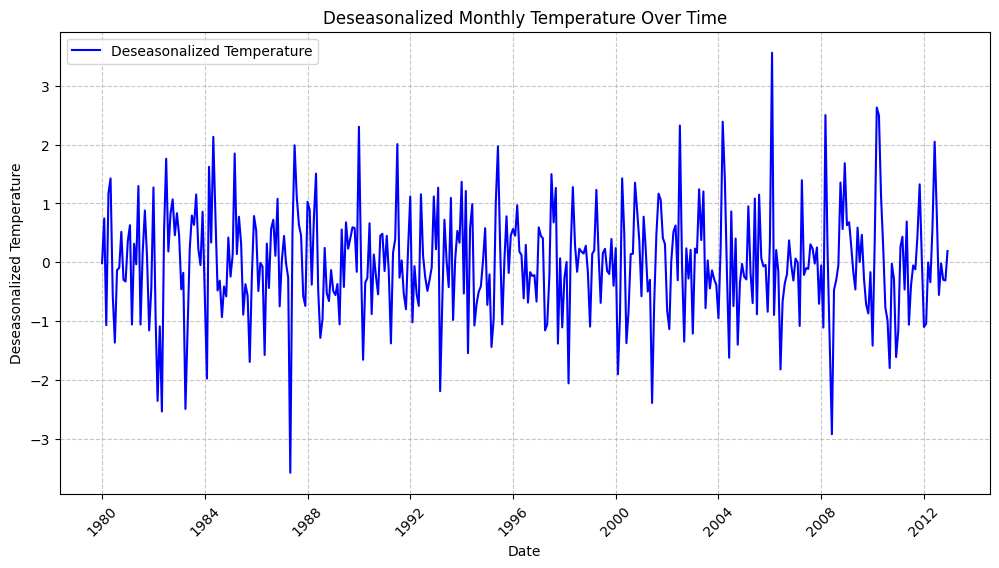

In [98]:

plt.figure(figsize=(12, 6))

# Create a new DataFrame to store all data points with Month-Year as x-axis labels
df_melted = df_deseasonalized.reset_index().melt(id_vars=["Year"], var_name="Month", value_name="Deseasonalized_Temperature")
df_melted["Date"] = pd.to_datetime(df_melted["Year"].astype(str) + "-" + df_melted["Month"].astype(str) + "-01")

df_melted = df_melted.sort_values("Date")

plt.plot(df_melted["Date"], df_melted["Deseasonalized_Temperature"], linestyle='-', marker='', color='blue', label='Deseasonalized Temperature')

plt.xlabel("Date")
plt.ylabel("Deseasonalized Temperature")
plt.title("Deseasonalized Monthly Temperature Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

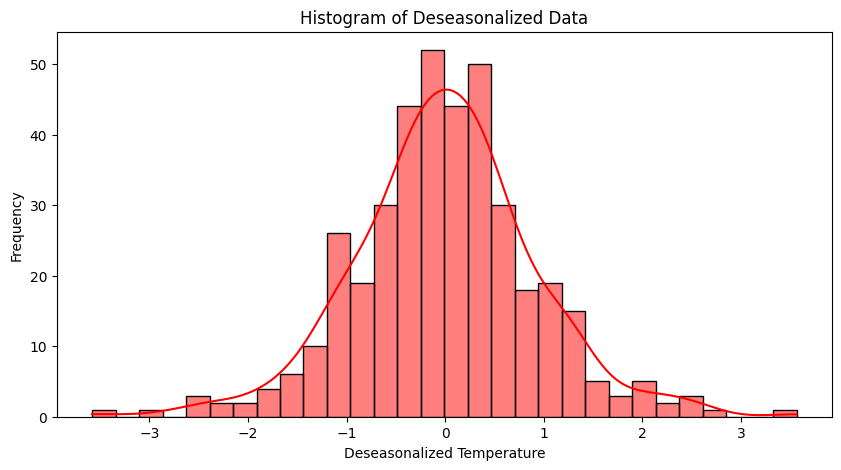

In [99]:

data = pd.Series(df_deseasonalized.values.flatten()).dropna()

plt.figure(figsize=(10, 5))
sns.histplot(data, kde=True, bins=30, color="red")
plt.xlabel("Deseasonalized Temperature")
plt.ylabel("Frequency")
plt.title("Histogram of Deseasonalized Data")
plt.show()

# **Fitting models and evaluation of models**

## **Trying ARIMA models**

In [402]:
time_series_data = processed_data['AverageTemperature']

In [403]:
train_data = time_series_data[:'2009']
test_data = time_series_data['2010':]

In [398]:
# Function to optimize SARIMA model
def optimize_SARIMA(endog: pd.Series, order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False
            ).fit(disp=False)

            aic = model.aic
            results.append([order, aic])

        except Exception as e:
            print(f"Skipping order {order} due to error: {e}")
            continue

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]
d = 0
D = 0
s = 12


ARIMA_order_list = list(product(ps, qs, Ps, Qs))

ARIMA_result_df = optimize_SARIMA(train_data, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

(p,q,P,Q)          AIC
0    (10, 11, 0, 0)  2097.825392
1    (12, 12, 0, 0)  2101.072022
2     (9, 11, 0, 0)  2107.440472
3     (7, 10, 0, 0)  2143.330938
4     (6, 10, 0, 0)  2146.744454
..              ...          ...
164    (0, 4, 0, 0)  4072.426795
165    (0, 3, 0, 0)  4430.811901
166    (0, 2, 0, 0)  4916.381727
167    (0, 1, 0, 0)  5625.248388
168    (0, 0, 0, 0)  6536.348343

[169 rows x 2 columns]

### **ARIMA(12,0,12)**

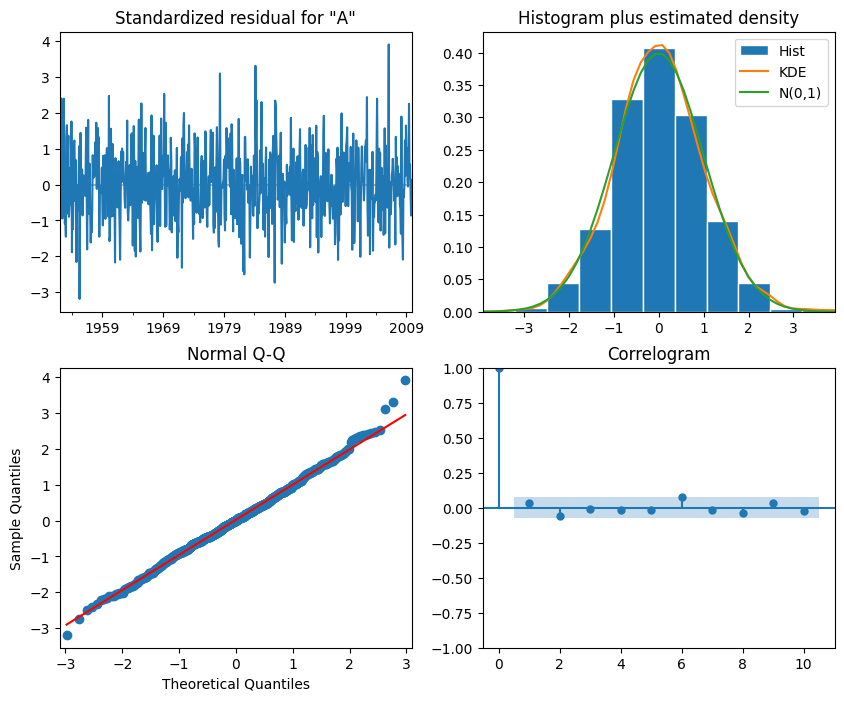

In [205]:
ARIMA_model = SARIMAX(train_data, order=(12,0,12), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
residuals = ARIMA_model_fit.resid
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [206]:

ljung_results = acorr_ljungbox(residuals, lags=20, return_df=True)

print(ljung_results)

      lb_stat  lb_pvalue
1    7.193859   0.007315
2    7.340927   0.025465
3   10.536825   0.014513
4   10.904109   0.027663
5   11.085673   0.049708
6   16.037027   0.013557
7   17.059424   0.017017
8   17.712786   0.023486
9   17.811616   0.037423
10  18.931955   0.041136
11  20.002578   0.045305
12  23.932322   0.020776
13  24.006375   0.031071
14  24.017392   0.045601
15  24.878074   0.051605
16  25.197652   0.066416
17  26.055998   0.073446
18  26.147398   0.096435
19  27.246445   0.099042
20  28.746896   0.092864


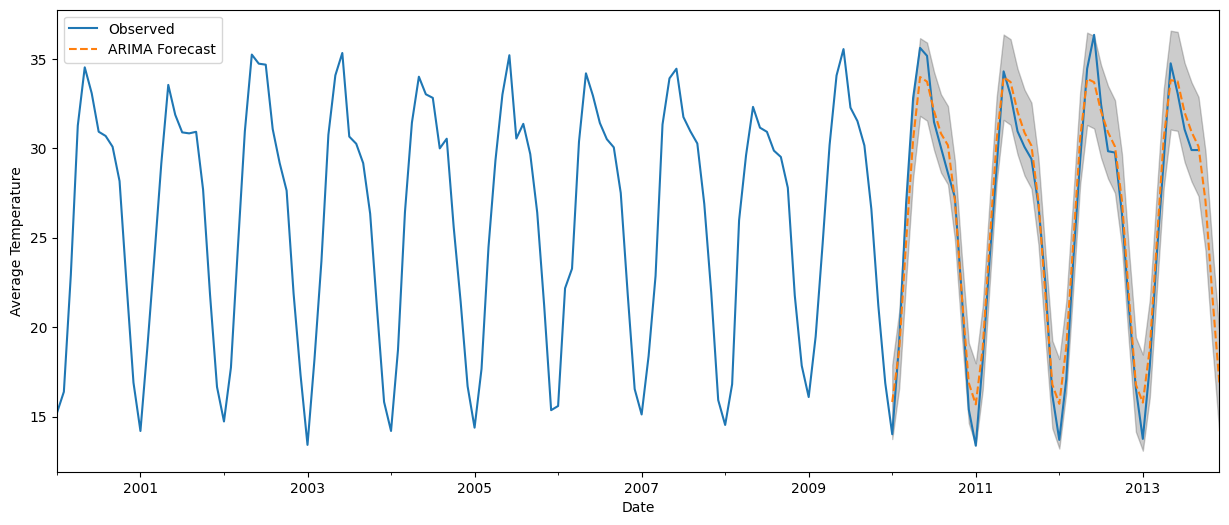

In [207]:
forecast_arima = ARIMA_model_fit.get_forecast(48)

# Plot forecast from 2000 onwards
ax_forecast1 = time_series_data['2000':].plot(label='Observed')
forecast_arima.predicted_mean.plot(ax=ax_forecast1, label='ARIMA Forecast', figsize=(15, 6), linestyle='dashed')
forecast_conf_int = forecast_arima.conf_int()
ax_forecast1.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.2)
ax_forecast1.set_xlabel('Date')
ax_forecast1.set_ylabel('Average Temperature')
plt.legend(loc='upper left')
plt.show()



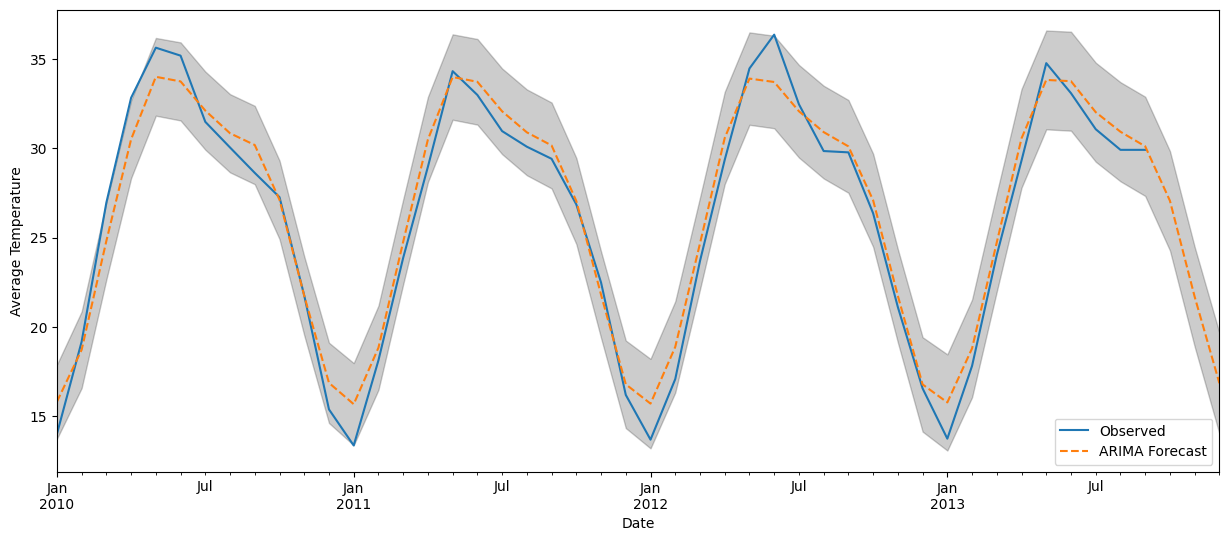

In [208]:
# Plot forecast from 2010 onwards
ax_forecast2 = time_series_data['2010':].plot(label='Observed')
forecast_arima.predicted_mean.plot(ax=ax_forecast2, label='ARIMA Forecast', figsize=(15, 6), linestyle='dashed')
ax_forecast2.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.2)
ax_forecast2.set_xlabel('Date')
ax_forecast2.set_ylabel('Average Temperature')
plt.legend()
plt.show()

In [209]:
forecast_values = forecast_arima.predicted_mean
forecast_index = forecast_values.index
common_index = forecast_index.intersection(test_data.index)

actual = test_data.loc[common_index]
forecast_values = forecast_values.loc[common_index]

mse = mean_squared_error(actual, forecast_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, forecast_values)
mape = np.mean(np.abs((actual - forecast_values) / actual)) * 100
r2 = r2_score(actual, forecast_values)
sse = np.sum((actual - forecast_values) ** 2)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")
print(f"Sum of Squared Errors (SSE): {sse:.4f}")

Mean Squared Error (MSE): 1.4780
Root Mean Squared Error (RMSE): 1.2157
Mean Absolute Error (MAE): 1.0298
Mean Absolute Percentage Error (MAPE): 4.52%
R-squared (R²): 0.9688
Sum of Squared Errors (SSE): 66.5093


In [222]:
df = processed_data[['AverageTemperature']].dropna()

train_len = int(len(df) * 0.9)
train = df.iloc[:train_len]
test = df.iloc[train_len:]

df_series = df['AverageTemperature']

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend([mean] * window)
        return pred_mean[:horizon]

    elif method == 'last':
        pred_last = []
        for i in range(train_len, total_len, window):
            last_val = df[:i].iloc[-1].values[0]
            pred_last.extend([last_val] * window)
        return pred_last[:horizon]

    elif method == 'ARMA':
        pred_ARMA = []
        for i in range(train_len, total_len, window):
            try:
                model = SARIMAX(df[:i], order=(12, 0, 12))
                res = model.fit(disp=False)
                forecast = res.get_forecast(steps=window)
                pred_ARMA.extend(forecast.predicted_mean)
            except:
                pred_ARMA.extend([np.nan]*window)
        return pred_ARMA[:horizon]


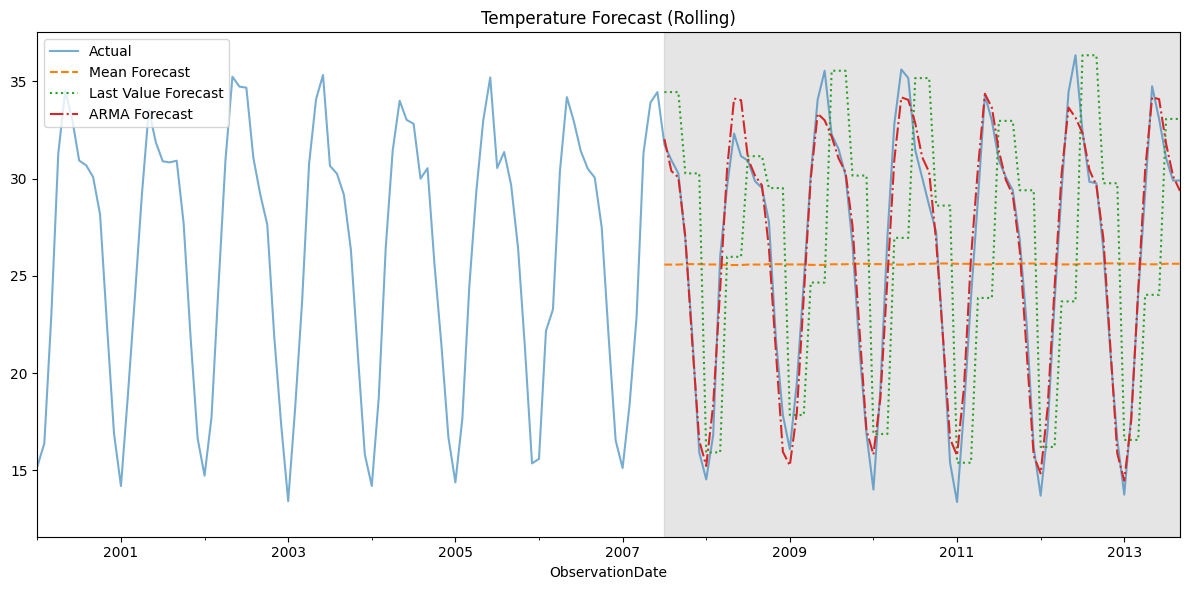

In [223]:
train_len = len(train)
horizon = len(test)
window = 3

pred_mean = rolling_forecast(df[['AverageTemperature']], train_len, horizon, window, 'mean')
pred_last = rolling_forecast(df[['AverageTemperature']], train_len, horizon, window, 'last')
pred_ARMA = rolling_forecast(df[['AverageTemperature']], train_len, horizon, window, 'ARMA')

test = test.copy()
test['pred_mean'] = pred_mean
test['pred_last'] = pred_last
test['pred_ARMA'] = pred_ARMA

fig, ax = plt.subplots(figsize=(12, 6))
df['AverageTemperature'].plot(ax=ax, label='Actual', alpha=0.6)
test['pred_mean'].plot(ax=ax, label='Mean Forecast', linestyle='--')
test['pred_last'].plot(ax=ax, label='Last Value Forecast', linestyle=':')
test['pred_ARMA'].plot(ax=ax, label='ARMA Forecast', linestyle='-.')
ax.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.2)

ax.set_xlim(pd.Timestamp("2000-01-01"), df.index[-1])
ax.legend()
ax.set_title('Temperature Forecast (Rolling)')
plt.tight_layout()
plt.show()


In [224]:
actual = test['AverageTemperature']
print("Mean Forecast MAE:", mean_absolute_error(actual, test['pred_mean']))
print("Last Forecast MAE:", mean_absolute_error(actual, test['pred_last']))
print("ARMA Forecast MAE:", mean_absolute_error(actual, test['pred_ARMA']))

mse = mean_squared_error(actual, test['pred_ARMA'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, test['pred_ARMA'])
mape = np.mean(np.abs((actual - test['pred_ARMA']) / actual)) * 100
r2 = r2_score(actual, test['pred_ARMA'])
sse = np.sum((actual - test['pred_ARMA']) ** 2)
print(f"ARMA Mean Squared Error (MSE): {mse:.4f}")
print(f"ARMA Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"ARMA Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"ARMA R-squared (R²): {r2:.4f}")
print(f"ARMA Sum of Squared Errors (SSE): {sse:.4f}")


Mean Forecast MAE: 5.867949148962756
Last Forecast MAE: 5.780493333333334
ARMA Forecast MAE: 0.8947137396632805
ARMA Mean Squared Error (MSE): 1.3021
ARMA Root Mean Squared Error (RMSE): 1.1411
ARMA Mean Absolute Percentage Error (MAPE): 3.78%
ARMA R-squared (R²): 0.9701
ARMA Sum of Squared Errors (SSE): 97.6569


### **ARIMA(13,0,13)**

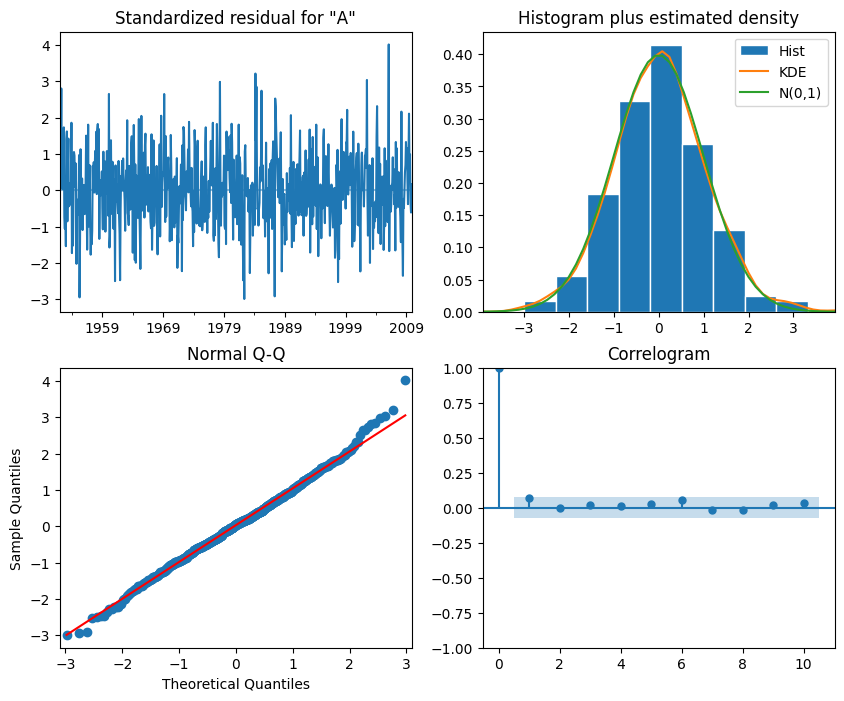

In [225]:
ARIMA_model = SARIMAX(train_data, order=(13,0,13), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
residuals = ARIMA_model_fit.resid
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [226]:

ljung_results = acorr_ljungbox(residuals, lags=20, return_df=True)

print(ljung_results)

      lb_stat  lb_pvalue
1    7.193859   0.007315
2    7.340927   0.025465
3   10.536825   0.014513
4   10.904109   0.027663
5   11.085673   0.049708
6   16.037027   0.013557
7   17.059424   0.017017
8   17.712786   0.023486
9   17.811616   0.037423
10  18.931955   0.041136
11  20.002578   0.045305
12  23.932322   0.020776
13  24.006375   0.031071
14  24.017392   0.045601
15  24.878074   0.051605
16  25.197652   0.066416
17  26.055998   0.073446
18  26.147398   0.096435
19  27.246445   0.099042
20  28.746896   0.092864


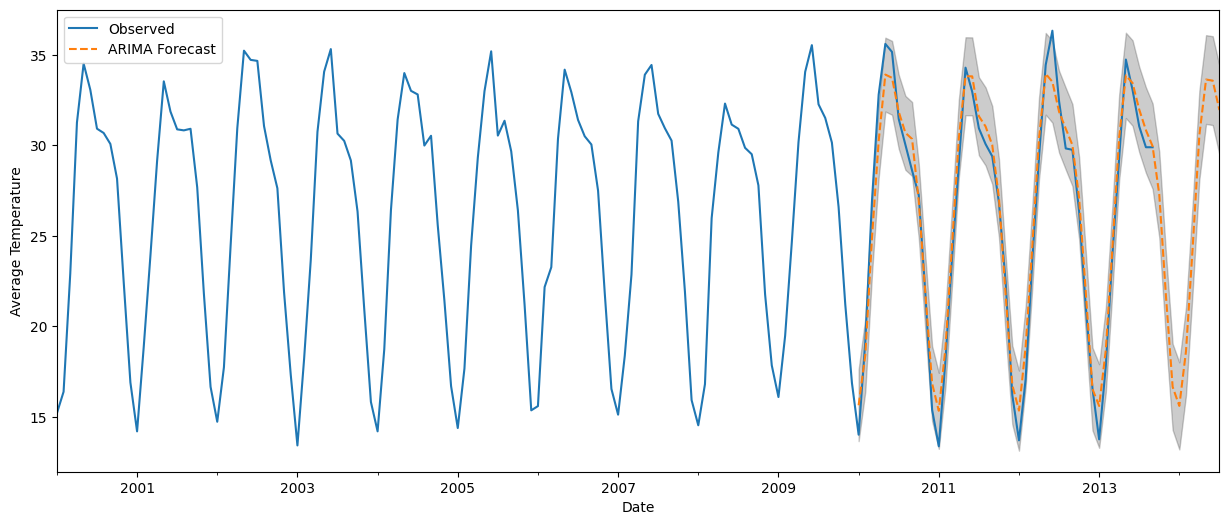

In [227]:
forecast_arima = ARIMA_model_fit.get_forecast(55)

# Plot forecast from 2000 onwards
ax_forecast1 = time_series_data['2000':].plot(label='Observed')
forecast_arima.predicted_mean.plot(ax=ax_forecast1, label='ARIMA Forecast', figsize=(15, 6), linestyle='dashed')
forecast_conf_int = forecast_arima.conf_int()
ax_forecast1.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.2)
ax_forecast1.set_xlabel('Date')
ax_forecast1.set_ylabel('Average Temperature')
plt.legend(loc='upper left')
plt.show()



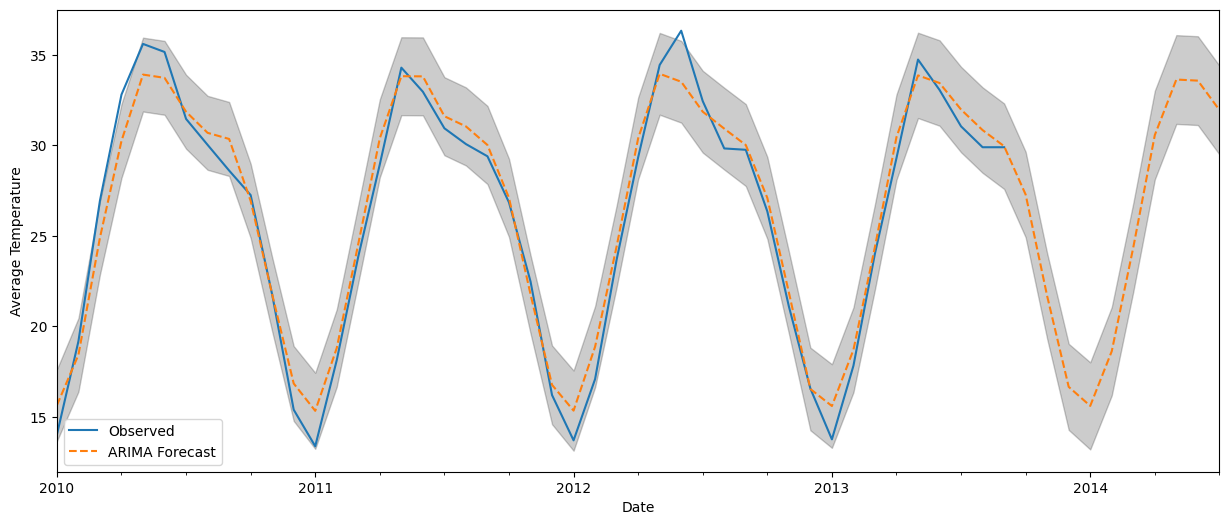

In [228]:
# Plot forecast from 2010 onwards
ax_forecast2 = time_series_data['2010':].plot(label='Observed')
forecast_arima.predicted_mean.plot(ax=ax_forecast2, label='ARIMA Forecast', figsize=(15, 6), linestyle='dashed')
ax_forecast2.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.2)
ax_forecast2.set_xlabel('Date')
ax_forecast2.set_ylabel('Average Temperature')
plt.legend()
plt.show()

In [229]:
forecast_values = forecast_arima.predicted_mean
forecast_index = forecast_values.index

common_index = forecast_index.intersection(test_data.index)

actual = test_data.loc[common_index]
forecast_values = forecast_values.loc[common_index]

mse = mean_squared_error(actual, forecast_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, forecast_values)
mape = np.mean(np.abs((actual - forecast_values) / actual)) * 100
r2 = r2_score(actual, forecast_values)
sse = np.sum((actual - forecast_values) ** 2)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")
print(f"Sum of Squared Errors (SSE): {sse:.4f}")

Mean Squared Error (MSE): 1.3769
Root Mean Squared Error (RMSE): 1.1734
Mean Absolute Error (MAE): 0.9782
Mean Absolute Percentage Error (MAPE): 4.23%
R-squared (R²): 0.9710
Sum of Squared Errors (SSE): 61.9603


In [230]:
df = processed_data[['AverageTemperature']].dropna()

train_len = int(len(df) * 0.9)
train = df.iloc[:train_len]
test = df.iloc[train_len:]

df_series = df['AverageTemperature']

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend([mean] * window)
        return pred_mean[:horizon]

    elif method == 'last':
        pred_last = []
        for i in range(train_len, total_len, window):
            last_val = df[:i].iloc[-1].values[0]
            pred_last.extend([last_val] * window)
        return pred_last[:horizon]

    elif method == 'ARMA':
        pred_ARMA = []
        for i in range(train_len, total_len, window):
            try:
                model = SARIMAX(df[:i], order=(13, 0, 13))
                res = model.fit(disp=False)
                forecast = res.get_forecast(steps=window)
                pred_ARMA.extend(forecast.predicted_mean)
            except:
                pred_ARMA.extend([np.nan]*window)
        return pred_ARMA[:horizon]


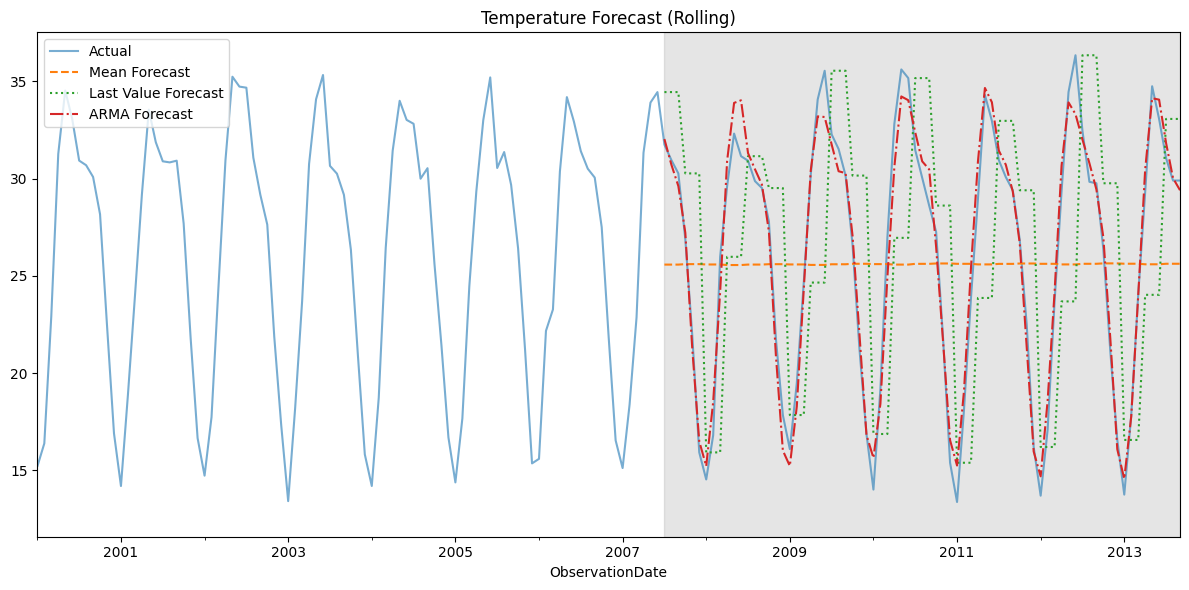

In [231]:
train_len = len(train)
horizon = len(test)
window = 3

pred_mean = rolling_forecast(df[['AverageTemperature']], train_len, horizon, window, 'mean')
pred_last = rolling_forecast(df[['AverageTemperature']], train_len, horizon, window, 'last')
pred_ARMA = rolling_forecast(df[['AverageTemperature']], train_len, horizon, window, 'ARMA')

test = test.copy()
test['pred_mean'] = pred_mean
test['pred_last'] = pred_last
test['pred_ARMA'] = pred_ARMA


fig, ax = plt.subplots(figsize=(12, 6))
df['AverageTemperature'].plot(ax=ax, label='Actual', alpha=0.6)
test['pred_mean'].plot(ax=ax, label='Mean Forecast', linestyle='--')
test['pred_last'].plot(ax=ax, label='Last Value Forecast', linestyle=':')
test['pred_ARMA'].plot(ax=ax, label='ARMA Forecast', linestyle='-.')
ax.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.2)

ax.set_xlim(pd.Timestamp("2000-01-01"), df.index[-1])
ax.legend()
ax.set_title('Temperature Forecast (Rolling)')
plt.tight_layout()
plt.show()


In [232]:
actual = test['AverageTemperature']
print("Mean Forecast MAE:", mean_absolute_error(actual, test['pred_mean']))
print("Last Forecast MAE:", mean_absolute_error(actual, test['pred_last']))
print("ARMA Forecast MAE:", mean_absolute_error(actual, test['pred_ARMA']))

mse = mean_squared_error(actual, test['pred_ARMA'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, test['pred_ARMA'])
mape = np.mean(np.abs((actual - test['pred_ARMA']) / actual)) * 100
r2 = r2_score(actual, test['pred_ARMA'])
sse = np.sum((actual - test['pred_ARMA']) ** 2)
print(f"ARMA Mean Squared Error (MSE): {mse:.4f}")
print(f"ARMA Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"ARMA Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"ARMA R-squared (R²): {r2:.4f}")
print(f"ARMA Sum of Squared Errors (SSE): {sse:.4f}")


Mean Forecast MAE: 5.867949148962756
Last Forecast MAE: 5.780493333333334
ARMA Forecast MAE: 0.9034404109555897
ARMA Mean Squared Error (MSE): 1.2521
ARMA Root Mean Squared Error (RMSE): 1.1190
ARMA Mean Absolute Percentage Error (MAPE): 3.74%
ARMA R-squared (R²): 0.9713
ARMA Sum of Squared Errors (SSE): 93.9092


## **SARIMA models**

In [235]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
d = 0
D = 1
s = 12
SARIMA_result_df = optimize_SARIMA(train_data, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

(p,q,P,Q)          AIC
0    (3, 2, 0, 1)  1961.123518
1    (2, 1, 0, 1)  1961.849086
2    (3, 2, 1, 1)  1962.242187
3    (3, 2, 0, 2)  1962.247090
4    (1, 2, 0, 2)  1962.334053
..            ...          ...
251  (0, 3, 0, 0)  2398.835465
252  (3, 1, 0, 0)  2399.330632
253  (1, 3, 0, 0)  2399.533380
254  (2, 2, 0, 0)  2399.587550
255  (0, 0, 0, 0)  2411.455849

[256 rows x 2 columns]

In [237]:
#The default values of several important parameters for auto_arima function are as follows:
#max_p=5, max_d=2, max_q=5, max_P=2, max_D=1, max_Q=2
auto_arima_model = auto_arima(train_data, seasonal = True, m = 12, stepwise = True, trace = 1, random_state = 10)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=7.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4614.814, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=3.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3510.880, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6536.348, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3906.768, Time=0.18 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2193.490, Time=3.95 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2465.682, Time=3.32 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=8.16 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2268.830, Time=9.31 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3207.031, Time=3.14 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=inf, Time=8.24 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=11.29 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=2168.943, Time=2.47 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=

In [270]:
import itertools
param_p = param_d = param_q = range(0, 3)
seasonal_param_p = seasonal_param_d = seasonal_param_q = range(0, 3)
seasonal_param_period = [12]
param_pdq = list(itertools.product(param_p, param_d, param_q))
seasonal_param_pdq = list(itertools.product(seasonal_param_p, seasonal_param_d, seasonal_param_q, seasonal_param_period))
best_aic_value = float("inf")
best_model_order = None
best_model_seasonal_order = None
for current_param in param_pdq:
    for current_seasonal_param in seasonal_param_pdq:
        try:
            model_optimized = sm.tsa.statespace.SARIMAX(train_data,
            order=current_param,
            seasonal_order=current_seasonal_param,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results_optimized = model_optimized.fit()
            if results_optimized.aic < best_aic_value:
                best_aic_value = results_optimized.aic
                best_model_order = current_param
                best_model_seasonal_order = current_seasonal_param
        except:
            continue
print(f"Best Model: order={best_model_order}, seasonal_order={best_model_seasonal_order}, AIC={best_aic_value}")

Best Model: order=(2, 1, 2), seasonal_order=(0, 1, 2, 12), AIC=1872.263820745789


### **SARIMA_model(order = (2,0,1), seasonal_order(0,1,1,12))**

In [347]:
model_sarimax = sm.tsa.statespace.SARIMAX(train_data, order = (2, 0, 1), seasonal_order = (0, 1, 1, 12),
enforce_stationarity = False, enforce_invertibility = False)
fitted_sarimax = model_sarimax.fit(maxiter = 200, method = 'nm')
residuals = fitted_sarimax.resid
print(fitted_sarimax.summary())

Optimization terminated successfully.
         Current function value: 1.369400
         Iterations: 174
         Function evaluations: 291
                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  696
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -953.103
Date:                            Sun, 20 Apr 2025   AIC                           1916.205
Time:                                    06:50:08   BIC                           1938.741
Sample:                                01-01-1952   HQIC                          1924.934
                                     - 12-01-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

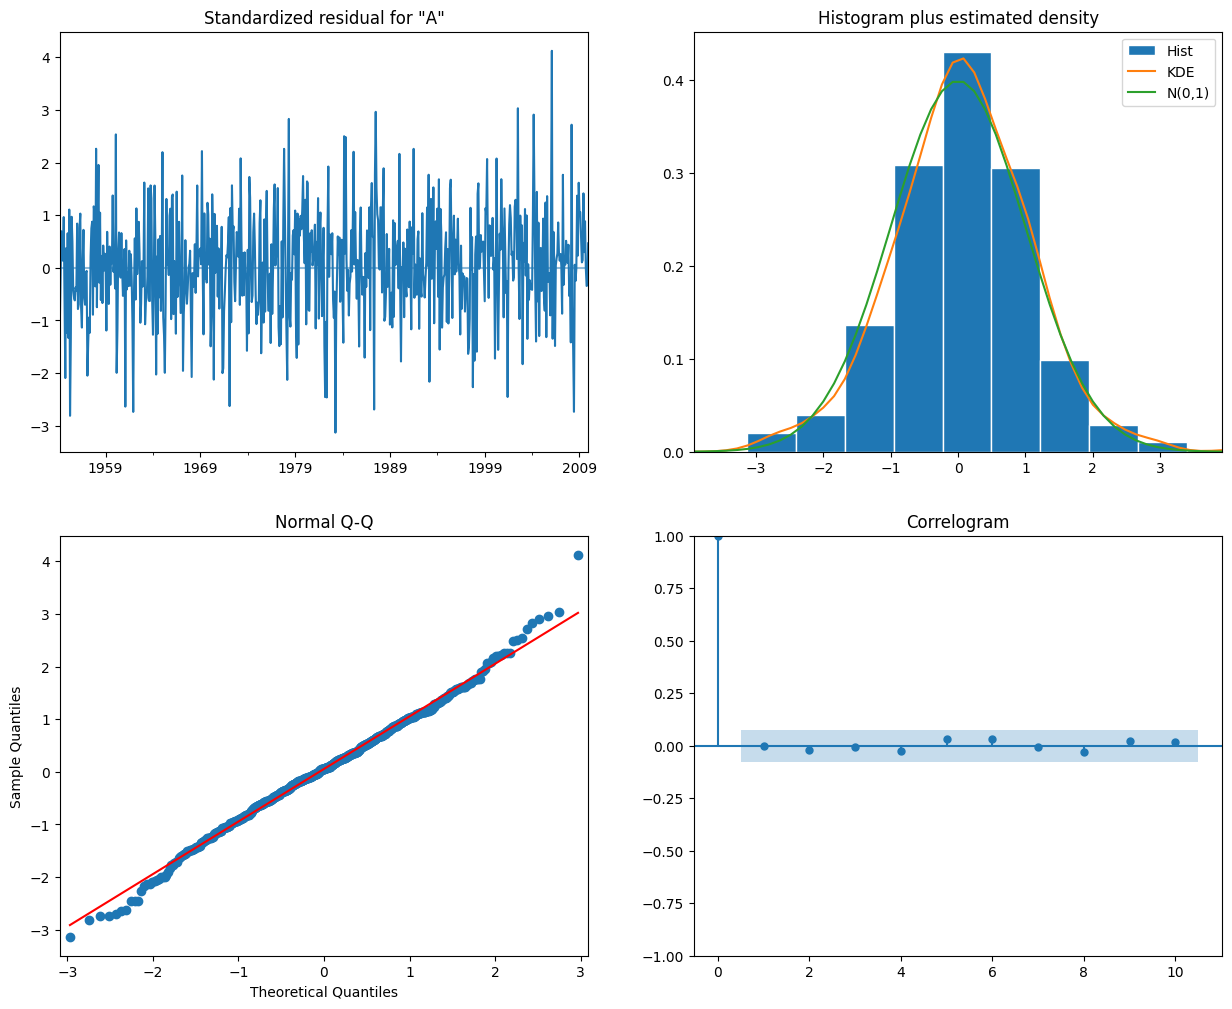

In [348]:
fitted_sarimax.plot_diagnostics(figsize = (15, 12))
plt.show()

In [349]:
ljung_results = acorr_ljungbox(residuals, lags=20, return_df=True)

print(ljung_results)


       lb_stat     lb_pvalue
1    58.884667  1.671900e-14
2    83.576176  7.106636e-19
3   111.598724  4.968842e-24
4   116.465110  3.037268e-24
5   119.123567  4.812292e-24
6   119.264432  2.325694e-23
7   122.512042  2.295812e-23
8   129.498168  3.594614e-24
9   139.867729  1.098588e-25
10  145.841137  2.668915e-26
11  155.731123  1.002569e-27
12  176.288654  2.461792e-31
13  178.980217  2.739679e-31
14  179.113162  9.796629e-31
15  179.351076  3.213198e-30
16  180.582839  6.436483e-30
17  181.005859  1.819539e-29
18  181.662383  4.491819e-29
19  182.095491  1.195854e-28
20  182.096180  3.772495e-28


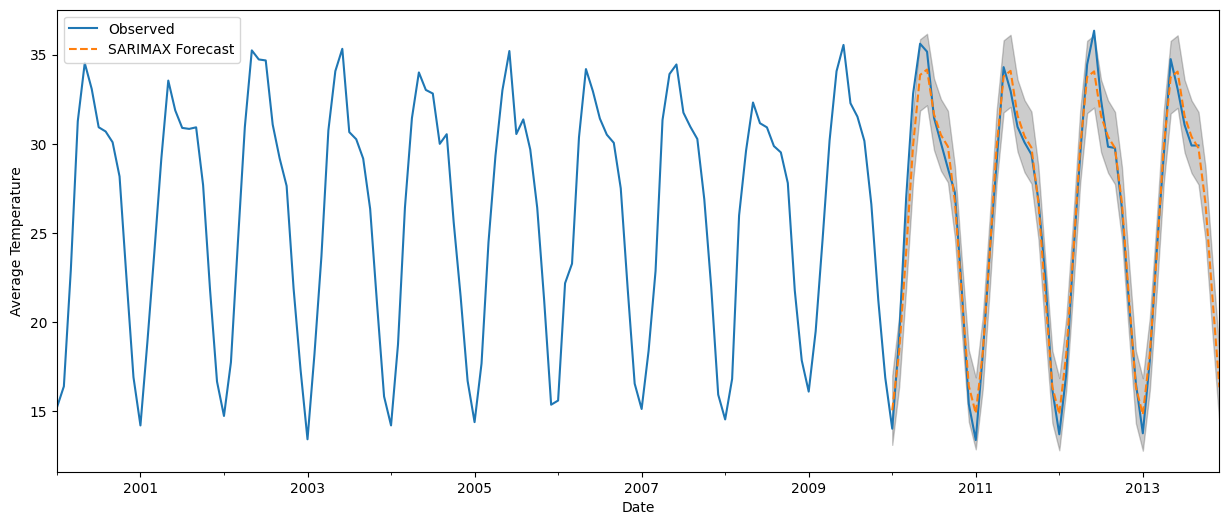

In [350]:
forecast_sarimax = fitted_sarimax.get_forecast(48)
ax_forecast1 = time_series_data['2000':].plot(label = 'Observed')
forecast_sarimax.predicted_mean.plot(ax = ax_forecast1, label = 'SARIMAX Forecast', figsize = (15, 6), linestyle = 'dashed')
forecast_confidence_interval = forecast_sarimax.conf_int()
ax_forecast1.fill_between(forecast_confidence_interval.index, forecast_confidence_interval.iloc[:, 0], forecast_confidence_interval.iloc[:, 1], color = 'k', alpha = 0.2)
ax_forecast1.set_xlabel('Date')
ax_forecast1.set_ylabel('Average Temperature')
plt.legend(loc = 'upper left')
plt.show()

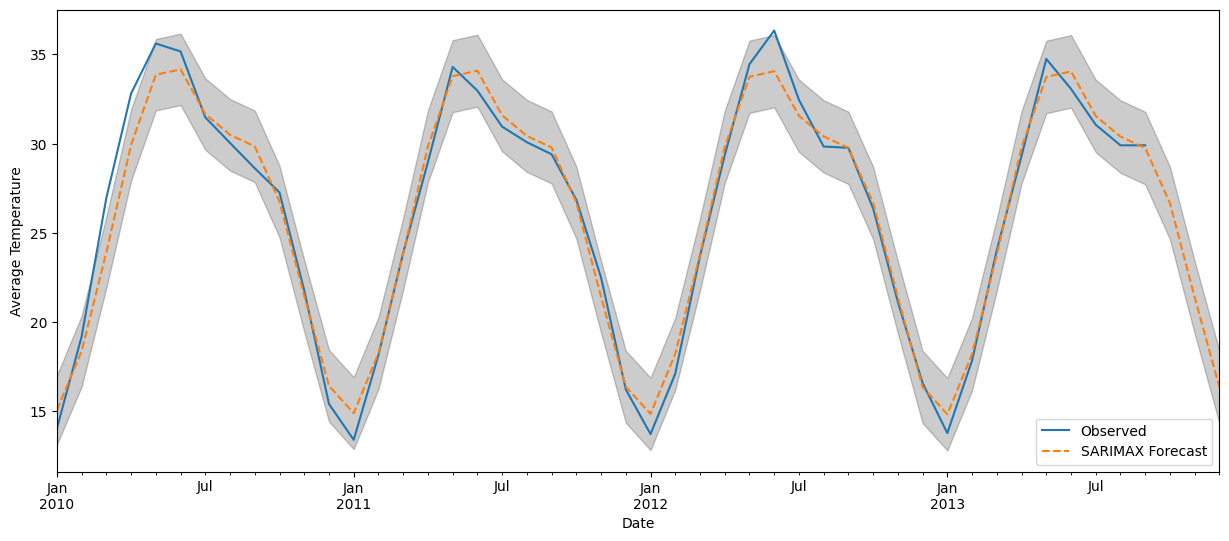

In [351]:
ax_forecast2 = time_series_data['2010':].plot(label = 'Observed')
forecast_sarimax.predicted_mean.plot(ax = ax_forecast2, label = 'SARIMAX Forecast', figsize = (15, 6), linestyle = 'dashed')
forecast_confidence_interval = forecast_sarimax.conf_int()
ax_forecast2.fill_between(forecast_confidence_interval.index, forecast_confidence_interval.iloc[:, 0], forecast_confidence_interval.iloc[:, 1], color = 'k', alpha = 0.2)
ax_forecast2.set_xlabel('Date')
ax_forecast2.set_ylabel('Average Temperature')
plt.legend()
plt.show()

In [352]:
forecast_values = forecast_sarimax.predicted_mean
forecast_index = forecast_values.index
common_index = forecast_index.intersection(test_data.index)

actual = test_data.loc[common_index]
forecast_values = forecast_values.loc[common_index]

mse = mean_squared_error(actual, forecast_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, forecast_values)
mape = np.mean(np.abs((actual - forecast_values) / actual)) * 100
r2 = r2_score(actual, forecast_values)
sse = np.sum((actual - forecast_values) ** 2)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")
print(f"Sum of Squared Errors (SSE): {sse:.4f}")

Mean Squared Error (MSE): 1.0402
Root Mean Squared Error (RMSE): 1.0199
Mean Absolute Error (MAE): 0.7675
Mean Absolute Percentage Error (MAPE): 3.16%
R-squared (R²): 0.9781
Sum of Squared Errors (SSE): 46.8079


### **SARIMA_model(order = (1,0,0), seasonal_order(1,0,1,12))**

In [407]:
model_sarimax = sm.tsa.statespace.SARIMAX(train_data, order = (1, 0, 0), seasonal_order = (1, 0, 1, 12),
enforce_stationarity = False, enforce_invertibility = False)
fitted_sarimax = model_sarimax.fit(maxiter = 200, method = 'nm')
residuals = fitted_sarimax.resid
print(fitted_sarimax.summary())

Optimization terminated successfully.
         Current function value: 1.401973
         Iterations: 137
         Function evaluations: 236
                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  696
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -975.773
Date:                              Sun, 20 Apr 2025   AIC                           1959.546
Time:                                      07:30:43   BIC                           1977.652
Sample:                                  01-01-1952   HQIC                          1966.553
                                       - 12-01-2009                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

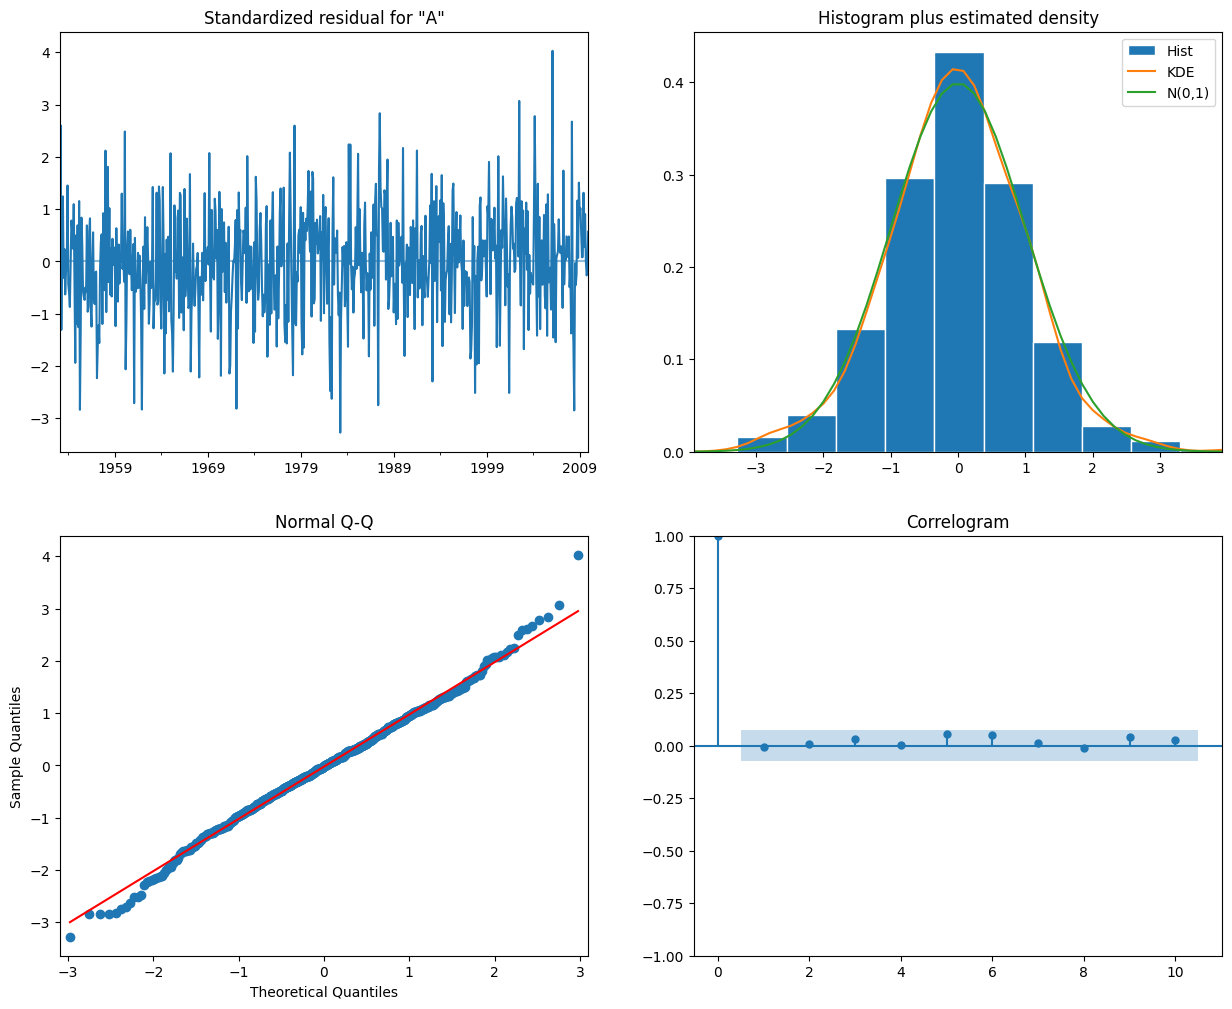

In [357]:
fitted_sarimax.plot_diagnostics(figsize = (15, 12))
plt.show()

In [358]:
ljung_results = acorr_ljungbox(residuals, lags=20, return_df=True)

print(ljung_results)


        lb_stat      lb_pvalue
1    468.409798  7.109016e-104
2    869.462882  1.579552e-189
3   1204.760734  6.796434e-261
4   1442.558127  4.084960e-311
5   1611.063261   0.000000e+00
6   1718.621859   0.000000e+00
7   1776.036539   0.000000e+00
8   1803.467161   0.000000e+00
9   1814.148331   0.000000e+00
10  1817.561559   0.000000e+00
11  1818.503300   0.000000e+00
12  1818.528735   0.000000e+00
13  1818.851317   0.000000e+00
14  1818.948543   0.000000e+00
15  1818.953797   0.000000e+00
16  1818.985630   0.000000e+00
17  1818.986321   0.000000e+00
18  1818.992334   0.000000e+00
19  1818.995001   0.000000e+00
20  1819.054308   0.000000e+00


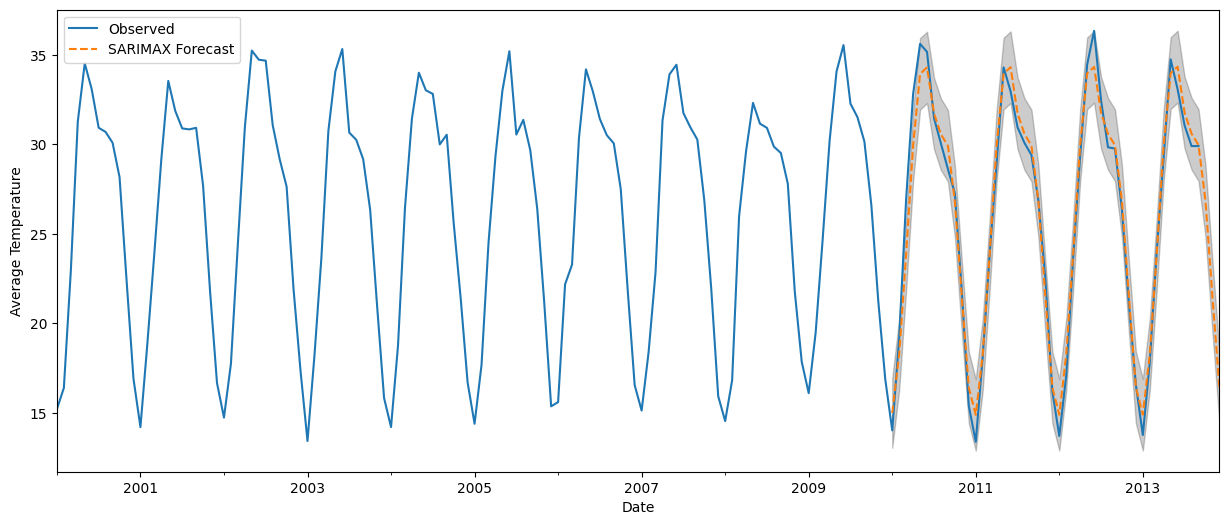

In [359]:
forecast_sarimax = fitted_sarimax.get_forecast(48)
ax_forecast1 = time_series_data['2000':].plot(label = 'Observed')
forecast_sarimax.predicted_mean.plot(ax = ax_forecast1, label = 'SARIMAX Forecast', figsize = (15, 6), linestyle = 'dashed')
forecast_confidence_interval = forecast_sarimax.conf_int()
ax_forecast1.fill_between(forecast_confidence_interval.index, forecast_confidence_interval.iloc[:, 0], forecast_confidence_interval.iloc[:, 1], color = 'k', alpha = 0.2)
ax_forecast1.set_xlabel('Date')
ax_forecast1.set_ylabel('Average Temperature')
plt.legend(loc = 'upper left')
plt.show()

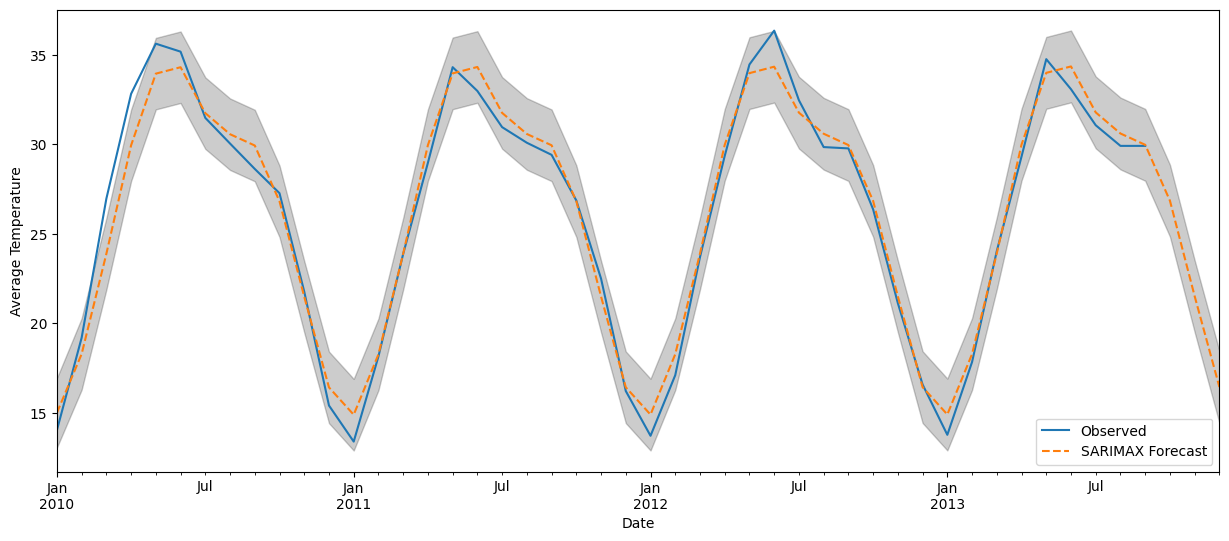

In [360]:
ax_forecast2 = time_series_data['2010':].plot(label = 'Observed')
forecast_sarimax.predicted_mean.plot(ax = ax_forecast2, label = 'SARIMAX Forecast', figsize = (15, 6), linestyle = 'dashed')
forecast_confidence_interval = forecast_sarimax.conf_int()
ax_forecast2.fill_between(forecast_confidence_interval.index, forecast_confidence_interval.iloc[:, 0], forecast_confidence_interval.iloc[:, 1], color = 'k', alpha = 0.2)
ax_forecast2.set_xlabel('Date')
ax_forecast2.set_ylabel('Average Temperature')
plt.legend()
plt.show()

In [361]:
forecast_values = forecast_sarimax.predicted_mean
forecast_index = forecast_values.index
common_index = forecast_index.intersection(test_data.index)

actual = test_data.loc[common_index]
forecast_values = forecast_values.loc[common_index]

mse = mean_squared_error(actual, forecast_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, forecast_values)
mape = np.mean(np.abs((actual - forecast_values) / actual)) * 100
r2 = r2_score(actual, forecast_values)
sse = np.sum((actual - forecast_values) ** 2)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")
print(f"Sum of Squared Errors (SSE): {sse:.4f}")

Mean Squared Error (MSE): 1.0654
Root Mean Squared Error (RMSE): 1.0322
Mean Absolute Error (MAE): 0.7950
Mean Absolute Percentage Error (MAPE): 3.28%
R-squared (R²): 0.9775
Sum of Squared Errors (SSE): 47.9451


In [408]:
df = processed_data[['AverageTemperature']].dropna()

train_len = int(len(df) * 0.9)
train = df.iloc[:train_len]
test = df.iloc[train_len:]

df_series = df['AverageTemperature']
def rolling_forecast_sarima(
    df: pd.Series,
    train_len: int,
    horizon: int,
    window: int,
    order: tuple = (1, 0, 0),
    seasonal_order: tuple = (1, 0, 1, 12)
) -> list:

    total_len = train_len + horizon
    pred_sarima = []

    for i in range(train_len, total_len, window):
        try:
            model = SARIMAX(
                df[:i],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            forecast = result.get_forecast(steps=window)
            forecast_values = forecast.predicted_mean
            pred_sarima.extend(forecast_values)
        except Exception as e:
            print(f"Error at step {i}: {e}")
            pred_sarima.extend([np.nan] * window)

    return pred_sarima[:horizon]


In [409]:

train_len = len(train)
horizon = len(test)
window = 3

sarima_preds = rolling_forecast_sarima(
    df=df_series,
    train_len=train_len,
    horizon=horizon,
    window=window,
    order=(1, 0, 0),
    seasonal_order=(1, 0, 1, 12)
)

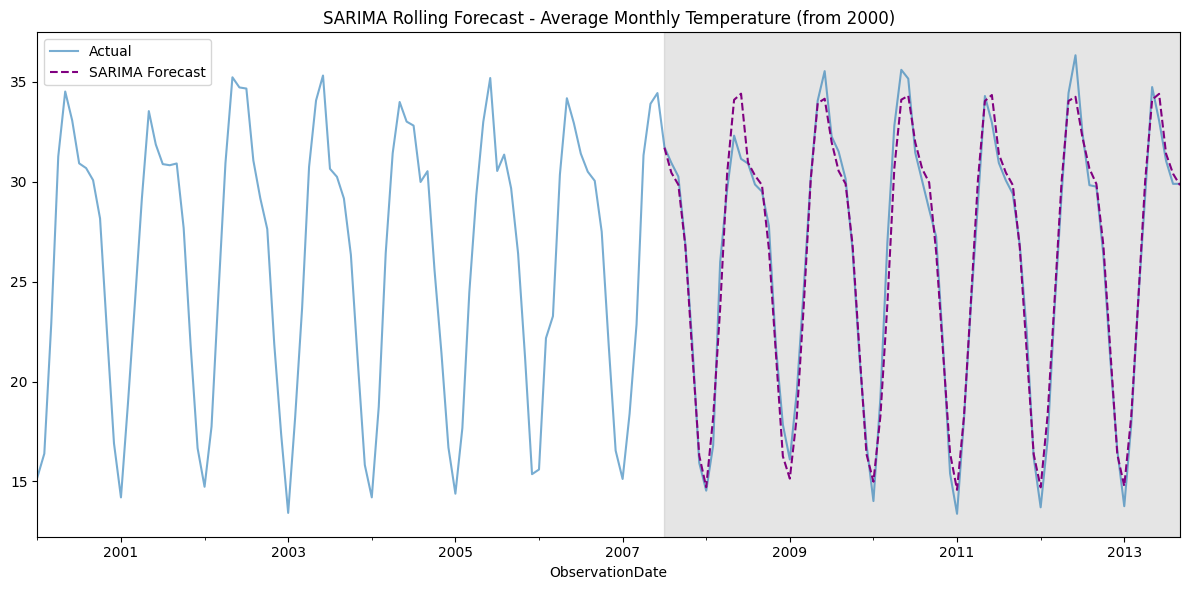

SARIMA Forecast Evaluation:
MAE: 0.7565726917297038
MSE: 1.0128460706623337
RMSE: 1.0064025390778453
MAPE: 3.11201099086901
R²: 0.9767785197419224


In [410]:

test['pred_SARIMA'] = sarima_preds

fig, ax = plt.subplots(figsize=(12, 6))

df['AverageTemperature']['2000':].plot(ax=ax, label='Actual', alpha=0.6)
test['pred_SARIMA']['2000':].plot(ax=ax, label='SARIMA Forecast', linestyle='--', color='purple')

ax.axvspan(max(test.index[0], pd.Timestamp('2000-01-01')), test.index[-1], color='gray', alpha=0.2)

ax.legend()
ax.set_title('SARIMA Rolling Forecast - Average Monthly Temperature (from 2000)')
plt.tight_layout()
plt.show()


actual = test['AverageTemperature'].dropna()
pred = test['pred_SARIMA'].dropna()

print("SARIMA Forecast Evaluation:")
print("MAE:", mean_absolute_error(actual, pred))
print("MSE:", mean_squared_error(actual, pred))
print("RMSE:", np.sqrt(mean_squared_error(actual, pred)))
print("MAPE:", np.mean(np.abs((actual - pred) / actual)) * 100)
print("R²:", r2_score(actual, pred))

## **Models after taking first order difference**

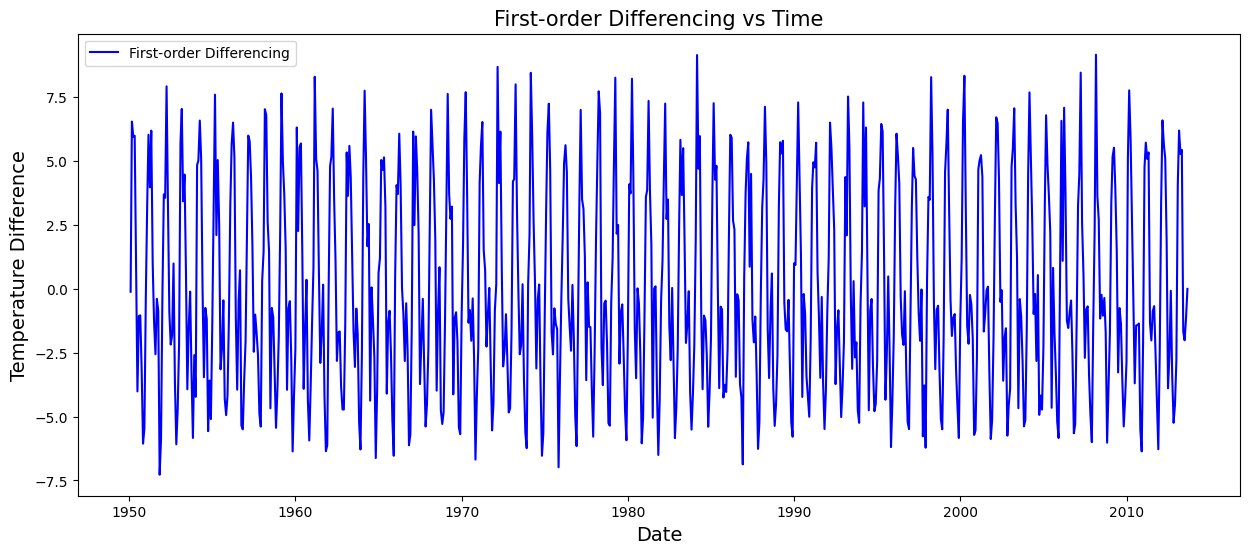

In [19]:
# First-order differencing to remove trend
processed_data_diff = processed_data['AverageTemperature'].diff().dropna()

# Plotting the differenced time series
plt.figure(figsize=(15, 6))
plt.plot(processed_data_diff, label="First-order Differencing", color="blue")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Temperature Difference", fontsize=14)
plt.title("First-order Differencing vs Time", fontsize=15)
plt.legend()
plt.show()


In [20]:
def perform_adf_test(time_series_data):
    print ('Results of Dickey-Fuller Test:')
    dftest_result = adfuller(time_series_data, autolag = 'AIC')
    df_output_result = pd.Series(dftest_result[0:4], index = ['Test Statistic','p-value','No. of Lags Used',
    'Number of Observations Used'])
    for key,value in dftest_result[4].items():
        df_output_result['Critical Value (%s)'%key] = value
    print (df_output_result)
perform_adf_test(processed_data_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.551565e+01
p-value                        2.318178e-28
No. of Lags Used               1.200000e+01
Number of Observations Used    7.510000e+02
Critical Value (1%)           -3.439087e+00
Critical Value (5%)           -2.865396e+00
Critical Value (10%)          -2.568823e+00
dtype: float64


In [21]:
from statsmodels.tsa.stattools import kpss
def perform_kpss_test(time_series_data):
    print ('Results of KPSS Test:')
    kpsstest_result = kpss(time_series_data, regression = 'c', nlags = 'legacy')
    kpss_output_result = pd.Series(kpsstest_result[0:3], index = ['Test Statistic','p-value','No. of Lags Used'])
    for key,value in kpsstest_result[3].items():
        kpss_output_result['Critical Value (%s)'%key] = value
    print (kpss_output_result)
perform_kpss_test(processed_data_diff)

Results of KPSS Test:
Test Statistic            0.019167
p-value                   0.100000
No. of Lags Used         20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<ipython-input-21-01b54e51b934>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest_result = kpss(time_series_data, regression = 'c', nlags = 'legacy')


In [22]:
time_series_data = processed_data_diff

In [23]:
train_data = time_series_data[:'2009']
test_data = time_series_data['2010':]

In [422]:
# Function to optimize SARIMA model
def optimize_SARIMA(endog: pd.Series, order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False
            ).fit(disp=False)

            aic = model.aic
            results.append([order, aic])

        except Exception as e:
            print(f"Skipping order {order} due to error: {e}")
            continue

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]
d = 0
D = 0
s = 12


ARIMA_order_list = list(product(ps, qs, Ps, Qs))

ARIMA_result_df = optimize_SARIMA(train_data, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

(p,q,P,Q)          AIC
0    (12, 11, 0, 0)  2075.769803
1    (11, 11, 0, 0)  2079.391304
2     (9, 10, 0, 0)  2081.846611
3    (10, 11, 0, 0)  2085.852176
4    (10, 10, 0, 0)  2090.504954
..              ...          ...
164    (0, 2, 0, 0)  3448.053142
165    (1, 1, 0, 0)  3461.521158
166    (1, 0, 0, 0)  3511.031635
167    (0, 1, 0, 0)  3552.057200
168    (0, 0, 0, 0)  3887.729635

[169 rows x 2 columns]

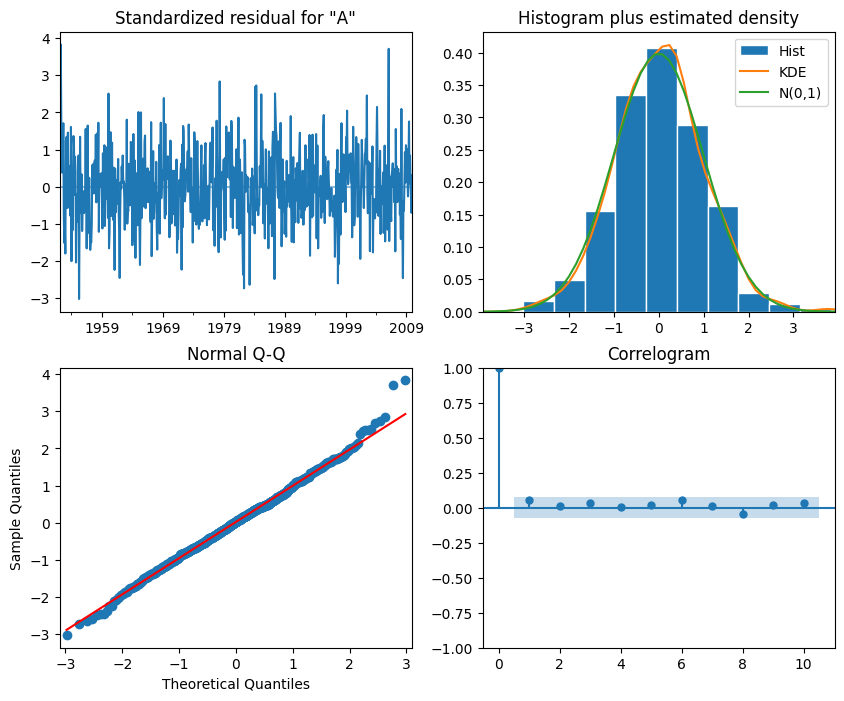

In [417]:
ARIMA_model = SARIMAX(train_data, order=(11,0,11), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
residuals = ARIMA_model_fit.resid
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [418]:
ljung_results = acorr_ljungbox(residuals, lags=20, return_df=True)

print(ljung_results)

      lb_stat  lb_pvalue
1    7.229208   0.007173
2    8.983753   0.011200
3   10.622995   0.013949
4   10.775429   0.029207
5   11.498161   0.042350
6   13.068442   0.041962
7   13.084964   0.070065
8   15.519382   0.049799
9   15.552252   0.076841
10  16.287199   0.091701
11  16.287494   0.130789
12  16.661751   0.162770
13  16.749125   0.211028
14  17.201079   0.245621
15  19.344387   0.198550
16  21.941567   0.145088
17  24.027630   0.118686
18  24.051584   0.153345
19  24.934358   0.162714
20  25.034896   0.200099


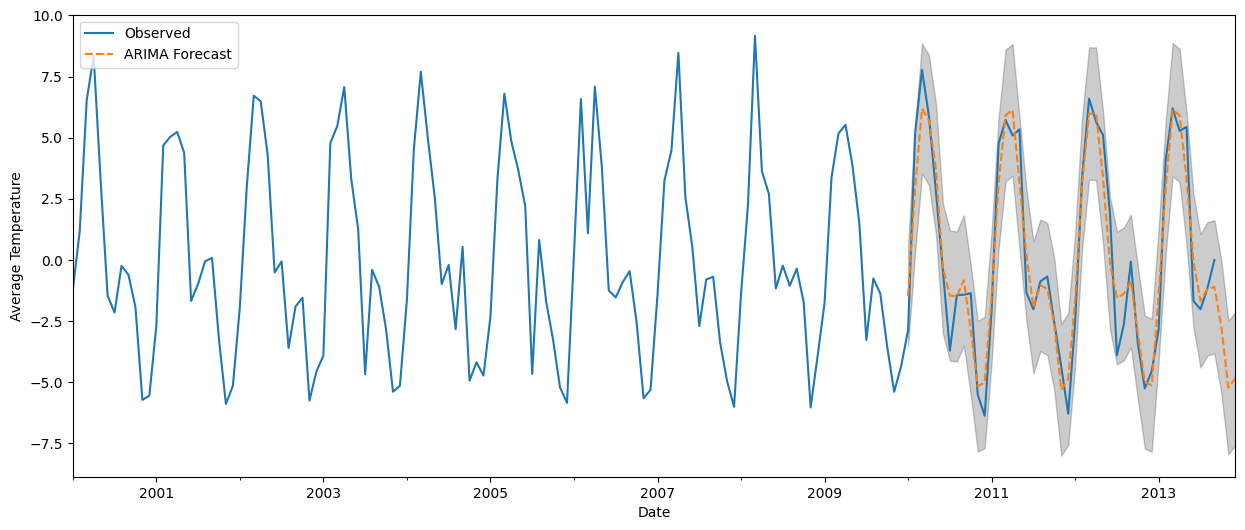

In [419]:
forecast_arima = ARIMA_model_fit.get_forecast(48)

# Plot forecast from 2000 onwards
ax_forecast1 = time_series_data['2000':].plot(label='Observed')
forecast_arima.predicted_mean.plot(ax=ax_forecast1, label='ARIMA Forecast', figsize=(15, 6), linestyle='dashed')
forecast_conf_int = forecast_arima.conf_int()
ax_forecast1.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.2)
ax_forecast1.set_xlabel('Date')
ax_forecast1.set_ylabel('Average Temperature')
plt.legend(loc='upper left')
plt.show()



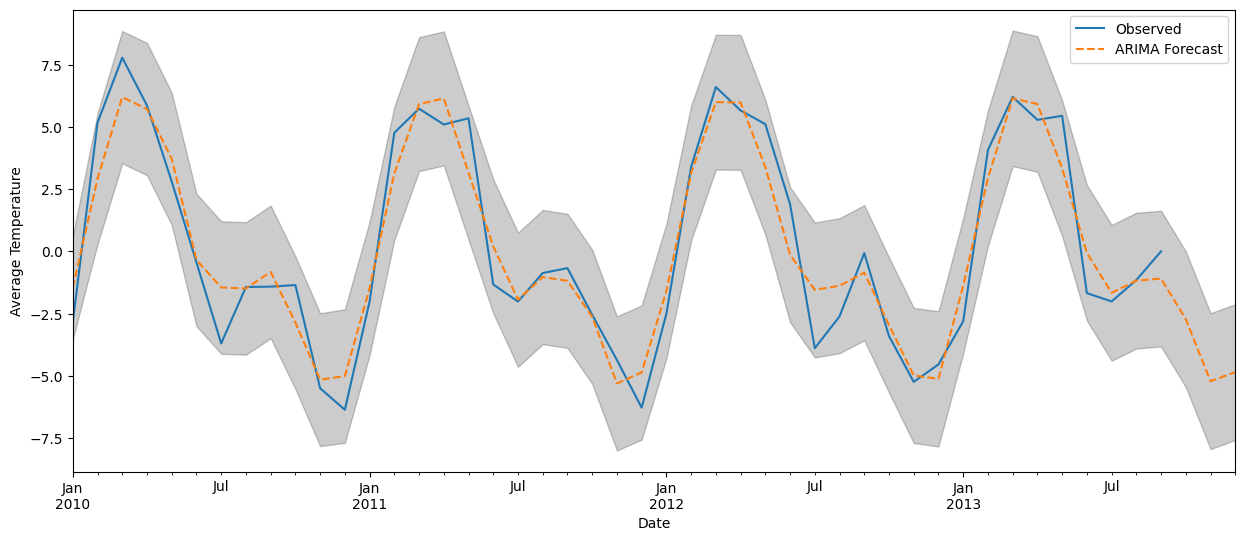

In [420]:
# Plot forecast from 2010 onwards
ax_forecast2 = time_series_data['2010':].plot(label='Observed')
forecast_arima.predicted_mean.plot(ax=ax_forecast2, label='ARIMA Forecast', figsize=(15, 6), linestyle='dashed')
ax_forecast2.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.2)
ax_forecast2.set_xlabel('Date')
ax_forecast2.set_ylabel('Average Temperature')
plt.legend()
plt.show()


In [421]:
forecast_values = forecast_arima.predicted_mean
forecast_index = forecast_values.index
common_index = forecast_index.intersection(test_data.index)

actual = test_data.loc[common_index]
forecast_values = forecast_values.loc[common_index]

# Drop rows where actual values are 0 or NaN to prevent division by zero or NaNs in MAPE
valid_mask = (actual != 0) & (~actual.isna()) & (~forecast_values.isna())
actual = actual[valid_mask]
forecast_values = forecast_values[valid_mask]

mse = mean_squared_error(actual, forecast_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, forecast_values)
mape = np.mean(np.abs((actual - forecast_values) / actual)) * 100
r2 = r2_score(actual, forecast_values)
sse = np.sum((actual - forecast_values) ** 2)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")
print(f"Sum of Squared Errors (SSE): {sse:.4f}")


Mean Squared Error (MSE): 1.4032
Root Mean Squared Error (RMSE): 1.1846
Mean Absolute Error (MAE): 0.9488
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R²): 0.9151
Sum of Squared Errors (SSE): 63.1449


In [423]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
d = 0
D = 1
s = 12
SARIMA_result_df = optimize_SARIMA(train_data, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

(p,q,P,Q)          AIC
0    (2, 2, 0, 1)  1965.064070
1    (1, 1, 0, 1)  1965.861110
2    (2, 2, 1, 1)  1966.010602
3    (2, 2, 0, 2)  1966.031588
4    (1, 1, 0, 2)  1966.347263
..            ...          ...
251  (0, 0, 1, 0)  2510.563116
252  (3, 0, 0, 0)  2520.416171
253  (2, 0, 0, 0)  2563.754556
254  (1, 0, 0, 0)  2624.711348
255  (0, 0, 0, 0)  2758.984411

[256 rows x 2 columns]

In [24]:
model_sarimax = sm.tsa.statespace.SARIMAX(train_data, order = (1, 0, 1), seasonal_order = (0, 1, 1, 12),
enforce_stationarity = False, enforce_invertibility = False)
fitted_sarimax = model_sarimax.fit(maxiter = 200, method = 'nm')
residuals = fitted_sarimax.resid
print(fitted_sarimax.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 1.377698
         Iterations: 143
         Function evaluations: 246
                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  719
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -990.565
Date:                            Sun, 20 Apr 2025   AIC                           1989.129
Time:                                    10:45:26   BIC                           2007.293
Sample:                                02-01-1950   HQIC                          1996.154
                                     - 12-01-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

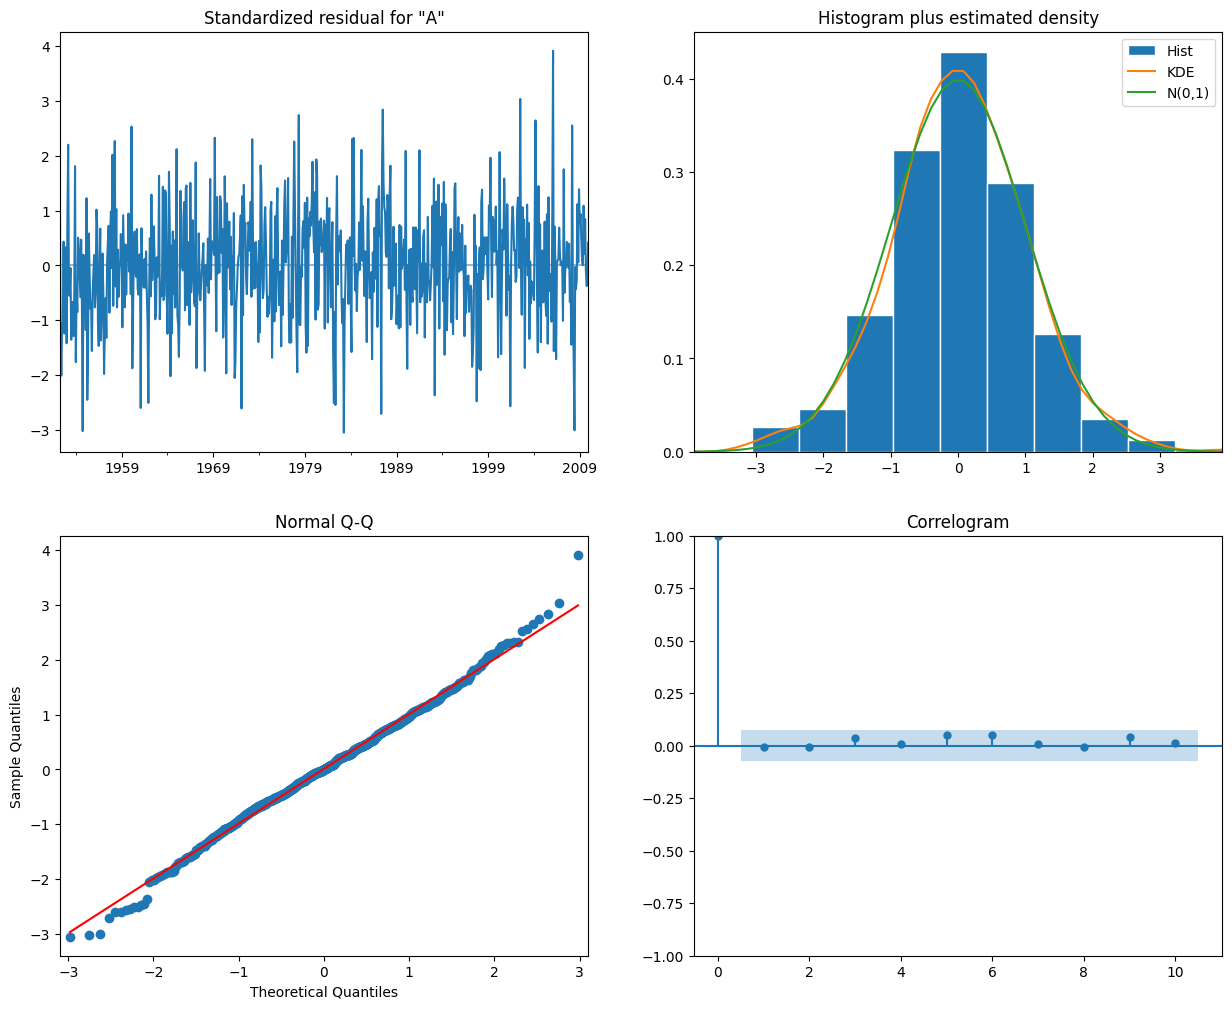

In [25]:

fitted_sarimax.plot_diagnostics(figsize = (15, 12))
plt.show()


In [26]:

ljung_results = acorr_ljungbox(residuals, lags=20, return_df=True)

print(ljung_results)


      lb_stat  lb_pvalue
1    9.467012   0.002092
2    9.599671   0.008231
3    9.816822   0.020189
4    9.832360   0.043348
5   11.974115   0.035144
6   12.127230   0.059190
7   19.499537   0.006758
8   24.517678   0.001876
9   24.685883   0.003339
10  24.696519   0.005951
11  25.867768   0.006790
12  30.944588   0.002009
13  30.963169   0.003414
14  30.968255   0.005601
15  31.283966   0.008047
16  31.442684   0.011807
17  31.576785   0.016976
18  31.822436   0.023075
19  34.150615   0.017640
20  38.205224   0.008358


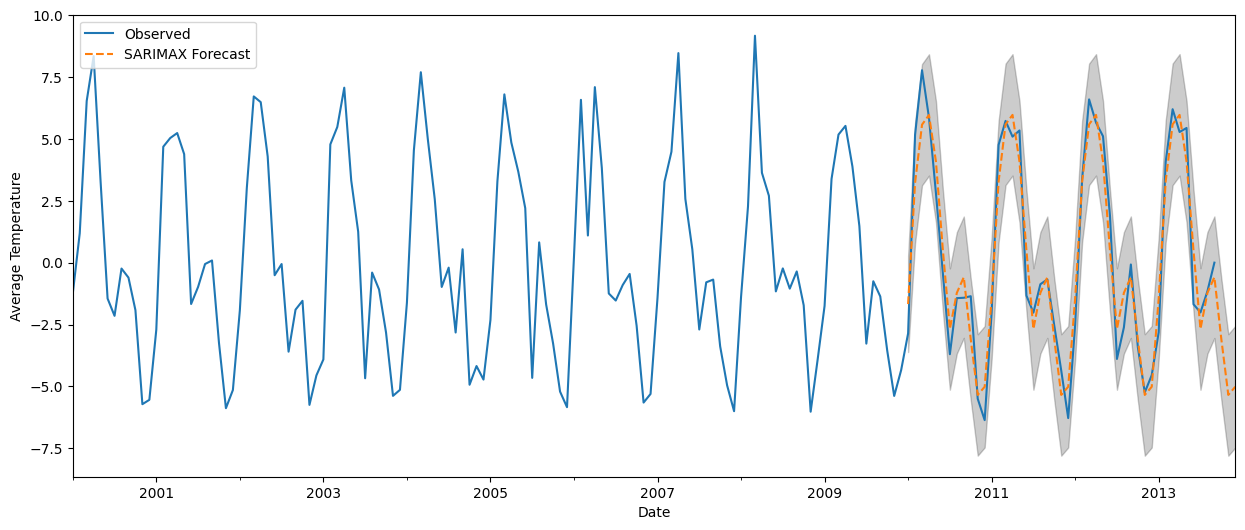

In [27]:
forecast_sarimax = fitted_sarimax.get_forecast(48)
ax_forecast1 = time_series_data['2000':].plot(label = 'Observed')
forecast_sarimax.predicted_mean.plot(ax = ax_forecast1, label = 'SARIMAX Forecast', figsize = (15, 6), linestyle = 'dashed')
forecast_confidence_interval = forecast_sarimax.conf_int()
ax_forecast1.fill_between(forecast_confidence_interval.index, forecast_confidence_interval.iloc[:, 0], forecast_confidence_interval.iloc[:, 1], color = 'k', alpha = 0.2)
ax_forecast1.set_xlabel('Date')
ax_forecast1.set_ylabel('Average Temperature')
plt.legend(loc = 'upper left')
plt.show()


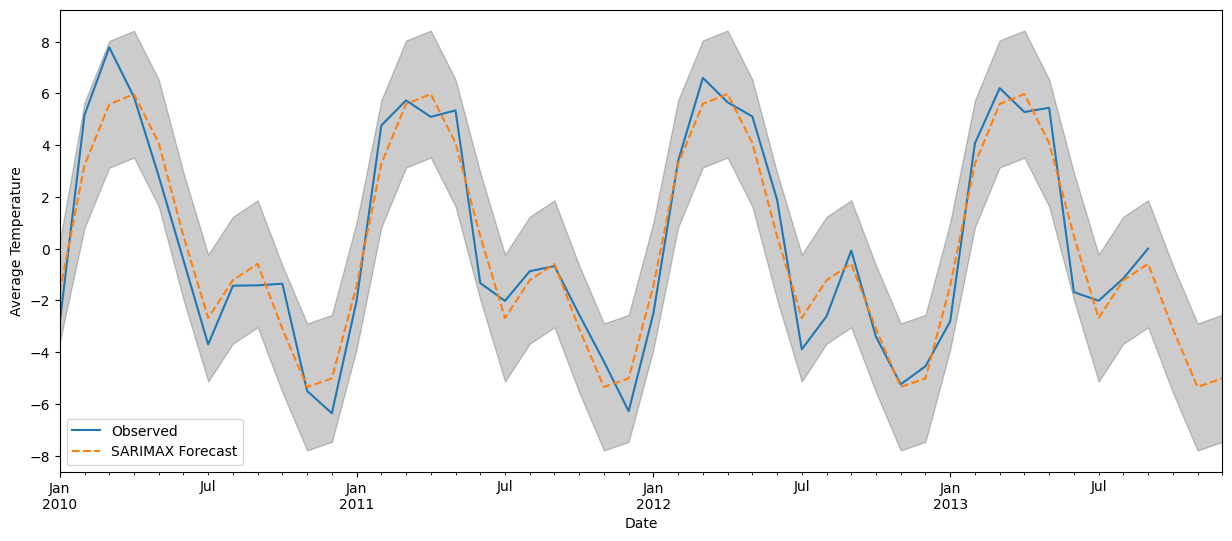

In [28]:
ax_forecast2 = time_series_data['2010':].plot(label = 'Observed')
forecast_sarimax.predicted_mean.plot(ax = ax_forecast2, label = 'SARIMAX Forecast', figsize = (15, 6), linestyle = 'dashed')
forecast_confidence_interval = forecast_sarimax.conf_int()
ax_forecast2.fill_between(forecast_confidence_interval.index, forecast_confidence_interval.iloc[:, 0], forecast_confidence_interval.iloc[:, 1], color = 'k', alpha = 0.2)
ax_forecast2.set_xlabel('Date')
ax_forecast2.set_ylabel('Average Temperature')
plt.legend()
plt.show()


In [29]:
forecast_values = forecast_sarimax.predicted_mean
forecast_index = forecast_values.index
common_index = forecast_index.intersection(test_data.index)

actual = test_data.loc[common_index]
forecast_values = forecast_values.loc[common_index]

mse = mean_squared_error(actual, forecast_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, forecast_values)
mape = np.mean(np.abs((actual - forecast_values) / actual)) * 100
r2 = r2_score(actual, forecast_values)
sse = np.sum((actual - forecast_values) ** 2)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")
print(f"Sum of Squared Errors (SSE): {sse:.4f}")

Mean Squared Error (MSE): 1.1287
Root Mean Squared Error (RMSE): 1.0624
Mean Absolute Error (MAE): 0.8942
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R²): 0.9317
Sum of Squared Errors (SSE): 50.7923


# **Yearly analysis**

## **Single year analysis of 2012**

In [ ]:

processed_data.index = pd.to_datetime(processed_data.index)

# Select time interval
start_date = '2012-01-01'
end_date = '2012-12-01'
df_interval = processed_data.loc[start_date:end_date].copy()

# Check shape
display(df_interval.shape)

(12, 2)

In [ ]:
df_interval

AverageTemperature  Seasonal_Diff
ObservationDate                                   
2012-01-01                   13.701          0.325
2012-02-01                   17.088         -1.048
2012-03-01                   23.686         -0.178
2012-04-01                   29.341          0.385
2012-05-01                   34.448          0.150
2012-06-01                   36.339          3.372
2012-07-01                   32.448          1.501
2012-08-01                   29.833         -0.242
2012-09-01                   29.759          0.360
2012-10-01                   26.354         -0.495
2012-11-01                   21.110         -1.374
2012-12-01                   16.566          0.363

In [ ]:
df_interval.shape

(12, 2)

In [ ]:
df_interval = df_interval.drop("Seasonal_Diff", axis=1)

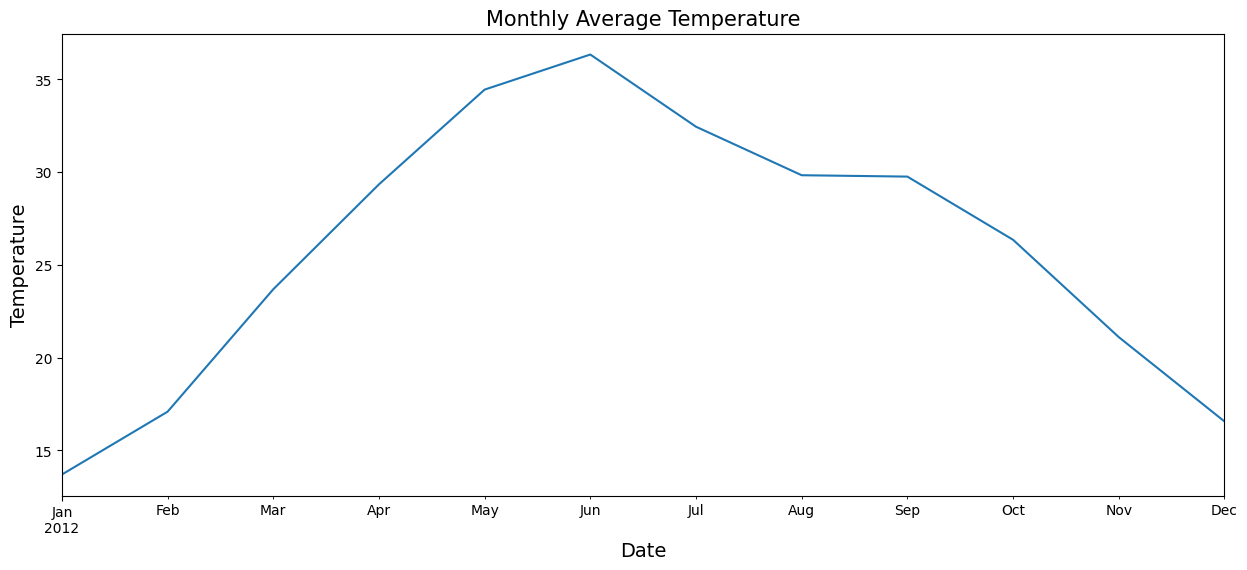

In [ ]:
# Plot original data
df_interval.plot(figsize=(15, 6), legend=None)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.title('Monthly Average Temperature', fontsize=15)
plt.show()

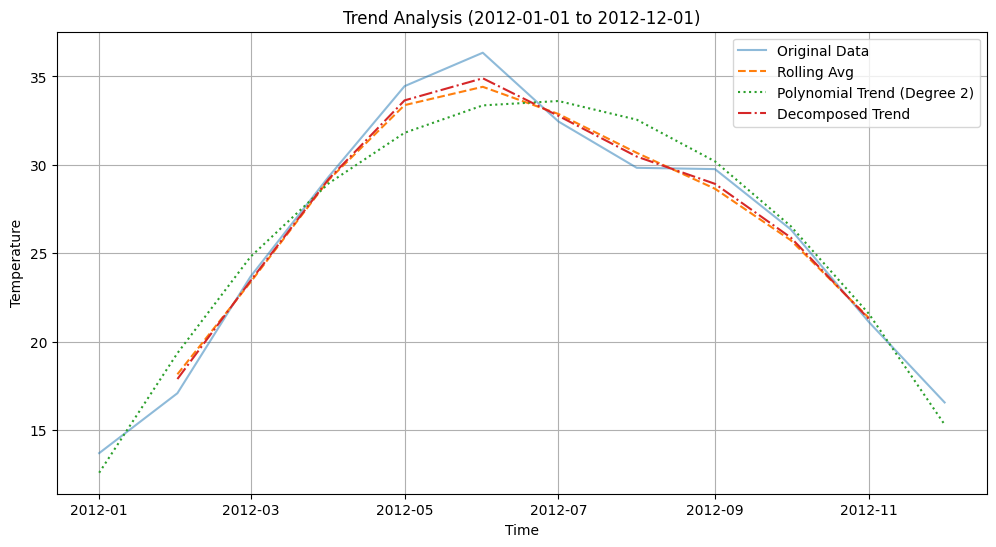

In [ ]:
# Compute Rolling Average (Moving Average) for smoothing
window_size = 3  # Adjust based on your data
df_interval['rolling_mean'] = df_interval['AverageTemperature'].rolling(window=window_size, center=True).mean()

# Fit a Polynomial Trendline (Degree 2 for Quadratic)
df_interval['time_index'] = np.arange(len(df_interval))
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df_interval[['time_index']])
model = LinearRegression().fit(X_poly, df_interval['AverageTemperature'])

# Predict trend
df_interval['trend_poly'] = model.predict(X_poly)

# Seasonal Decomposition to Extract Trend
decomposed = seasonal_decompose(df_interval['AverageTemperature'], model='additive', period=2)
df_interval['trend_decomposed'] = decomposed.trend

# Plot Trend Analysis
plt.figure(figsize=(12, 6))
plt.plot(df_interval.index, df_interval['AverageTemperature'], label='Original Data', alpha=0.5)
plt.plot(df_interval.index, df_interval['rolling_mean'], label='Rolling Avg', linestyle='dashed')
plt.plot(df_interval.index, df_interval['trend_poly'], label='Polynomial Trend (Degree 2)', linestyle='dotted')
plt.plot(df_interval.index, df_interval['trend_decomposed'], label='Decomposed Trend', linestyle='dashdot')
plt.legend()
plt.title(f"Trend Analysis ({start_date} to {end_date})")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.grid()
plt.show()


## **Two yearly analysis of 2011 and 2012**

In [ ]:

processed_data.index = pd.to_datetime(processed_data.index)

# Select time interval
start_date = '2011-01-01'
end_date = '2012-12-01'
df_interval = processed_data.loc[start_date:end_date].copy()

# Check shape
display(df_interval.shape)

(24, 2)

In [ ]:
df_interval = df_interval.drop("Seasonal_Diff", axis=1)

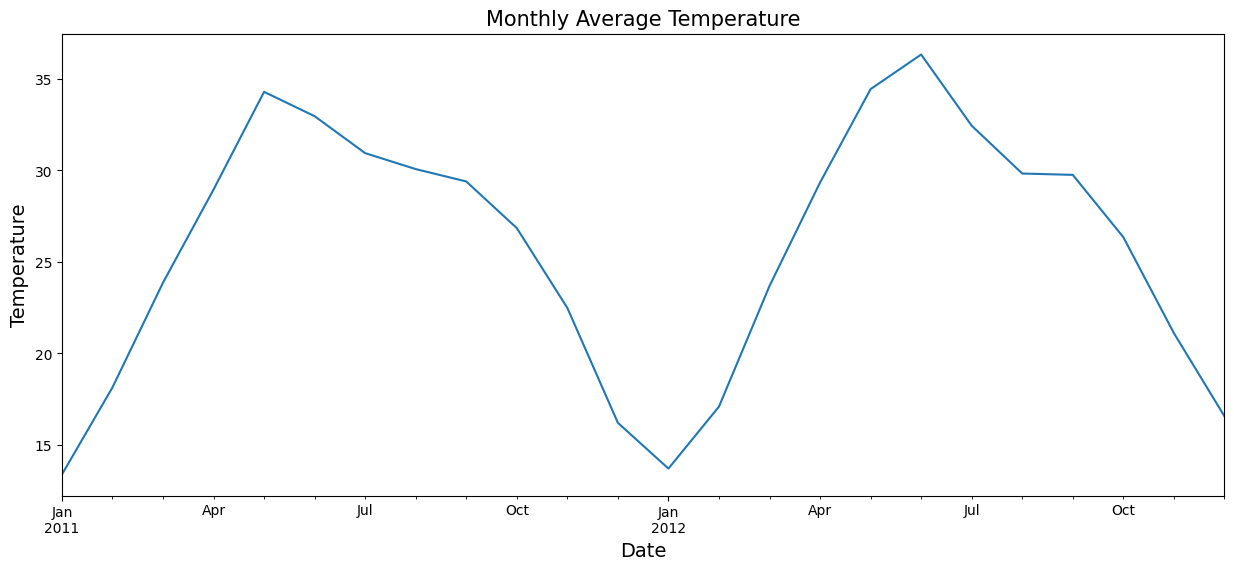

In [ ]:
# Plot original data
df_interval.plot(figsize=(15, 6), legend=None)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.title('Monthly Average Temperature', fontsize=15)
plt.show()

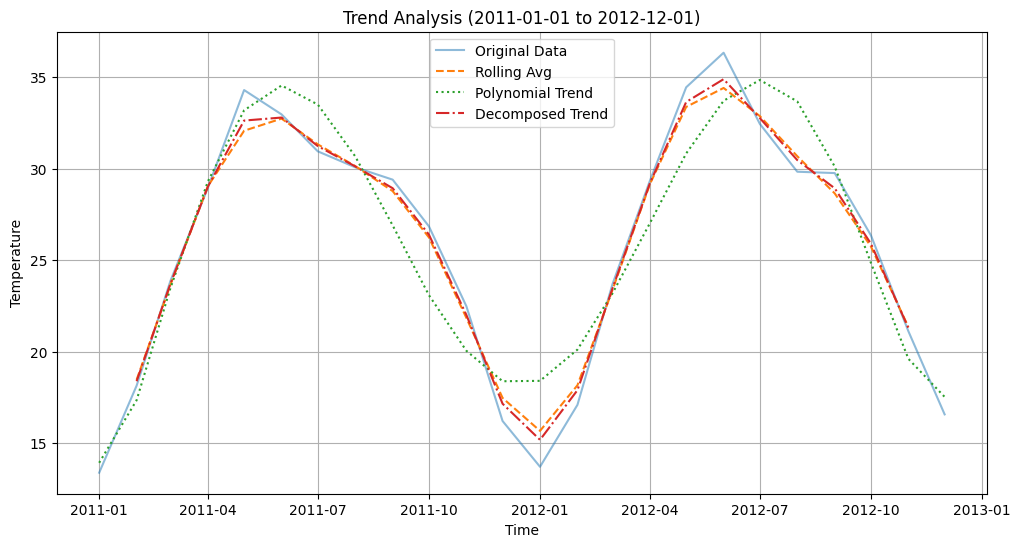

In [ ]:
# Compute Rolling Average (Moving Average) for smoothing
window_size = 3  # Adjust based on your data
df_interval['rolling_mean'] = df_interval['AverageTemperature'].rolling(window=window_size, center=True).mean()

# Fit a Polynomial Trendline
df_interval['time_index'] = np.arange(len(df_interval))
poly = PolynomialFeatures(degree=6)
X_poly = poly.fit_transform(df_interval[['time_index']])
model = LinearRegression().fit(X_poly, df_interval['AverageTemperature'])

# Predict trend
df_interval['trend_poly'] = model.predict(X_poly)

# Seasonal Decomposition to Extract Trend
decomposed = seasonal_decompose(df_interval['AverageTemperature'], model='additive', period=2)
df_interval['trend_decomposed'] = decomposed.trend

# Plot Trend Analysis
plt.figure(figsize=(12, 6))
plt.plot(df_interval.index, df_interval['AverageTemperature'], label='Original Data', alpha=0.5)
plt.plot(df_interval.index, df_interval['rolling_mean'], label='Rolling Avg', linestyle='dashed')
plt.plot(df_interval.index, df_interval['trend_poly'], label='Polynomial Trend', linestyle='dotted')
plt.plot(df_interval.index, df_interval['trend_decomposed'], label='Decomposed Trend', linestyle='dashdot')
plt.legend()
plt.title(f"Trend Analysis ({start_date} to {end_date})")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.grid()
plt.show()
